### 9. Fragmented replay composition and behavior

### (Use `TrialChoiceReplayTransition` and plot with behavior side by side.)
[This notebook uses TrialChoiceReplay().]
##### All the tables mentioned above are under shijiegu github/spyglass/shijiegu/Analysis_SGU.py. It is not in the Franklab spyglass.

Aug 21, 2024
Shijie Gu

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spikeinterface as si
import pynwb
import xarray as xr
import os
import pickle
from spyglass.utils.nwb_helper_fn import get_nwb_copy_filename

In [4]:
from spyglass.shijiegu.Analysis_SGU import TrialChoice,RippleTimes,EpochPos,TrialChoiceReplayTransition
from spyglass.shijiegu.helpers import interval_union,interpolate_to_new_time
from spyglass.shijiegu.load import load_LFP,load_position
from spyglass.shijiegu.ripple_detection import (loadRippleLFP,ExtendInterSection,InterSection,
                                                plot_ripple,threshold_by_zscore_Gu,
                                                Kay_ripple_detector,Karlsson_ripple_detector,Gu_ripple_detector,multiunit_HSE_detector,
                                                removeDataBeforeTrial1,removeArtifactTime,
                                                loadRippleLFP_OneChannelPerElectrode,ripple_detection_master)
from spyglass.shijiegu.Analysis_SGU import (TetrodeNumber,MUA,ExtendedTrialChoiceReplay,ExtendedRippleTimes,RippleTimesWithDecode)
from spyglass.common.common_position import IntervalLinearizedPosition
from spyglass.common.common_task import TaskEpoch

[2025-06-14 08:26:38,080][INFO]: DataJoint 0.14.4 connected to shijiegu-alt@lmf-db.cin.ucsf.edu:3306


In [5]:
from spyglass.shijiegu.pairwiseDecode import merge_overlapping_ranges,removeEmptyDecode
from spyglass.shijiegu.ripple_add_replay import remove_adjacent
from spyglass.shijiegu.pairwiseDecode import replay_transitions,behavior_transitions,findXCorrAllDays

from spyglass.shijiegu.fragmented_general import cont_vs_frag_occurrence_day

In [6]:
from spyglass.shijiegu.load import load_run_sessions

In [7]:
from spyglass.common.common_position import IntervalPositionInfo
from spyglass.shijiegu.load import load_run_sessions
from spyglass.shijiegu.Analysis_SGU import RippleTimesWithDecode, TrialChoice
from spyglass.shijiegu.ripple_detection import removeDataBeforeTrial1

### Specify which decoding model to use and days

In [79]:
animal = 'Eliot'
dates_to_plot = ['20221017','20221018','20221019','20221020','20221021','20221022','20221023','20221024','20221025','20221026']

encoding_set = '2Dheadspeed_above_4_andlowmua'
classifier_param_name = 'default_decoding_gpu_4armMaze'
decode_threshold_method = 'MUA_05SD'
datafolder='/cumulus/shijie/behavior_pilot/Batch1'

In [122]:
animal = 'Eliot'
dates_to_plot = ['20221017','20221018','20221019','20221020','20221021','20221022','20221023','20221024','20221025','20221026']

encoding_set = '2Dheadspeed_above_4_andlowmua'
classifier_param_name = 'default_decoding_gpu_4armMaze'
decode_threshold_method = 'MUA_0SD'
datafolder='/cumulus/shijie/behavior_pilot/Batch1'

In [145]:
animal = 'Lewis'
dates_to_plot = ['20240105','20240106','20240107','20240108','20240109','20240110']

encoding_set = '2Dheadspeed_above_4'
classifier_param_name = 'default_decoding_gpu_4armMaze'
decode_threshold_method = 'MUA_M05SD'

In [68]:
animal = 'Lewis'
animal_save_name = 'Lewis2'

dates_to_plot = ['20240116','20240117','20240118','20240119','20240120']

encoding_set = '2Dheadspeed_above_4'
classifier_param_name = 'default_decoding_gpu_4armMaze'
decode_threshold_method = 'MUA_M05SD'

# load behavior data
datafolder='/cumulus/shijie/behavior_pilot/Batch1'

In [102]:
animal = 'Molly'
animal_save_name = 'Molly'

dates_to_plot = ['20220416','20220417','20220418','20220419','20220420']

encoding_set = '2Dheadspeed_above_4'
classifier_param_name = 'default_decoding_gpu_4armMaze'
decode_threshold_method = 'MUA_M05SD'

datafolder='/stelmo/shijie/behavior_pilot/Batch1'

In [35]:
animal = 'Julio'
animal_save_name = 'Julio'

dates_to_plot = ['20230801','20230802','20230803','20230804','20230805',
                 '20230806','20230807','20230808','20230809','20230810','20230811'
                ]

encoding_set = '2Dheadspeed_above_4'
classifier_param_name = 'default_decoding_gpu_4armMaze'
decode_threshold_method = 'MUA_0SD'

datafolder='/cumulus/shijie/behavior_pilot/Batch1'

In [170]:
animal = 'Klein'
animal_save_name = 'Klein'

dates_to_plot = ['20231101','20231102','20231103','20231104','20231105','20231106','20231107','20231108',
                 '20231109','20231111','20231112','20231113','20231114'
                ]

encoding_set = '2Dheadspeed_above_4'
classifier_param_name = 'default_decoding_gpu_4armMaze'
decode_threshold_method = 'MUA_0SD'

datafolder='/cumulus/shijie/behavior_pilot/Batch1'

In [171]:
threshold = 30
if animal.lower() == "julio":
    threshold = 42
    
for d in dates_to_plot:
    nwb_copy_file_name = animal.lower() + d + '_.nwb'
    run_session_ids, run_session_names, pos_session_names = load_run_sessions(nwb_copy_file_name)

    (num_cont_day, num_frag_day,
    pct_cont_day, pct_frag_day,
     time_cont_day, time_frag_day) = ([],[],[],[],[],[])
    num_all_day = 0

    for ind in range(len(run_session_names))[:1]:
        session_name = run_session_names[ind]
        StateScript = pd.DataFrame(
                (TrialChoice & {'nwb_file_name':nwb_copy_file_name,'epoch_name':session_name}).fetch1('choice_reward'))
        if len(StateScript) < threshold:
            continue

        trial_1_t = StateScript.loc[1].timestamp_O
        trial_last_t = StateScript.loc[len(StateScript)-1].timestamp_O
        session_duration = trial_last_t - trial_1_t

        key = {'nwb_file_name': nwb_copy_file_name,
                'interval_list_name': session_name,
                'classifier_param_name': classifier_param_name,
                'encoding_set': encoding_set,
                'decode_threshold_method':decode_threshold_method}

        try:
            ripple_times = pd.read_pickle((RippleTimesWithDecode & key).fetch1('ripple_times'))
        except:
            ripple_times = pd.DataFrame((RippleTimesWithDecode & key).fetch1('ripple_times'))

*nwb_file_name *epoch    epoch_name     position_inter
+------------+ +-------+ +------------+ +------------+
klein20231101_ 1         01_Rev2Sleep1  pos 0 valid ti
klein20231101_ 2         02_Rev2Session pos 1 valid ti
klein20231101_ 3         03_Rev2Sleep2  pos 2 valid ti
klein20231101_ 4         04_Rev2Session pos 3 valid ti
klein20231101_ 5         05_Rev2Sleep3  pos 4 valid ti
klein20231101_ 6         06_Rev2Session pos 5 valid ti
klein20231101_ 7         07_Rev2Sleep4  pos 6 valid ti
klein20231101_ 8         08_Rev2Session pos 7 valid ti
klein20231101_ 9         09_Rev2Sleep5  pos 8 valid ti
klein20231101_ 10        10_Rev2Session pos 9 valid ti
klein20231101_ 11        11_Rev2Sleep6  pos 10 valid t
klein20231101_ 12        12_Rev2Session pos 11 valid t
   ...
 (Total: 13)

*nwb_file_name *epoch    epoch_name     position_inter
+------------+ +-------+ +------------+ +------------+
klein20231102_ 1         01_Rev2Sleep1  pos 0 valid ti
klein20231102_ 2         02_Rev2Session pos 

In [188]:
(num_all, 
 num_cont_all, num_frag_all, 
 pct_cont_all, pct_frag_all, 
 time_cont_all, time_frag_all) = cont_vs_frag_occurrence_day(animal,dates_to_plot,
                                                             encoding_set,classifier_param_name,decode_threshold_method,
                                                             statescript_threshold = threshold)

[2025-06-15 10:23:16,023][WARNING]: Skipped checksum for file with hash: 853d5086-bffb-ed8c-2a8c-1e71dbd93853, and path: /stelmo/nwb/analysis/klein20231101/klein20231101_92S1MX5I2G.nwb
[2025-06-15 10:23:16,043][WARNING]: Skipped checksum for file with hash: 853d5086-bffb-ed8c-2a8c-1e71dbd93853, and path: /stelmo/nwb/analysis/klein20231101/klein20231101_92S1MX5I2G.nwb
[2025-06-15 10:23:16,050][WARNING]: Skipped checksum for file with hash: 853d5086-bffb-ed8c-2a8c-1e71dbd93853, and path: /stelmo/nwb/analysis/klein20231101/klein20231101_92S1MX5I2G.nwb


*nwb_file_name *epoch    epoch_name     position_inter
+------------+ +-------+ +------------+ +------------+
klein20231101_ 1         01_Rev2Sleep1  pos 0 valid ti
klein20231101_ 2         02_Rev2Session pos 1 valid ti
klein20231101_ 3         03_Rev2Sleep2  pos 2 valid ti
klein20231101_ 4         04_Rev2Session pos 3 valid ti
klein20231101_ 5         05_Rev2Sleep3  pos 4 valid ti
klein20231101_ 6         06_Rev2Session pos 5 valid ti
klein20231101_ 7         07_Rev2Sleep4  pos 6 valid ti
klein20231101_ 8         08_Rev2Session pos 7 valid ti
klein20231101_ 9         09_Rev2Sleep5  pos 8 valid ti
klein20231101_ 10        10_Rev2Session pos 9 valid ti
klein20231101_ 11        11_Rev2Sleep6  pos 10 valid t
klein20231101_ 12        12_Rev2Session pos 11 valid t
   ...
 (Total: 13)

immobile time is  1503.1470856666565 seconds.


[2025-06-15 10:23:16,239][WARNING]: Skipped checksum for file with hash: 41d8b7d2-6c9e-1c55-1987-81d78eef7cef, and path: /stelmo/nwb/analysis/klein20231101/klein20231101_TAN9JIJRGG.nwb
[2025-06-15 10:23:16,258][WARNING]: Skipped checksum for file with hash: 41d8b7d2-6c9e-1c55-1987-81d78eef7cef, and path: /stelmo/nwb/analysis/klein20231101/klein20231101_TAN9JIJRGG.nwb
[2025-06-15 10:23:16,263][WARNING]: Skipped checksum for file with hash: 41d8b7d2-6c9e-1c55-1987-81d78eef7cef, and path: /stelmo/nwb/analysis/klein20231101/klein20231101_TAN9JIJRGG.nwb
[2025-06-15 10:23:16,471][WARNING]: Skipped checksum for file with hash: 0e3610f2-2119-9b3d-00d5-f8e76d7101b7, and path: /stelmo/nwb/analysis/klein20231101/klein20231101_45OERX9XOR.nwb


immobile time is  1876.9444069862366 seconds.


[2025-06-15 10:23:16,490][WARNING]: Skipped checksum for file with hash: 0e3610f2-2119-9b3d-00d5-f8e76d7101b7, and path: /stelmo/nwb/analysis/klein20231101/klein20231101_45OERX9XOR.nwb
[2025-06-15 10:23:16,495][WARNING]: Skipped checksum for file with hash: 0e3610f2-2119-9b3d-00d5-f8e76d7101b7, and path: /stelmo/nwb/analysis/klein20231101/klein20231101_45OERX9XOR.nwb


immobile time is  1451.8869543075562 seconds.


[2025-06-15 10:23:16,735][WARNING]: Skipped checksum for file with hash: 437abf33-08d6-68ef-0d09-f953d0505a22, and path: /stelmo/nwb/analysis/klein20231101/klein20231101_ADMA1HCA86.nwb
[2025-06-15 10:23:16,753][WARNING]: Skipped checksum for file with hash: 437abf33-08d6-68ef-0d09-f953d0505a22, and path: /stelmo/nwb/analysis/klein20231101/klein20231101_ADMA1HCA86.nwb
[2025-06-15 10:23:16,758][WARNING]: Skipped checksum for file with hash: 437abf33-08d6-68ef-0d09-f953d0505a22, and path: /stelmo/nwb/analysis/klein20231101/klein20231101_ADMA1HCA86.nwb


immobile time is  1651.375866651535 seconds.


[2025-06-15 10:23:16,998][WARNING]: Skipped checksum for file with hash: 5620f083-f5aa-0913-f619-6ae0c856b630, and path: /stelmo/nwb/analysis/klein20231101/klein20231101_HH64NTN60G.nwb
[2025-06-15 10:23:17,018][WARNING]: Skipped checksum for file with hash: 5620f083-f5aa-0913-f619-6ae0c856b630, and path: /stelmo/nwb/analysis/klein20231101/klein20231101_HH64NTN60G.nwb
[2025-06-15 10:23:17,024][WARNING]: Skipped checksum for file with hash: 5620f083-f5aa-0913-f619-6ae0c856b630, and path: /stelmo/nwb/analysis/klein20231101/klein20231101_HH64NTN60G.nwb
[2025-06-15 10:23:17,227][WARNING]: Skipped checksum for file with hash: d862fe63-aebd-71d8-9413-f590c6428dd5, and path: /stelmo/nwb/analysis/klein20231101/klein20231101_1095328ER7.nwb


immobile time is  1566.7321600914001 seconds.


[2025-06-15 10:23:17,249][WARNING]: Skipped checksum for file with hash: d862fe63-aebd-71d8-9413-f590c6428dd5, and path: /stelmo/nwb/analysis/klein20231101/klein20231101_1095328ER7.nwb
[2025-06-15 10:23:17,255][WARNING]: Skipped checksum for file with hash: d862fe63-aebd-71d8-9413-f590c6428dd5, and path: /stelmo/nwb/analysis/klein20231101/klein20231101_1095328ER7.nwb


immobile time is  1546.366334438324 seconds.
*nwb_file_name *epoch    epoch_name     position_inter
+------------+ +-------+ +------------+ +------------+
klein20231102_ 1         01_Rev2Sleep1  pos 0 valid ti
klein20231102_ 2         02_Rev2Session pos 1 valid ti
klein20231102_ 3         03_Rev2Sleep2  pos 2 valid ti
klein20231102_ 4         04_Rev2Session pos 3 valid ti
klein20231102_ 5         05_Rev2Sleep3  pos 4 valid ti
klein20231102_ 6         06_Rev2Session pos 5 valid ti
klein20231102_ 7         07_Rev2Sleep4  pos 6 valid ti
klein20231102_ 8         08_Rev2Session pos 7 valid ti
klein20231102_ 9         09_Rev2Sleep5  pos 8 valid ti
klein20231102_ 10        10_Rev2Session pos 9 valid ti
klein20231102_ 11        11_Rev2Sleep6  pos 10 valid t
 (Total: 11)



[2025-06-15 10:23:17,547][WARNING]: Skipped checksum for file with hash: a1bc9c59-a0a1-1a92-140d-93ff0635bbbf, and path: /stelmo/nwb/analysis/klein20231102/klein20231102_VIIWPKVLB3.nwb
[2025-06-15 10:23:17,568][WARNING]: Skipped checksum for file with hash: a1bc9c59-a0a1-1a92-140d-93ff0635bbbf, and path: /stelmo/nwb/analysis/klein20231102/klein20231102_VIIWPKVLB3.nwb
[2025-06-15 10:23:17,573][WARNING]: Skipped checksum for file with hash: a1bc9c59-a0a1-1a92-140d-93ff0635bbbf, and path: /stelmo/nwb/analysis/klein20231102/klein20231102_VIIWPKVLB3.nwb
[2025-06-15 10:23:17,790][WARNING]: Skipped checksum for file with hash: cebe688b-d25f-38a7-24a7-62b4d2245c93, and path: /stelmo/nwb/analysis/klein20231102/klein20231102_Y1OI7EEJAX.nwb


immobile time is  1579.342485666275 seconds.


[2025-06-15 10:23:17,809][WARNING]: Skipped checksum for file with hash: cebe688b-d25f-38a7-24a7-62b4d2245c93, and path: /stelmo/nwb/analysis/klein20231102/klein20231102_Y1OI7EEJAX.nwb
[2025-06-15 10:23:17,813][WARNING]: Skipped checksum for file with hash: cebe688b-d25f-38a7-24a7-62b4d2245c93, and path: /stelmo/nwb/analysis/klein20231102/klein20231102_Y1OI7EEJAX.nwb
[2025-06-15 10:23:17,972][WARNING]: Skipped checksum for file with hash: 5861416b-3f51-09a1-573b-e1468c5d79c9, and path: /stelmo/nwb/analysis/klein20231102/klein20231102_VE3ZFWX2C3.nwb
[2025-06-15 10:23:17,992][WARNING]: Skipped checksum for file with hash: 5861416b-3f51-09a1-573b-e1468c5d79c9, and path: /stelmo/nwb/analysis/klein20231102/klein20231102_VE3ZFWX2C3.nwb
[2025-06-15 10:23:17,997][WARNING]: Skipped checksum for file with hash: 5861416b-3f51-09a1-573b-e1468c5d79c9, and path: /stelmo/nwb/analysis/klein20231102/klein20231102_VE3ZFWX2C3.nwb


immobile time is  1192.567444562912 seconds.
immobile time is  1511.6766726970673 seconds.


[2025-06-15 10:23:18,221][WARNING]: Skipped checksum for file with hash: 93f121f2-a24b-b455-f2b7-bc993a8e4387, and path: /stelmo/nwb/analysis/klein20231102/klein20231102_OMTZ2FPUYA.nwb
[2025-06-15 10:23:18,240][WARNING]: Skipped checksum for file with hash: 93f121f2-a24b-b455-f2b7-bc993a8e4387, and path: /stelmo/nwb/analysis/klein20231102/klein20231102_OMTZ2FPUYA.nwb
[2025-06-15 10:23:18,246][WARNING]: Skipped checksum for file with hash: 93f121f2-a24b-b455-f2b7-bc993a8e4387, and path: /stelmo/nwb/analysis/klein20231102/klein20231102_OMTZ2FPUYA.nwb


immobile time is  1517.7164113521576 seconds.


[2025-06-15 10:23:18,532][WARNING]: Skipped checksum for file with hash: ed43944f-0fff-1a0c-6b77-524c438426c7, and path: /stelmo/nwb/analysis/klein20231102/klein20231102_6EJF0D72AH.nwb
[2025-06-15 10:23:18,551][WARNING]: Skipped checksum for file with hash: ed43944f-0fff-1a0c-6b77-524c438426c7, and path: /stelmo/nwb/analysis/klein20231102/klein20231102_6EJF0D72AH.nwb
[2025-06-15 10:23:18,556][WARNING]: Skipped checksum for file with hash: ed43944f-0fff-1a0c-6b77-524c438426c7, and path: /stelmo/nwb/analysis/klein20231102/klein20231102_6EJF0D72AH.nwb


immobile time is  1447.8870584964752 seconds.


[2025-06-15 10:23:18,847][WARNING]: Skipped checksum for file with hash: c4399e17-5cf6-fd62-0c6f-47def467bdd1, and path: /stelmo/nwb/analysis/klein20231103/klein20231103_MS88X2PQ2G.nwb
[2025-06-15 10:23:18,865][WARNING]: Skipped checksum for file with hash: c4399e17-5cf6-fd62-0c6f-47def467bdd1, and path: /stelmo/nwb/analysis/klein20231103/klein20231103_MS88X2PQ2G.nwb
[2025-06-15 10:23:18,870][WARNING]: Skipped checksum for file with hash: c4399e17-5cf6-fd62-0c6f-47def467bdd1, and path: /stelmo/nwb/analysis/klein20231103/klein20231103_MS88X2PQ2G.nwb


*nwb_file_name *epoch    epoch_name     position_inter
+------------+ +-------+ +------------+ +------------+
klein20231103_ 1         01_Rev2Sleep1  pos 0 valid ti
klein20231103_ 2         02_Rev2Session pos 1 valid ti
klein20231103_ 3         03_Rev2Sleep2  pos 2 valid ti
klein20231103_ 4         04_Rev2Session pos 3 valid ti
klein20231103_ 5         05_Rev2Session pos 4 valid ti
klein20231103_ 6         06_Rev2Sleep3  pos 5 valid ti
klein20231103_ 7         07_Rev2Session pos 6 valid ti
klein20231103_ 8         08_Rev2Sleep4  pos 7 valid ti
klein20231103_ 9         09_Rev2Session pos 8 valid ti
klein20231103_ 10        10_Rev2Sleep5  pos 9 valid ti
klein20231103_ 11        11_Rev2Session pos 10 valid t
klein20231103_ 12        12_Rev2Sleep6  pos 11 valid t
 (Total: 12)

immobile time is  840.7683596611023 seconds.


[2025-06-15 10:23:18,998][WARNING]: Skipped checksum for file with hash: d22fee7a-e88f-df24-4237-786b985da0d3, and path: /stelmo/nwb/analysis/klein20231103/klein20231103_1CHX0K34R8.nwb
[2025-06-15 10:23:19,015][WARNING]: Skipped checksum for file with hash: d22fee7a-e88f-df24-4237-786b985da0d3, and path: /stelmo/nwb/analysis/klein20231103/klein20231103_1CHX0K34R8.nwb
[2025-06-15 10:23:19,021][WARNING]: Skipped checksum for file with hash: d22fee7a-e88f-df24-4237-786b985da0d3, and path: /stelmo/nwb/analysis/klein20231103/klein20231103_1CHX0K34R8.nwb


immobile time is  1625.0521438121796 seconds.


[2025-06-15 10:23:19,268][WARNING]: Skipped checksum for file with hash: 6ad9b27e-5da1-cc4b-f106-66d84a662443, and path: /stelmo/nwb/analysis/klein20231103/klein20231103_UJ4YRP8XQF.nwb
[2025-06-15 10:23:19,289][WARNING]: Skipped checksum for file with hash: 6ad9b27e-5da1-cc4b-f106-66d84a662443, and path: /stelmo/nwb/analysis/klein20231103/klein20231103_UJ4YRP8XQF.nwb
[2025-06-15 10:23:19,295][WARNING]: Skipped checksum for file with hash: 6ad9b27e-5da1-cc4b-f106-66d84a662443, and path: /stelmo/nwb/analysis/klein20231103/klein20231103_UJ4YRP8XQF.nwb


immobile time is  1375.404676914215 seconds.


[2025-06-15 10:23:19,533][WARNING]: Skipped checksum for file with hash: 1b2e6aa3-1a7a-3178-5f80-12eb7e43032d, and path: /stelmo/nwb/analysis/klein20231103/klein20231103_BZEYYMKHEN.nwb
[2025-06-15 10:23:19,550][WARNING]: Skipped checksum for file with hash: 1b2e6aa3-1a7a-3178-5f80-12eb7e43032d, and path: /stelmo/nwb/analysis/klein20231103/klein20231103_BZEYYMKHEN.nwb
[2025-06-15 10:23:19,555][WARNING]: Skipped checksum for file with hash: 1b2e6aa3-1a7a-3178-5f80-12eb7e43032d, and path: /stelmo/nwb/analysis/klein20231103/klein20231103_BZEYYMKHEN.nwb


immobile time is  1259.335765361786 seconds.


[2025-06-15 10:23:19,776][WARNING]: Skipped checksum for file with hash: 6affddeb-50ca-db35-52d0-1e7998f93af4, and path: /stelmo/nwb/analysis/klein20231103/klein20231103_5EBP1834YG.nwb
[2025-06-15 10:23:19,794][WARNING]: Skipped checksum for file with hash: 6affddeb-50ca-db35-52d0-1e7998f93af4, and path: /stelmo/nwb/analysis/klein20231103/klein20231103_5EBP1834YG.nwb
[2025-06-15 10:23:19,799][WARNING]: Skipped checksum for file with hash: 6affddeb-50ca-db35-52d0-1e7998f93af4, and path: /stelmo/nwb/analysis/klein20231103/klein20231103_5EBP1834YG.nwb
[2025-06-15 10:23:20,014][WARNING]: Skipped checksum for file with hash: 926fae85-98e5-ce77-4f49-0b734dbaf486, and path: /stelmo/nwb/analysis/klein20231104/klein20231104_M2N6EPX5UM.nwb


immobile time is  1415.8090052604675 seconds.
*nwb_file_name *epoch    epoch_name     position_inter
+------------+ +-------+ +------------+ +------------+
klein20231104_ 1         01_Rev2Sleep1  pos 0 valid ti
klein20231104_ 2         02_Rev2Session pos 1 valid ti
klein20231104_ 3         03_Rev2Sleep2  pos 2 valid ti
klein20231104_ 4         04_Rev2Session pos 3 valid ti
klein20231104_ 5         05_Rev2Sleep3  pos 4 valid ti
klein20231104_ 6         06_Rev2Session pos 5 valid ti
klein20231104_ 7         07_Rev2Sleep4  pos 6 valid ti
klein20231104_ 8         08_Rev2Session pos 7 valid ti
klein20231104_ 9         09_Rev2Sleep5  pos 8 valid ti
klein20231104_ 10        10_Rev2Session pos 9 valid ti
klein20231104_ 11        11_Rev2Sleep6  pos 10 valid t
 (Total: 11)



[2025-06-15 10:23:20,033][WARNING]: Skipped checksum for file with hash: 926fae85-98e5-ce77-4f49-0b734dbaf486, and path: /stelmo/nwb/analysis/klein20231104/klein20231104_M2N6EPX5UM.nwb
[2025-06-15 10:23:20,038][WARNING]: Skipped checksum for file with hash: 926fae85-98e5-ce77-4f49-0b734dbaf486, and path: /stelmo/nwb/analysis/klein20231104/klein20231104_M2N6EPX5UM.nwb


immobile time is  1464.375424861908 seconds.


[2025-06-15 10:23:21,325][WARNING]: Skipped checksum for file with hash: f57749b1-fd11-76df-e734-e8b87d23f405, and path: /stelmo/nwb/analysis/klein20231104/klein20231104_4ED3I4DRFE.nwb
[2025-06-15 10:23:21,343][WARNING]: Skipped checksum for file with hash: f57749b1-fd11-76df-e734-e8b87d23f405, and path: /stelmo/nwb/analysis/klein20231104/klein20231104_4ED3I4DRFE.nwb
[2025-06-15 10:23:21,349][WARNING]: Skipped checksum for file with hash: f57749b1-fd11-76df-e734-e8b87d23f405, and path: /stelmo/nwb/analysis/klein20231104/klein20231104_4ED3I4DRFE.nwb


immobile time is  1698.4729461669922 seconds.


[2025-06-15 10:23:21,681][WARNING]: Skipped checksum for file with hash: 9dc14c35-dd80-6ce1-730c-417725da1ca2, and path: /stelmo/nwb/analysis/klein20231104/klein20231104_BIX0NHFA7X.nwb
[2025-06-15 10:23:21,701][WARNING]: Skipped checksum for file with hash: 9dc14c35-dd80-6ce1-730c-417725da1ca2, and path: /stelmo/nwb/analysis/klein20231104/klein20231104_BIX0NHFA7X.nwb
[2025-06-15 10:23:21,707][WARNING]: Skipped checksum for file with hash: 9dc14c35-dd80-6ce1-730c-417725da1ca2, and path: /stelmo/nwb/analysis/klein20231104/klein20231104_BIX0NHFA7X.nwb


immobile time is  1493.882283449173 seconds.


[2025-06-15 10:23:21,945][WARNING]: Skipped checksum for file with hash: f4ca7953-cf3a-7ecd-61e3-0f1bc458a51a, and path: /stelmo/nwb/analysis/klein20231104/klein20231104_T8HOEMZFSY.nwb
[2025-06-15 10:23:21,963][WARNING]: Skipped checksum for file with hash: f4ca7953-cf3a-7ecd-61e3-0f1bc458a51a, and path: /stelmo/nwb/analysis/klein20231104/klein20231104_T8HOEMZFSY.nwb
[2025-06-15 10:23:21,968][WARNING]: Skipped checksum for file with hash: f4ca7953-cf3a-7ecd-61e3-0f1bc458a51a, and path: /stelmo/nwb/analysis/klein20231104/klein20231104_T8HOEMZFSY.nwb


immobile time is  1567.9559388160706 seconds.


[2025-06-15 10:23:22,302][WARNING]: Skipped checksum for file with hash: 1004d546-aea8-c275-a73c-0e5deb3ef408, and path: /stelmo/nwb/analysis/klein20231104/klein20231104_18YYN78DM1.nwb
[2025-06-15 10:23:22,321][WARNING]: Skipped checksum for file with hash: 1004d546-aea8-c275-a73c-0e5deb3ef408, and path: /stelmo/nwb/analysis/klein20231104/klein20231104_18YYN78DM1.nwb
[2025-06-15 10:23:22,326][WARNING]: Skipped checksum for file with hash: 1004d546-aea8-c275-a73c-0e5deb3ef408, and path: /stelmo/nwb/analysis/klein20231104/klein20231104_18YYN78DM1.nwb


immobile time is  1425.440442085266 seconds.
*nwb_file_name *epoch    epoch_name     position_inter
+------------+ +-------+ +------------+ +------------+
klein20231105_ 1         01_Rev2Sleep1  pos 0 valid ti
klein20231105_ 2         02_Rev2Session pos 1 valid ti
klein20231105_ 3         03_Rev2Sleep2  pos 2 valid ti
klein20231105_ 4         04_Rev2Session pos 3 valid ti
klein20231105_ 5         05_Rev2Sleep3  pos 4 valid ti
klein20231105_ 6         06_Rev2Session pos 5 valid ti
klein20231105_ 7         07_Rev2Sleep4  pos 6 valid ti
klein20231105_ 8         08_Rev2Session pos 7 valid ti
klein20231105_ 9         09_Rev2Sleep5  pos 8 valid ti
 (Total: 9)



[2025-06-15 10:23:22,607][WARNING]: Skipped checksum for file with hash: 7690e2f2-8bd8-69e7-88d8-87713310307b, and path: /stelmo/nwb/analysis/klein20231105/klein20231105_I6MPO0Q86S.nwb
[2025-06-15 10:23:22,633][WARNING]: Skipped checksum for file with hash: 7690e2f2-8bd8-69e7-88d8-87713310307b, and path: /stelmo/nwb/analysis/klein20231105/klein20231105_I6MPO0Q86S.nwb
[2025-06-15 10:23:22,638][WARNING]: Skipped checksum for file with hash: 7690e2f2-8bd8-69e7-88d8-87713310307b, and path: /stelmo/nwb/analysis/klein20231105/klein20231105_I6MPO0Q86S.nwb
[2025-06-15 10:23:22,834][WARNING]: Skipped checksum for file with hash: 3bbf550f-15eb-81cc-6231-18c7a2af832e, and path: /stelmo/nwb/analysis/klein20231105/klein20231105_UUKPRWR3FF.nwb


immobile time is  1517.9611473083496 seconds.


[2025-06-15 10:23:22,855][WARNING]: Skipped checksum for file with hash: 3bbf550f-15eb-81cc-6231-18c7a2af832e, and path: /stelmo/nwb/analysis/klein20231105/klein20231105_UUKPRWR3FF.nwb
[2025-06-15 10:23:22,861][WARNING]: Skipped checksum for file with hash: 3bbf550f-15eb-81cc-6231-18c7a2af832e, and path: /stelmo/nwb/analysis/klein20231105/klein20231105_UUKPRWR3FF.nwb


immobile time is  1515.4717283248901 seconds.


[2025-06-15 10:23:23,089][WARNING]: Skipped checksum for file with hash: a38953ab-9cf3-f932-5623-be88a8a03fe5, and path: /stelmo/nwb/analysis/klein20231105/klein20231105_JVWJZAO2CC.nwb
[2025-06-15 10:23:23,108][WARNING]: Skipped checksum for file with hash: a38953ab-9cf3-f932-5623-be88a8a03fe5, and path: /stelmo/nwb/analysis/klein20231105/klein20231105_JVWJZAO2CC.nwb
[2025-06-15 10:23:23,114][WARNING]: Skipped checksum for file with hash: a38953ab-9cf3-f932-5623-be88a8a03fe5, and path: /stelmo/nwb/analysis/klein20231105/klein20231105_JVWJZAO2CC.nwb


immobile time is  1310.4734988212585 seconds.


[2025-06-15 10:23:23,352][WARNING]: Skipped checksum for file with hash: eab94506-54a0-c963-ff54-435d8275b6d6, and path: /stelmo/nwb/analysis/klein20231105/klein20231105_NOQ79573K7.nwb
[2025-06-15 10:23:23,372][WARNING]: Skipped checksum for file with hash: eab94506-54a0-c963-ff54-435d8275b6d6, and path: /stelmo/nwb/analysis/klein20231105/klein20231105_NOQ79573K7.nwb
[2025-06-15 10:23:23,378][WARNING]: Skipped checksum for file with hash: eab94506-54a0-c963-ff54-435d8275b6d6, and path: /stelmo/nwb/analysis/klein20231105/klein20231105_NOQ79573K7.nwb


immobile time is  1183.4666810035706 seconds.
*nwb_file_name *epoch    epoch_name     position_inter
+------------+ +-------+ +------------+ +------------+
klein20231106_ 1         01_Rev2Sleep1  pos 0 valid ti
klein20231106_ 2         02_Rev2Session pos 1 valid ti
klein20231106_ 3         03_Rev2Sleep2  pos 2 valid ti
klein20231106_ 4         04_Rev2Session pos 3 valid ti
klein20231106_ 5         05_Rev2Sleep3  pos 4 valid ti
klein20231106_ 6         06_Rev2Session pos 5 valid ti
klein20231106_ 7         07_Rev2Sleep4  pos 6 valid ti
klein20231106_ 8         08_Rev2Session pos 7 valid ti
klein20231106_ 9         09_Rev2Sleep5  pos 8 valid ti
 (Total: 9)



[2025-06-15 10:23:23,611][WARNING]: Skipped checksum for file with hash: 44e18998-484a-ca76-10ea-fb139b936b50, and path: /stelmo/nwb/analysis/klein20231106/klein20231106_SQSG2D65E4.nwb
[2025-06-15 10:23:23,630][WARNING]: Skipped checksum for file with hash: 44e18998-484a-ca76-10ea-fb139b936b50, and path: /stelmo/nwb/analysis/klein20231106/klein20231106_SQSG2D65E4.nwb
[2025-06-15 10:23:23,636][WARNING]: Skipped checksum for file with hash: 44e18998-484a-ca76-10ea-fb139b936b50, and path: /stelmo/nwb/analysis/klein20231106/klein20231106_SQSG2D65E4.nwb


immobile time is  1470.0886859893799 seconds.


[2025-06-15 10:23:23,857][WARNING]: Skipped checksum for file with hash: faf0a1e3-ebd9-9a9a-044e-49dbd699c6a1, and path: /stelmo/nwb/analysis/klein20231106/klein20231106_V2EH97KRVD.nwb
[2025-06-15 10:23:23,875][WARNING]: Skipped checksum for file with hash: faf0a1e3-ebd9-9a9a-044e-49dbd699c6a1, and path: /stelmo/nwb/analysis/klein20231106/klein20231106_V2EH97KRVD.nwb
[2025-06-15 10:23:23,882][WARNING]: Skipped checksum for file with hash: faf0a1e3-ebd9-9a9a-044e-49dbd699c6a1, and path: /stelmo/nwb/analysis/klein20231106/klein20231106_V2EH97KRVD.nwb


immobile time is  1808.4613199234009 seconds.


[2025-06-15 10:23:24,186][WARNING]: Skipped checksum for file with hash: 40811a1a-acdd-fe39-772f-43fef8a2f9b7, and path: /stelmo/nwb/analysis/klein20231106/klein20231106_YOMYKX36VT.nwb
[2025-06-15 10:23:24,208][WARNING]: Skipped checksum for file with hash: 40811a1a-acdd-fe39-772f-43fef8a2f9b7, and path: /stelmo/nwb/analysis/klein20231106/klein20231106_YOMYKX36VT.nwb
[2025-06-15 10:23:24,214][WARNING]: Skipped checksum for file with hash: 40811a1a-acdd-fe39-772f-43fef8a2f9b7, and path: /stelmo/nwb/analysis/klein20231106/klein20231106_YOMYKX36VT.nwb
[2025-06-15 10:23:24,420][WARNING]: Skipped checksum for file with hash: ac0f36cd-a518-7ad0-f8d3-de9c9be132df, and path: /stelmo/nwb/analysis/klein20231106/klein20231106_552VKLH7GF.nwb


immobile time is  1381.1596720218658 seconds.


[2025-06-15 10:23:24,439][WARNING]: Skipped checksum for file with hash: ac0f36cd-a518-7ad0-f8d3-de9c9be132df, and path: /stelmo/nwb/analysis/klein20231106/klein20231106_552VKLH7GF.nwb
[2025-06-15 10:23:24,445][WARNING]: Skipped checksum for file with hash: ac0f36cd-a518-7ad0-f8d3-de9c9be132df, and path: /stelmo/nwb/analysis/klein20231106/klein20231106_552VKLH7GF.nwb


immobile time is  1452.7032144069672 seconds.
*nwb_file_name *epoch    epoch_name     position_inter
+------------+ +-------+ +------------+ +------------+
klein20231107_ 1         01_Rev2Sleep1  pos 0 valid ti
klein20231107_ 2         02_Rev2Session pos 1 valid ti
klein20231107_ 3         03_Rev2Sleep2  pos 2 valid ti
klein20231107_ 4         04_Rev2Session pos 3 valid ti
klein20231107_ 5         05_Rev2Sleep3  pos 4 valid ti
klein20231107_ 6         06_Rev2Session pos 5 valid ti
klein20231107_ 7         07_Rev2Sleep4  pos 6 valid ti
klein20231107_ 8         08_Rev2Session pos 7 valid ti
klein20231107_ 9         09_Rev2Sleep5  pos 8 valid ti
klein20231107_ 10        10_Rev2Session pos 9 valid ti
klein20231107_ 11        11_Rev2Sleep6  pos 10 valid t
 (Total: 11)



[2025-06-15 10:23:24,703][WARNING]: Skipped checksum for file with hash: bbc35a26-7685-3b18-8b09-2d6e4952c595, and path: /stelmo/nwb/analysis/klein20231107/klein20231107_YHU6Q7W6FD.nwb
[2025-06-15 10:23:24,722][WARNING]: Skipped checksum for file with hash: bbc35a26-7685-3b18-8b09-2d6e4952c595, and path: /stelmo/nwb/analysis/klein20231107/klein20231107_YHU6Q7W6FD.nwb
[2025-06-15 10:23:24,728][WARNING]: Skipped checksum for file with hash: bbc35a26-7685-3b18-8b09-2d6e4952c595, and path: /stelmo/nwb/analysis/klein20231107/klein20231107_YHU6Q7W6FD.nwb


immobile time is  1309.5350601673126 seconds.


[2025-06-15 10:23:24,956][WARNING]: Skipped checksum for file with hash: 542208a9-b475-4235-a64a-a7c66b5ae7f7, and path: /stelmo/nwb/analysis/klein20231107/klein20231107_81X1WMXVQ9.nwb
[2025-06-15 10:23:24,975][WARNING]: Skipped checksum for file with hash: 542208a9-b475-4235-a64a-a7c66b5ae7f7, and path: /stelmo/nwb/analysis/klein20231107/klein20231107_81X1WMXVQ9.nwb
[2025-06-15 10:23:24,980][WARNING]: Skipped checksum for file with hash: 542208a9-b475-4235-a64a-a7c66b5ae7f7, and path: /stelmo/nwb/analysis/klein20231107/klein20231107_81X1WMXVQ9.nwb
[2025-06-15 10:23:25,188][WARNING]: Skipped checksum for file with hash: 11514ee5-812e-525c-df26-f14153797077, and path: /stelmo/nwb/analysis/klein20231107/klein20231107_5UDSW1ITXP.nwb


immobile time is  1227.379444360733 seconds.


[2025-06-15 10:23:25,207][WARNING]: Skipped checksum for file with hash: 11514ee5-812e-525c-df26-f14153797077, and path: /stelmo/nwb/analysis/klein20231107/klein20231107_5UDSW1ITXP.nwb
[2025-06-15 10:23:25,213][WARNING]: Skipped checksum for file with hash: 11514ee5-812e-525c-df26-f14153797077, and path: /stelmo/nwb/analysis/klein20231107/klein20231107_5UDSW1ITXP.nwb
[2025-06-15 10:23:25,425][WARNING]: Skipped checksum for file with hash: cf3eac99-7456-47eb-b851-4cb1ad63842c, and path: /stelmo/nwb/analysis/klein20231107/klein20231107_F0Z59BMNPN.nwb


immobile time is  1281.1291246414185 seconds.


[2025-06-15 10:23:25,445][WARNING]: Skipped checksum for file with hash: cf3eac99-7456-47eb-b851-4cb1ad63842c, and path: /stelmo/nwb/analysis/klein20231107/klein20231107_F0Z59BMNPN.nwb
[2025-06-15 10:23:25,451][WARNING]: Skipped checksum for file with hash: cf3eac99-7456-47eb-b851-4cb1ad63842c, and path: /stelmo/nwb/analysis/klein20231107/klein20231107_F0Z59BMNPN.nwb


immobile time is  1161.4687385559082 seconds.


[2025-06-15 10:23:25,671][WARNING]: Skipped checksum for file with hash: e15bae1d-3a20-c8ed-3670-17abf2c3153a, and path: /stelmo/nwb/analysis/klein20231107/klein20231107_PRDFFZ1I1Y.nwb
[2025-06-15 10:23:25,690][WARNING]: Skipped checksum for file with hash: e15bae1d-3a20-c8ed-3670-17abf2c3153a, and path: /stelmo/nwb/analysis/klein20231107/klein20231107_PRDFFZ1I1Y.nwb
[2025-06-15 10:23:25,696][WARNING]: Skipped checksum for file with hash: e15bae1d-3a20-c8ed-3670-17abf2c3153a, and path: /stelmo/nwb/analysis/klein20231107/klein20231107_PRDFFZ1I1Y.nwb


immobile time is  1327.6547629833221 seconds.
*nwb_file_name *epoch    epoch_name     position_inter
+------------+ +-------+ +------------+ +------------+
klein20231108_ 1         01_Rev2Sleep1  pos 0 valid ti
klein20231108_ 2         02_Rev2Session pos 1 valid ti
klein20231108_ 3         03_Rev2Sleep2  pos 2 valid ti
klein20231108_ 4         04_Rev2Session pos 3 valid ti
klein20231108_ 5         05_Rev2Sleep3  pos 4 valid ti
klein20231108_ 6         06_Rev2Session pos 5 valid ti
klein20231108_ 7         07_Rev2Sleep4  pos 6 valid ti
klein20231108_ 8         08_Rev2Session pos 7 valid ti
klein20231108_ 9         09_Rev2Sleep5  pos 8 valid ti
 (Total: 9)



[2025-06-15 10:23:25,963][WARNING]: Skipped checksum for file with hash: d77a29dd-5310-8558-de3b-d2b01b35b859, and path: /stelmo/nwb/analysis/klein20231108/klein20231108_6H4YRXUCEG.nwb
[2025-06-15 10:23:25,982][WARNING]: Skipped checksum for file with hash: d77a29dd-5310-8558-de3b-d2b01b35b859, and path: /stelmo/nwb/analysis/klein20231108/klein20231108_6H4YRXUCEG.nwb
[2025-06-15 10:23:25,987][WARNING]: Skipped checksum for file with hash: d77a29dd-5310-8558-de3b-d2b01b35b859, and path: /stelmo/nwb/analysis/klein20231108/klein20231108_6H4YRXUCEG.nwb
[2025-06-15 10:23:26,157][WARNING]: Skipped checksum for file with hash: 499ebeef-9814-243f-f3af-9abd06794321, and path: /stelmo/nwb/analysis/klein20231108/klein20231108_L5FIC0OAHD.nwb
[2025-06-15 10:23:26,178][WARNING]: Skipped checksum for file with hash: 499ebeef-9814-243f-f3af-9abd06794321, and path: /stelmo/nwb/analysis/klein20231108/klein20231108_L5FIC0OAHD.nwb
[2025-06-15 10:23:26,185][WARNING]: Skipped checksum for file with hash: 49

immobile time is  1416.3398549556732 seconds.
immobile time is  1173.5899596214294 seconds.


[2025-06-15 10:23:26,460][WARNING]: Skipped checksum for file with hash: 165d4320-8791-0c2b-ad08-0afc09c98fb5, and path: /stelmo/nwb/analysis/klein20231108/klein20231108_SCPQ07AJBN.nwb
[2025-06-15 10:23:26,486][WARNING]: Skipped checksum for file with hash: 165d4320-8791-0c2b-ad08-0afc09c98fb5, and path: /stelmo/nwb/analysis/klein20231108/klein20231108_SCPQ07AJBN.nwb
[2025-06-15 10:23:26,495][WARNING]: Skipped checksum for file with hash: 165d4320-8791-0c2b-ad08-0afc09c98fb5, and path: /stelmo/nwb/analysis/klein20231108/klein20231108_SCPQ07AJBN.nwb


immobile time is  1799.6048498153687 seconds.


[2025-06-15 10:23:26,759][WARNING]: Skipped checksum for file with hash: 37a85544-c3b8-528f-39cf-0eceb16ceae4, and path: /stelmo/nwb/analysis/klein20231108/klein20231108_WI8ZGPZI8I.nwb
[2025-06-15 10:23:26,787][WARNING]: Skipped checksum for file with hash: 37a85544-c3b8-528f-39cf-0eceb16ceae4, and path: /stelmo/nwb/analysis/klein20231108/klein20231108_WI8ZGPZI8I.nwb
[2025-06-15 10:23:26,795][WARNING]: Skipped checksum for file with hash: 37a85544-c3b8-528f-39cf-0eceb16ceae4, and path: /stelmo/nwb/analysis/klein20231108/klein20231108_WI8ZGPZI8I.nwb


immobile time is  1420.4614887237549 seconds.


[2025-06-15 10:23:27,094][WARNING]: Skipped checksum for file with hash: b12337e7-c9a4-ed10-ab1b-ff86a1e0db6f, and path: /stelmo/nwb/analysis/klein20231109/klein20231109_L3Y0G2UQD6.nwb
[2025-06-15 10:23:27,114][WARNING]: Skipped checksum for file with hash: b12337e7-c9a4-ed10-ab1b-ff86a1e0db6f, and path: /stelmo/nwb/analysis/klein20231109/klein20231109_L3Y0G2UQD6.nwb
[2025-06-15 10:23:27,121][WARNING]: Skipped checksum for file with hash: b12337e7-c9a4-ed10-ab1b-ff86a1e0db6f, and path: /stelmo/nwb/analysis/klein20231109/klein20231109_L3Y0G2UQD6.nwb


*nwb_file_name *epoch    epoch_name     position_inter
+------------+ +-------+ +------------+ +------------+
klein20231109_ 1         01_Rev2Sleep1  pos 0 valid ti
klein20231109_ 2         02_Rev2Session pos 1 valid ti
klein20231109_ 3         03_Rev2Sleep2  pos 2 valid ti
klein20231109_ 4         04_Rev2Session pos 3 valid ti
klein20231109_ 5         05_Rev2Sleep3  pos 4 valid ti
klein20231109_ 6         06_Rev2Session pos 5 valid ti
klein20231109_ 7         07_Rev2Sleep4  pos 6 valid ti
klein20231109_ 8         08_Rev2Session pos 7 valid ti
klein20231109_ 9         09_Rev2Sleep5  pos 8 valid ti
klein20231109_ 10        10_Rev2Session pos 9 valid ti
klein20231109_ 11        11_Rev2Sleep6  pos 10 valid t
 (Total: 11)

immobile time is  1607.2577822208405 seconds.


[2025-06-15 10:23:27,324][WARNING]: Skipped checksum for file with hash: 3609ac88-0e95-7a62-26c1-8039723e52ac, and path: /stelmo/nwb/analysis/klein20231109/klein20231109_3HM1ZLMLC4.nwb
[2025-06-15 10:23:27,344][WARNING]: Skipped checksum for file with hash: 3609ac88-0e95-7a62-26c1-8039723e52ac, and path: /stelmo/nwb/analysis/klein20231109/klein20231109_3HM1ZLMLC4.nwb
[2025-06-15 10:23:27,352][WARNING]: Skipped checksum for file with hash: 3609ac88-0e95-7a62-26c1-8039723e52ac, and path: /stelmo/nwb/analysis/klein20231109/klein20231109_3HM1ZLMLC4.nwb


immobile time is  1661.7828092575073 seconds.


[2025-06-15 10:23:27,578][WARNING]: Skipped checksum for file with hash: c8b76ae1-d9e3-a991-09da-b8798a67cebf, and path: /stelmo/nwb/analysis/klein20231109/klein20231109_B7XL0NVKKT.nwb
[2025-06-15 10:23:27,596][WARNING]: Skipped checksum for file with hash: c8b76ae1-d9e3-a991-09da-b8798a67cebf, and path: /stelmo/nwb/analysis/klein20231109/klein20231109_B7XL0NVKKT.nwb
[2025-06-15 10:23:27,601][WARNING]: Skipped checksum for file with hash: c8b76ae1-d9e3-a991-09da-b8798a67cebf, and path: /stelmo/nwb/analysis/klein20231109/klein20231109_B7XL0NVKKT.nwb
[2025-06-15 10:23:27,802][WARNING]: Skipped checksum for file with hash: 88e0930d-c26c-4c58-9fba-279b82657cb2, and path: /stelmo/nwb/analysis/klein20231109/klein20231109_4EL6KZ7PVP.nwb


immobile time is  1248.5613007545471 seconds.


[2025-06-15 10:23:27,821][WARNING]: Skipped checksum for file with hash: 88e0930d-c26c-4c58-9fba-279b82657cb2, and path: /stelmo/nwb/analysis/klein20231109/klein20231109_4EL6KZ7PVP.nwb
[2025-06-15 10:23:27,827][WARNING]: Skipped checksum for file with hash: 88e0930d-c26c-4c58-9fba-279b82657cb2, and path: /stelmo/nwb/analysis/klein20231109/klein20231109_4EL6KZ7PVP.nwb
[2025-06-15 10:23:28,023][WARNING]: Skipped checksum for file with hash: 16a7e851-e4cc-2e34-5980-9e8bb2de44b9, and path: /stelmo/nwb/analysis/klein20231109/klein20231109_2LXB8PGU3C.nwb
[2025-06-15 10:23:28,043][WARNING]: Skipped checksum for file with hash: 16a7e851-e4cc-2e34-5980-9e8bb2de44b9, and path: /stelmo/nwb/analysis/klein20231109/klein20231109_2LXB8PGU3C.nwb


immobile time is  1208.6472461223602 seconds.


[2025-06-15 10:23:28,049][WARNING]: Skipped checksum for file with hash: 16a7e851-e4cc-2e34-5980-9e8bb2de44b9, and path: /stelmo/nwb/analysis/klein20231109/klein20231109_2LXB8PGU3C.nwb


immobile time is  1341.0006890296936 seconds.
*nwb_file_name *epoch    epoch_name     position_inter
+------------+ +-------+ +------------+ +------------+
klein20231111_ 1         01_Rev2Sleep1  pos 0 valid ti
klein20231111_ 2         02_Rev2Session pos 1 valid ti
klein20231111_ 3         03_Rev2Sleep2  pos 2 valid ti
klein20231111_ 4         04_Rev2Session pos 3 valid ti
klein20231111_ 5         05_Rev2Sleep3  pos 4 valid ti
klein20231111_ 6         06_Rev2Session pos 5 valid ti
klein20231111_ 7         07_Rev2Sleep4  pos 6 valid ti
klein20231111_ 8         08_Rev2Session pos 7 valid ti
klein20231111_ 9         09_Rev2Sleep5  pos 8 valid ti
klein20231111_ 10        10_Rev2Session pos 9 valid ti
klein20231111_ 11        11_Rev2Sleep6  pos 10 valid t
 (Total: 11)



[2025-06-15 10:23:28,311][WARNING]: Skipped checksum for file with hash: 02e28a13-9803-1b1e-a0c8-0e8260a98aa9, and path: /stelmo/nwb/analysis/klein20231111/klein20231111_18TK4QPZ4X.nwb
[2025-06-15 10:23:28,331][WARNING]: Skipped checksum for file with hash: 02e28a13-9803-1b1e-a0c8-0e8260a98aa9, and path: /stelmo/nwb/analysis/klein20231111/klein20231111_18TK4QPZ4X.nwb
[2025-06-15 10:23:28,338][WARNING]: Skipped checksum for file with hash: 02e28a13-9803-1b1e-a0c8-0e8260a98aa9, and path: /stelmo/nwb/analysis/klein20231111/klein20231111_18TK4QPZ4X.nwb


immobile time is  1835.2338087558746 seconds.


[2025-06-15 10:23:28,562][WARNING]: Skipped checksum for file with hash: 57c9606f-f63a-7710-cab2-4f0cca69a8e6, and path: /stelmo/nwb/analysis/klein20231111/klein20231111_2CEWQSZVCK.nwb
[2025-06-15 10:23:28,583][WARNING]: Skipped checksum for file with hash: 57c9606f-f63a-7710-cab2-4f0cca69a8e6, and path: /stelmo/nwb/analysis/klein20231111/klein20231111_2CEWQSZVCK.nwb
[2025-06-15 10:23:28,590][WARNING]: Skipped checksum for file with hash: 57c9606f-f63a-7710-cab2-4f0cca69a8e6, and path: /stelmo/nwb/analysis/klein20231111/klein20231111_2CEWQSZVCK.nwb


immobile time is  2008.1133632659912 seconds.


[2025-06-15 10:23:28,882][WARNING]: Skipped checksum for file with hash: 581046b9-984a-9de4-4bb2-5aeeab9a0533, and path: /stelmo/nwb/analysis/klein20231111/klein20231111_FJVVAUPTD0.nwb
[2025-06-15 10:23:28,903][WARNING]: Skipped checksum for file with hash: 581046b9-984a-9de4-4bb2-5aeeab9a0533, and path: /stelmo/nwb/analysis/klein20231111/klein20231111_FJVVAUPTD0.nwb
[2025-06-15 10:23:28,911][WARNING]: Skipped checksum for file with hash: 581046b9-984a-9de4-4bb2-5aeeab9a0533, and path: /stelmo/nwb/analysis/klein20231111/klein20231111_FJVVAUPTD0.nwb


immobile time is  1684.2295491695404 seconds.


[2025-06-15 10:23:29,182][WARNING]: Skipped checksum for file with hash: 82d2a73e-8e72-f892-4f29-37c747f560db, and path: /stelmo/nwb/analysis/klein20231111/klein20231111_8Q2OVZ4ZYL.nwb
[2025-06-15 10:23:29,204][WARNING]: Skipped checksum for file with hash: 82d2a73e-8e72-f892-4f29-37c747f560db, and path: /stelmo/nwb/analysis/klein20231111/klein20231111_8Q2OVZ4ZYL.nwb
[2025-06-15 10:23:29,211][WARNING]: Skipped checksum for file with hash: 82d2a73e-8e72-f892-4f29-37c747f560db, and path: /stelmo/nwb/analysis/klein20231111/klein20231111_8Q2OVZ4ZYL.nwb


immobile time is  1536.1637716293335 seconds.


[2025-06-15 10:23:29,525][WARNING]: Skipped checksum for file with hash: 113b2ee4-a0e6-1ae5-9e07-cd289e812eff, and path: /stelmo/nwb/analysis/klein20231112/klein20231112_SYJ9VJYH56.nwb
[2025-06-15 10:23:29,546][WARNING]: Skipped checksum for file with hash: 113b2ee4-a0e6-1ae5-9e07-cd289e812eff, and path: /stelmo/nwb/analysis/klein20231112/klein20231112_SYJ9VJYH56.nwb
[2025-06-15 10:23:29,554][WARNING]: Skipped checksum for file with hash: 113b2ee4-a0e6-1ae5-9e07-cd289e812eff, and path: /stelmo/nwb/analysis/klein20231112/klein20231112_SYJ9VJYH56.nwb


*nwb_file_name *epoch    epoch_name     position_inter
+------------+ +-------+ +------------+ +------------+
klein20231112_ 1         01_Rev2Sleep1  pos 0 valid ti
klein20231112_ 2         02_Rev2Session pos 1 valid ti
klein20231112_ 3         03_Rev2Sleep2  pos 2 valid ti
klein20231112_ 4         04_Rev2Session pos 3 valid ti
klein20231112_ 5         05_Rev2Sleep3  pos 4 valid ti
klein20231112_ 6         06_Rev2Session pos 5 valid ti
klein20231112_ 7         07_Rev2Sleep4  pos 6 valid ti
klein20231112_ 8         08_Rev2Session pos 7 valid ti
klein20231112_ 9         09_Rev2Sleep5  pos 8 valid ti
 (Total: 9)

immobile time is  1371.2425096035004 seconds.


[2025-06-15 10:23:29,728][WARNING]: Skipped checksum for file with hash: b7611172-c229-2fa5-03ad-990cb57a485d, and path: /stelmo/nwb/analysis/klein20231112/klein20231112_KT603L07SP.nwb
[2025-06-15 10:23:29,747][WARNING]: Skipped checksum for file with hash: b7611172-c229-2fa5-03ad-990cb57a485d, and path: /stelmo/nwb/analysis/klein20231112/klein20231112_KT603L07SP.nwb
[2025-06-15 10:23:29,753][WARNING]: Skipped checksum for file with hash: b7611172-c229-2fa5-03ad-990cb57a485d, and path: /stelmo/nwb/analysis/klein20231112/klein20231112_KT603L07SP.nwb


immobile time is  1694.1874330043793 seconds.


[2025-06-15 10:23:29,989][WARNING]: Skipped checksum for file with hash: 86c98a29-c38c-81df-090d-91f4a67eedbb, and path: /stelmo/nwb/analysis/klein20231112/klein20231112_OA1WN7WZPB.nwb
[2025-06-15 10:23:30,007][WARNING]: Skipped checksum for file with hash: 86c98a29-c38c-81df-090d-91f4a67eedbb, and path: /stelmo/nwb/analysis/klein20231112/klein20231112_OA1WN7WZPB.nwb
[2025-06-15 10:23:30,013][WARNING]: Skipped checksum for file with hash: 86c98a29-c38c-81df-090d-91f4a67eedbb, and path: /stelmo/nwb/analysis/klein20231112/klein20231112_OA1WN7WZPB.nwb


immobile time is  1397.1577429771423 seconds.


[2025-06-15 10:23:30,236][WARNING]: Skipped checksum for file with hash: ad6286a1-72e9-7bef-c47f-25426a72c6e2, and path: /stelmo/nwb/analysis/klein20231112/klein20231112_2W3FDHI5FX.nwb
[2025-06-15 10:23:30,254][WARNING]: Skipped checksum for file with hash: ad6286a1-72e9-7bef-c47f-25426a72c6e2, and path: /stelmo/nwb/analysis/klein20231112/klein20231112_2W3FDHI5FX.nwb
[2025-06-15 10:23:30,260][WARNING]: Skipped checksum for file with hash: ad6286a1-72e9-7bef-c47f-25426a72c6e2, and path: /stelmo/nwb/analysis/klein20231112/klein20231112_2W3FDHI5FX.nwb


immobile time is  1419.971953868866 seconds.
*nwb_file_name *epoch    epoch_name     position_inter
+------------+ +-------+ +------------+ +------------+
klein20231113_ 1         01_Rev2Sleep1  pos 0 valid ti
klein20231113_ 2         02_Rev2Session pos 1 valid ti
klein20231113_ 3         03_Rev2Sleep2  pos 2 valid ti
klein20231113_ 4         04_Rev2Session pos 3 valid ti
klein20231113_ 5         05_Rev2Sleep3  pos 4 valid ti
klein20231113_ 6         06_Rev2Session pos 5 valid ti
klein20231113_ 7         07_Rev2Sleep4  pos 6 valid ti
klein20231113_ 8         08_Rev2Session pos 7 valid ti
klein20231113_ 9         09_Rev2Sleep5  pos 8 valid ti
 (Total: 9)



[2025-06-15 10:23:30,523][WARNING]: Skipped checksum for file with hash: fb98aad9-b491-0dd9-863f-24b52d3ab2c4, and path: /stelmo/nwb/analysis/klein20231113/klein20231113_DTAAH5LI2O.nwb
[2025-06-15 10:23:30,542][WARNING]: Skipped checksum for file with hash: fb98aad9-b491-0dd9-863f-24b52d3ab2c4, and path: /stelmo/nwb/analysis/klein20231113/klein20231113_DTAAH5LI2O.nwb
[2025-06-15 10:23:30,547][WARNING]: Skipped checksum for file with hash: fb98aad9-b491-0dd9-863f-24b52d3ab2c4, and path: /stelmo/nwb/analysis/klein20231113/klein20231113_DTAAH5LI2O.nwb
[2025-06-15 10:23:30,730][WARNING]: Skipped checksum for file with hash: fb7e2206-5678-10fa-a4ce-688fa37393ef, and path: /stelmo/nwb/analysis/klein20231113/klein20231113_5VAT1ENF7I.nwb
[2025-06-15 10:23:30,748][WARNING]: Skipped checksum for file with hash: fb7e2206-5678-10fa-a4ce-688fa37393ef, and path: /stelmo/nwb/analysis/klein20231113/klein20231113_5VAT1ENF7I.nwb
[2025-06-15 10:23:30,754][WARNING]: Skipped checksum for file with hash: fb

immobile time is  1730.796040058136 seconds.
immobile time is  2005.0936334133148 seconds.


[2025-06-15 10:23:31,032][WARNING]: Skipped checksum for file with hash: 6c82899f-b33e-bb68-19e0-49403a8cb698, and path: /stelmo/nwb/analysis/klein20231113/klein20231113_WNRWZ36FI5.nwb
[2025-06-15 10:23:31,050][WARNING]: Skipped checksum for file with hash: 6c82899f-b33e-bb68-19e0-49403a8cb698, and path: /stelmo/nwb/analysis/klein20231113/klein20231113_WNRWZ36FI5.nwb
[2025-06-15 10:23:31,057][WARNING]: Skipped checksum for file with hash: 6c82899f-b33e-bb68-19e0-49403a8cb698, and path: /stelmo/nwb/analysis/klein20231113/klein20231113_WNRWZ36FI5.nwb


immobile time is  1683.9030153751373 seconds.


[2025-06-15 10:23:31,324][WARNING]: Skipped checksum for file with hash: 1adaf64f-b727-74a1-0aba-cecfda5878ce, and path: /stelmo/nwb/analysis/klein20231113/klein20231113_VAXT7T3QBV.nwb
[2025-06-15 10:23:31,344][WARNING]: Skipped checksum for file with hash: 1adaf64f-b727-74a1-0aba-cecfda5878ce, and path: /stelmo/nwb/analysis/klein20231113/klein20231113_VAXT7T3QBV.nwb
[2025-06-15 10:23:31,350][WARNING]: Skipped checksum for file with hash: 1adaf64f-b727-74a1-0aba-cecfda5878ce, and path: /stelmo/nwb/analysis/klein20231113/klein20231113_VAXT7T3QBV.nwb


immobile time is  1262.396859884262 seconds.
*nwb_file_name *epoch    epoch_name     position_inter
+------------+ +-------+ +------------+ +------------+
klein20231114_ 1         01_Rev2Sleep1  pos 0 valid ti
klein20231114_ 2         02_Rev2Session pos 1 valid ti
klein20231114_ 3         03_Rev2Sleep2  pos 2 valid ti
klein20231114_ 4         04_Rev2Session pos 3 valid ti
klein20231114_ 5         05_Rev2Sleep3  pos 4 valid ti
klein20231114_ 6         06_Rev2Session pos 5 valid ti
klein20231114_ 7         07_Rev2Sleep4  pos 6 valid ti
klein20231114_ 8         08_Rev2Session pos 7 valid ti
klein20231114_ 9         09_Rev2Sleep5  pos 8 valid ti
 (Total: 9)



[2025-06-15 10:23:31,596][WARNING]: Skipped checksum for file with hash: 74ba99f9-d1cf-5725-c37f-2b424fde0685, and path: /stelmo/nwb/analysis/klein20231114/klein20231114_8ECUY0CYN7.nwb
[2025-06-15 10:23:31,616][WARNING]: Skipped checksum for file with hash: 74ba99f9-d1cf-5725-c37f-2b424fde0685, and path: /stelmo/nwb/analysis/klein20231114/klein20231114_8ECUY0CYN7.nwb
[2025-06-15 10:23:31,622][WARNING]: Skipped checksum for file with hash: 74ba99f9-d1cf-5725-c37f-2b424fde0685, and path: /stelmo/nwb/analysis/klein20231114/klein20231114_8ECUY0CYN7.nwb
[2025-06-15 10:23:31,791][WARNING]: Skipped checksum for file with hash: 440b48be-3d44-3690-e06f-7ea78d89ac0b, and path: /stelmo/nwb/analysis/klein20231114/klein20231114_KSM0UPPRMZ.nwb
[2025-06-15 10:23:31,812][WARNING]: Skipped checksum for file with hash: 440b48be-3d44-3690-e06f-7ea78d89ac0b, and path: /stelmo/nwb/analysis/klein20231114/klein20231114_KSM0UPPRMZ.nwb
[2025-06-15 10:23:31,819][WARNING]: Skipped checksum for file with hash: 44

immobile time is  1454.6214616298676 seconds.
immobile time is  1684.1887340545654 seconds.


[2025-06-15 10:23:32,047][WARNING]: Skipped checksum for file with hash: 2572b6da-bc60-f516-6909-c19181edc39a, and path: /stelmo/nwb/analysis/klein20231114/klein20231114_AHXSHOFOMN.nwb
[2025-06-15 10:23:32,067][WARNING]: Skipped checksum for file with hash: 2572b6da-bc60-f516-6909-c19181edc39a, and path: /stelmo/nwb/analysis/klein20231114/klein20231114_AHXSHOFOMN.nwb
[2025-06-15 10:23:32,075][WARNING]: Skipped checksum for file with hash: 2572b6da-bc60-f516-6909-c19181edc39a, and path: /stelmo/nwb/analysis/klein20231114/klein20231114_AHXSHOFOMN.nwb


immobile time is  1924.5301151275635 seconds.


[2025-06-15 10:23:32,586][WARNING]: Skipped checksum for file with hash: cafa44e8-5dfa-a48c-f1db-c4a94b8f1e33, and path: /stelmo/nwb/analysis/klein20231114/klein20231114_SPDT6QT5VV.nwb
[2025-06-15 10:23:32,606][WARNING]: Skipped checksum for file with hash: cafa44e8-5dfa-a48c-f1db-c4a94b8f1e33, and path: /stelmo/nwb/analysis/klein20231114/klein20231114_SPDT6QT5VV.nwb
[2025-06-15 10:23:32,614][WARNING]: Skipped checksum for file with hash: cafa44e8-5dfa-a48c-f1db-c4a94b8f1e33, and path: /stelmo/nwb/analysis/klein20231114/klein20231114_SPDT6QT5VV.nwb


immobile time is  2180.2176308631897 seconds.


### plot by session

#### load behavior

In [173]:
sequence_datapath = os.path.join(datafolder,animal,'behavior_metaSequence_'+animal+'.p')
data_pair=pickle.load(open(os.path.join(datafolder,'behavior_correctPair_'+animal+'.p'), "rb"))
#data_seqlen=pickle.load(open(os.path.join(datafolder,animal,'behavior_sequencelen_'+animal+'.p'), "rb"))

with open(sequence_datapath, 'rb') as f:
    behavior_data = pickle.load(f)  
    
total_trial_num = {}
occurance_rates = {}
pct_correct = {}
#seq_len = {}
seq_types = {}

for day in dates_to_plot:
    subset_ind = np.argwhere(behavior_data['dateIntAll'] == int(day)).ravel()
    
    total_trial_num_day = np.zeros(len(subset_ind))
    occurance_rates_day = np.zeros((len(subset_ind),6))
    pct_correct_day = np.zeros((len(subset_ind),6))
    seq_types_day = np.zeros(len(subset_ind))
    #seq_len_day = np.zeros(len(subset_ind))
    
    print(day)
    print(len(subset_ind))
    
    for n in range(len(subset_ind)):

        session_ind = subset_ind[n]
        total_trial_num_day[n] = len(behavior_data['outersAll'][session_ind])
        seq_types_day[n] = behavior_data['seqtype_int'][session_ind]
        #seq_len_day[n] = data_seqlen['mean'][session_ind]
        
        for seq in range(6):
            occurance_rates_day[n,seq] = np.mean(behavior_data['occurance_rates'][seq][session_ind])
            pct_correct_day[n,seq] = data_pair['pctCorrect'][session_ind][seq]
    
    total_trial_num[day] = total_trial_num_day
    occurance_rates[day] = occurance_rates_day
    seq_types[day] = seq_types_day
    pct_correct[day] = pct_correct_day
    #seq_len[day] = seq_len_day

20231101
6
20231102
5
20231103
5
20231104
5
20231105
4
20231106
4
20231107
5
20231108
4
20231109
5
20231111
4
20231112
4
20231113
4
20231114
4


In [176]:
StateScript = pd.DataFrame(
            (TrialChoice & {'nwb_file_name':"klein20231111_.nwb",'epoch_name':"10_Rev2Session5"}).fetch1('choice_reward'))

In [177]:
len(StateScript)

49

In [180]:
label = []
for d in dates_to_plot:
    nwb_copy_file_name = animal.lower() + d + '_.nwb'
    run_session_ids, run_session_names, pos_session_names = load_run_sessions(nwb_copy_file_name)
    
    for ind in range(len(run_session_names)):
        session_name = run_session_names[ind]
        StateScript = pd.DataFrame(
            (TrialChoice & {'nwb_file_name':nwb_copy_file_name,'epoch_name':session_name}).fetch1('choice_reward'))
            
        if len(StateScript) < threshold:
            continue
        if nwb_copy_file_name == "klein20231111_.nwb" and session_name == "10_Rev2Session5":
            continue
        
        label.append(d[6:9]+'\n'+str(run_session_ids[ind]))

*nwb_file_name *epoch    epoch_name     position_inter
+------------+ +-------+ +------------+ +------------+
klein20231101_ 1         01_Rev2Sleep1  pos 0 valid ti
klein20231101_ 2         02_Rev2Session pos 1 valid ti
klein20231101_ 3         03_Rev2Sleep2  pos 2 valid ti
klein20231101_ 4         04_Rev2Session pos 3 valid ti
klein20231101_ 5         05_Rev2Sleep3  pos 4 valid ti
klein20231101_ 6         06_Rev2Session pos 5 valid ti
klein20231101_ 7         07_Rev2Sleep4  pos 6 valid ti
klein20231101_ 8         08_Rev2Session pos 7 valid ti
klein20231101_ 9         09_Rev2Sleep5  pos 8 valid ti
klein20231101_ 10        10_Rev2Session pos 9 valid ti
klein20231101_ 11        11_Rev2Sleep6  pos 10 valid t
klein20231101_ 12        12_Rev2Session pos 11 valid t
   ...
 (Total: 13)

*nwb_file_name *epoch    epoch_name     position_inter
+------------+ +-------+ +------------+ +------------+
klein20231102_ 1         01_Rev2Sleep1  pos 0 valid ti
klein20231102_ 2         02_Rev2Session pos 

In [186]:
len(time_frag_plot)

60

In [187]:
len(label)

59

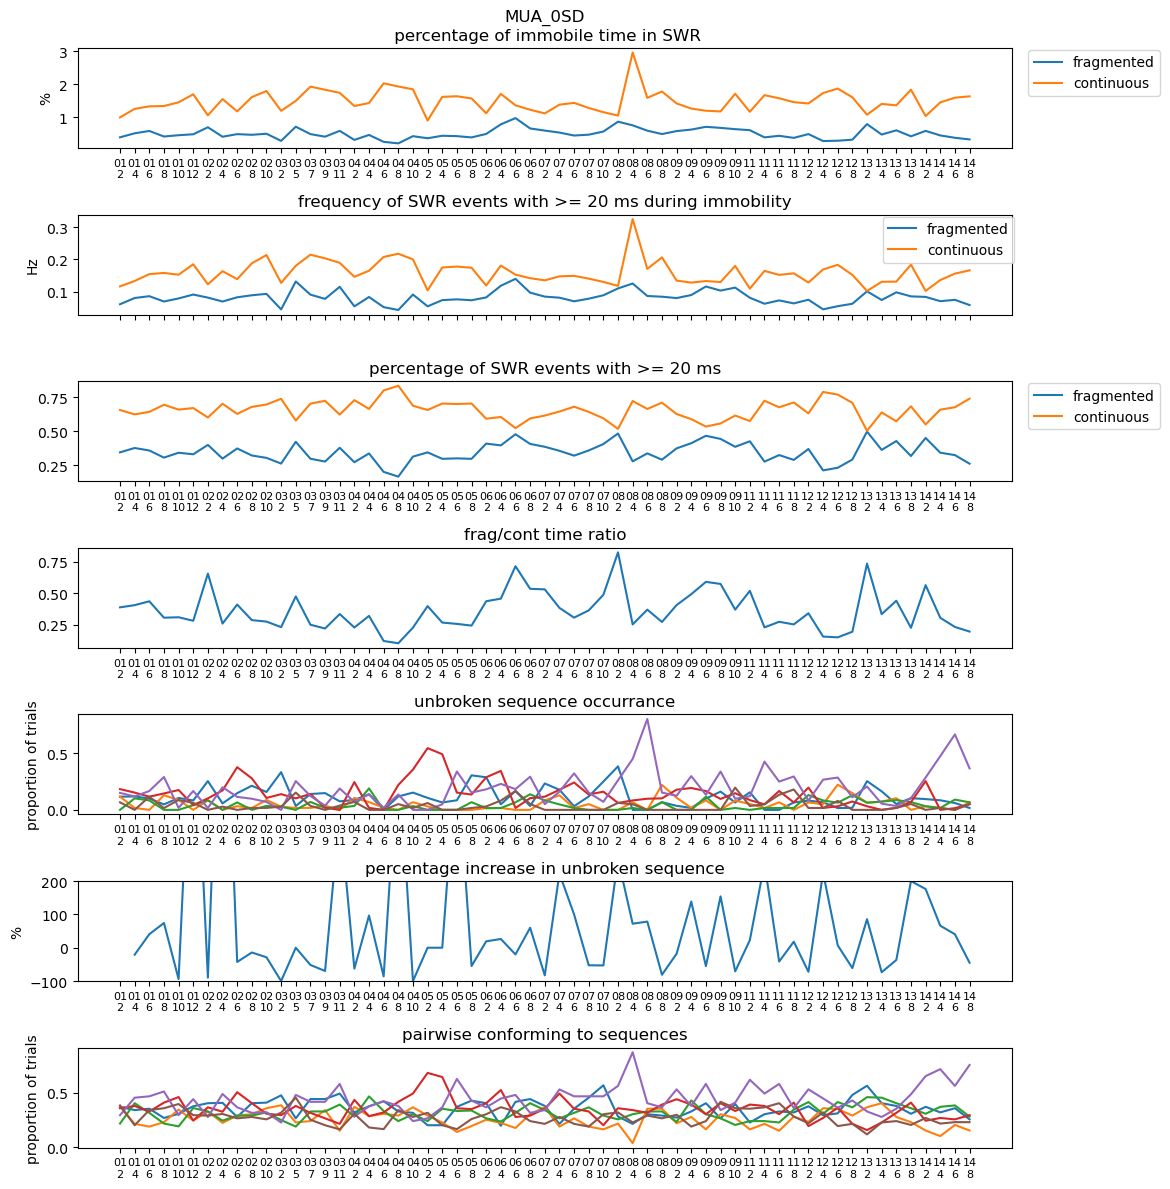

In [189]:
occurance_rates_all = np.concatenate([occurance_rates[k] for k in occurance_rates])
seq_types_all = np.concatenate([seq_types[k] for k in seq_types])

correct_seq_occurance = [
    occurance_rates_all[session_ind,int(seq_types_all[session_ind]-1)] for session_ind in range(len(seq_types_all))]

time_cont_plot = np.concatenate([time_cont_all[d] for d in dates_to_plot])
time_frag_plot = np.concatenate([time_frag_all[d] for d in dates_to_plot])

num_cont_plot = np.concatenate([num_cont_all[d] for d in dates_to_plot])
num_frag_plot = np.concatenate([num_frag_all[d] for d in dates_to_plot])

pct_cont_plot = np.concatenate([pct_cont_all[d] for d in dates_to_plot])
pct_frag_plot = np.concatenate([pct_frag_all[d] for d in dates_to_plot])

fig, axes = plt.subplots(7,1, figsize = (6 * len(time_cont_plot)/30, 12),sharex = True)
axes[0].plot(time_frag_plot*100, label = 'fragmented')
axes[0].plot(time_cont_plot*100, label = 'continuous')
axes[0].set_xticks(np.arange(len(label)));
axes[0].set_xticklabels(label,fontsize = 8);
axes[0].set_title(decode_threshold_method + '\n percentage of immobile time in SWR')
axes[0].set_ylabel('%')
axes[0].legend(bbox_to_anchor=(1.01, 1.05))
axes[0].xaxis.set_tick_params(labelbottom=True)

axes[1].plot(num_frag_plot, label = 'fragmented')
axes[1].plot(num_cont_plot, label = 'continuous')
axes[1].set_xticks(np.arange(len(label)));
axes[1].set_xticklabels(label,fontsize = 8);
axes[1].set_title('frequency of SWR events with >= 20 ms during immobility')
axes[1].set_ylabel('Hz')
axes[1].legend(bbox_to_anchor=(1.01, 1.05))
axes[2].xaxis.set_tick_params(labelbottom=True)

axes[2].plot(pct_frag_plot, label = 'fragmented')
axes[2].plot(pct_cont_plot, label = 'continuous')
axes[2].set_xticks(np.arange(len(label)));
axes[2].set_xticklabels(label,fontsize = 8);
axes[2].set_title('percentage of SWR events with >= 20 ms')
axes[2].legend(bbox_to_anchor=(1.01, 1.05))
axes[2].xaxis.set_tick_params(labelbottom=True)

axes[3].plot(time_frag_plot/time_cont_plot)
axes[3].set_xticks(np.arange(len(label)));
axes[3].set_xticklabels(label,fontsize = 8);
axes[3].set_title('frag/cont time ratio')
axes[3].set_ylabel('')
axes[3].xaxis.set_tick_params(labelbottom=True)

axes[4].plot(np.concatenate([occurance_rates[k] for k in occurance_rates]))
axes[4].set_xticks(np.arange(len(label)));
axes[4].set_xticklabels(label,fontsize = 8);
axes[4].xaxis.set_tick_params(labelbottom=True)
axes[4].set_title('unbroken sequence occurrance')
axes[4].set_ylabel('proportion of trials')

pct_increase = 100 * np.diff(correct_seq_occurance)/(np.array(correct_seq_occurance[:-1]))
pct_increase[np.isnan(pct_increase)] = 0
pct_increase[np.isinf(pct_increase)] = 0

axes[5].plot(np.arange(len(label))[1:],pct_increase)
axes[5].set_xticks(np.arange(1,len(label)));
axes[5].set_xticklabels(label[1:],fontsize = 8);
axes[5].set_title('percentage increase in unbroken sequence')
axes[5].set_ylabel('%')
axes[5].xaxis.set_tick_params(labelbottom=True)
axes[5].set_ylim([-100,200])


axes[6].plot(np.concatenate([pct_correct[k] for k in pct_correct]))
axes[6].set_xticks(np.arange(len(label)));
axes[6].set_xticklabels(label,fontsize = 8);
axes[6].set_title('pairwise conforming to sequences')
axes[6].set_ylabel('proportion of trials')

"""
axes[7].plot(np.concatenate([seq_len[k] for k in seq_len]))
axes[7].set_xticks(np.arange(len(label)));
axes[7].set_xticklabels(label,fontsize = 8);
axes[7].set_title('sequence length')
axes[7].set_ylabel('top 10% sequence length')
"""

#axes[3].plot(np.array(trial_number) / np.array([total_trial_num[k] for k in total_trial_num]))


fig.tight_layout()

### ripple power by session

In [151]:
from spyglass.shijiegu.fragmented_general import cont_vs_frag_power_day

In [192]:
power_cont_all, power_frag_all = cont_vs_frag_power_day(animal,dates_to_plot,
                                                        encoding_set,classifier_param_name,decode_threshold_method,
                                                        statescript_threshold = threshold)

*nwb_file_name *epoch    epoch_name     position_inter
+------------+ +-------+ +------------+ +------------+
klein20231101_ 1         01_Rev2Sleep1  pos 0 valid ti
klein20231101_ 2         02_Rev2Session pos 1 valid ti
klein20231101_ 3         03_Rev2Sleep2  pos 2 valid ti
klein20231101_ 4         04_Rev2Session pos 3 valid ti
klein20231101_ 5         05_Rev2Sleep3  pos 4 valid ti
klein20231101_ 6         06_Rev2Session pos 5 valid ti
klein20231101_ 7         07_Rev2Sleep4  pos 6 valid ti
klein20231101_ 8         08_Rev2Session pos 7 valid ti
klein20231101_ 9         09_Rev2Sleep5  pos 8 valid ti
klein20231101_ 10        10_Rev2Session pos 9 valid ti
klein20231101_ 11        11_Rev2Sleep6  pos 10 valid t
klein20231101_ 12        12_Rev2Session pos 11 valid t
   ...
 (Total: 13)

Using LFP from these eletrodes: 
[ 0 10 11 12 15 16 28 30 36 45 52]




[2025-06-15 10:26:42,467][WARNING]: Skipped checksum for file with hash: 853d5086-bffb-ed8c-2a8c-1e71dbd93853, and path: /stelmo/nwb/analysis/klein20231101/klein20231101_92S1MX5I2G.nwb
[2025-06-15 10:26:42,482][WARNING]: Skipped checksum for file with hash: 853d5086-bffb-ed8c-2a8c-1e71dbd93853, and path: /stelmo/nwb/analysis/klein20231101/klein20231101_92S1MX5I2G.nwb
[2025-06-15 10:26:42,487][WARNING]: Skipped checksum for file with hash: 853d5086-bffb-ed8c-2a8c-1e71dbd93853, and path: /stelmo/nwb/analysis/klein20231101/klein20231101_92S1MX5I2G.nwb


The shape of LFP input is (2855064, 5)
Using LFP from these eletrodes: 
[ 0 10 11 12 15 16 28 30 36 45 52]




[2025-06-15 10:27:09,923][WARNING]: Skipped checksum for file with hash: 41d8b7d2-6c9e-1c55-1987-81d78eef7cef, and path: /stelmo/nwb/analysis/klein20231101/klein20231101_TAN9JIJRGG.nwb
[2025-06-15 10:27:09,937][WARNING]: Skipped checksum for file with hash: 41d8b7d2-6c9e-1c55-1987-81d78eef7cef, and path: /stelmo/nwb/analysis/klein20231101/klein20231101_TAN9JIJRGG.nwb
[2025-06-15 10:27:09,941][WARNING]: Skipped checksum for file with hash: 41d8b7d2-6c9e-1c55-1987-81d78eef7cef, and path: /stelmo/nwb/analysis/klein20231101/klein20231101_TAN9JIJRGG.nwb


The shape of LFP input is (3329274, 5)
Using LFP from these eletrodes: 
[ 0 10 11 12 15 16 28 30 36 45 52]




[2025-06-15 10:27:36,483][WARNING]: Skipped checksum for file with hash: 0e3610f2-2119-9b3d-00d5-f8e76d7101b7, and path: /stelmo/nwb/analysis/klein20231101/klein20231101_45OERX9XOR.nwb
[2025-06-15 10:27:36,491][WARNING]: Skipped checksum for file with hash: 0e3610f2-2119-9b3d-00d5-f8e76d7101b7, and path: /stelmo/nwb/analysis/klein20231101/klein20231101_45OERX9XOR.nwb
[2025-06-15 10:27:36,495][WARNING]: Skipped checksum for file with hash: 0e3610f2-2119-9b3d-00d5-f8e76d7101b7, and path: /stelmo/nwb/analysis/klein20231101/klein20231101_45OERX9XOR.nwb


The shape of LFP input is (2739032, 5)
Using LFP from these eletrodes: 
[ 0 10 11 12 15 16 28 30 36 45 52]




[2025-06-15 10:27:56,914][WARNING]: Skipped checksum for file with hash: 437abf33-08d6-68ef-0d09-f953d0505a22, and path: /stelmo/nwb/analysis/klein20231101/klein20231101_ADMA1HCA86.nwb
[2025-06-15 10:27:56,928][WARNING]: Skipped checksum for file with hash: 437abf33-08d6-68ef-0d09-f953d0505a22, and path: /stelmo/nwb/analysis/klein20231101/klein20231101_ADMA1HCA86.nwb
[2025-06-15 10:27:56,931][WARNING]: Skipped checksum for file with hash: 437abf33-08d6-68ef-0d09-f953d0505a22, and path: /stelmo/nwb/analysis/klein20231101/klein20231101_ADMA1HCA86.nwb


The shape of LFP input is (2985633, 5)
Using LFP from these eletrodes: 
[ 0 10 11 12 15 16 28 30 36 45 52]




[2025-06-15 10:28:22,720][WARNING]: Skipped checksum for file with hash: 5620f083-f5aa-0913-f619-6ae0c856b630, and path: /stelmo/nwb/analysis/klein20231101/klein20231101_HH64NTN60G.nwb
[2025-06-15 10:28:22,738][WARNING]: Skipped checksum for file with hash: 5620f083-f5aa-0913-f619-6ae0c856b630, and path: /stelmo/nwb/analysis/klein20231101/klein20231101_HH64NTN60G.nwb
[2025-06-15 10:28:22,744][WARNING]: Skipped checksum for file with hash: 5620f083-f5aa-0913-f619-6ae0c856b630, and path: /stelmo/nwb/analysis/klein20231101/klein20231101_HH64NTN60G.nwb


The shape of LFP input is (2887555, 5)
Using LFP from these eletrodes: 
[ 0 10 11 12 15 16 28 30 36 45 52]




[2025-06-15 10:28:53,199][WARNING]: Skipped checksum for file with hash: d862fe63-aebd-71d8-9413-f590c6428dd5, and path: /stelmo/nwb/analysis/klein20231101/klein20231101_1095328ER7.nwb
[2025-06-15 10:28:53,216][WARNING]: Skipped checksum for file with hash: d862fe63-aebd-71d8-9413-f590c6428dd5, and path: /stelmo/nwb/analysis/klein20231101/klein20231101_1095328ER7.nwb
[2025-06-15 10:28:53,222][WARNING]: Skipped checksum for file with hash: d862fe63-aebd-71d8-9413-f590c6428dd5, and path: /stelmo/nwb/analysis/klein20231101/klein20231101_1095328ER7.nwb


The shape of LFP input is (2831591, 5)
*nwb_file_name *epoch    epoch_name     position_inter
+------------+ +-------+ +------------+ +------------+
klein20231102_ 1         01_Rev2Sleep1  pos 0 valid ti
klein20231102_ 2         02_Rev2Session pos 1 valid ti
klein20231102_ 3         03_Rev2Sleep2  pos 2 valid ti
klein20231102_ 4         04_Rev2Session pos 3 valid ti
klein20231102_ 5         05_Rev2Sleep3  pos 4 valid ti
klein20231102_ 6         06_Rev2Session pos 5 valid ti
klein20231102_ 7         07_Rev2Sleep4  pos 6 valid ti
klein20231102_ 8         08_Rev2Session pos 7 valid ti
klein20231102_ 9         09_Rev2Sleep5  pos 8 valid ti
klein20231102_ 10        10_Rev2Session pos 9 valid ti
klein20231102_ 11        11_Rev2Sleep6  pos 10 valid t
 (Total: 11)

Using LFP from these eletrodes: 
[ 0 10 11 12 15 16 28 30 36 45 52 53 54]




[2025-06-15 10:29:25,112][WARNING]: Skipped checksum for file with hash: a1bc9c59-a0a1-1a92-140d-93ff0635bbbf, and path: /stelmo/nwb/analysis/klein20231102/klein20231102_VIIWPKVLB3.nwb
[2025-06-15 10:29:25,130][WARNING]: Skipped checksum for file with hash: a1bc9c59-a0a1-1a92-140d-93ff0635bbbf, and path: /stelmo/nwb/analysis/klein20231102/klein20231102_VIIWPKVLB3.nwb
[2025-06-15 10:29:25,135][WARNING]: Skipped checksum for file with hash: a1bc9c59-a0a1-1a92-140d-93ff0635bbbf, and path: /stelmo/nwb/analysis/klein20231102/klein20231102_VIIWPKVLB3.nwb


The shape of LFP input is (2832866, 6)
Using LFP from these eletrodes: 
[ 0 10 11 12 15 16 28 30 36 45 52 53 54]




[2025-06-15 10:29:52,797][WARNING]: Skipped checksum for file with hash: cebe688b-d25f-38a7-24a7-62b4d2245c93, and path: /stelmo/nwb/analysis/klein20231102/klein20231102_Y1OI7EEJAX.nwb
[2025-06-15 10:29:52,815][WARNING]: Skipped checksum for file with hash: cebe688b-d25f-38a7-24a7-62b4d2245c93, and path: /stelmo/nwb/analysis/klein20231102/klein20231102_Y1OI7EEJAX.nwb
[2025-06-15 10:29:52,820][WARNING]: Skipped checksum for file with hash: cebe688b-d25f-38a7-24a7-62b4d2245c93, and path: /stelmo/nwb/analysis/klein20231102/klein20231102_Y1OI7EEJAX.nwb


The shape of LFP input is (2063969, 6)
Using LFP from these eletrodes: 
[ 0 10 11 12 15 16 28 30 36 45 52 53 54]




[2025-06-15 10:30:13,895][WARNING]: Skipped checksum for file with hash: 5861416b-3f51-09a1-573b-e1468c5d79c9, and path: /stelmo/nwb/analysis/klein20231102/klein20231102_VE3ZFWX2C3.nwb
[2025-06-15 10:30:13,914][WARNING]: Skipped checksum for file with hash: 5861416b-3f51-09a1-573b-e1468c5d79c9, and path: /stelmo/nwb/analysis/klein20231102/klein20231102_VE3ZFWX2C3.nwb
[2025-06-15 10:30:13,919][WARNING]: Skipped checksum for file with hash: 5861416b-3f51-09a1-573b-e1468c5d79c9, and path: /stelmo/nwb/analysis/klein20231102/klein20231102_VE3ZFWX2C3.nwb


The shape of LFP input is (2804475, 6)
Using LFP from these eletrodes: 
[ 0 10 11 12 15 16 28 30 36 45 52 53 54]




[2025-06-15 10:30:37,149][WARNING]: Skipped checksum for file with hash: 93f121f2-a24b-b455-f2b7-bc993a8e4387, and path: /stelmo/nwb/analysis/klein20231102/klein20231102_OMTZ2FPUYA.nwb
[2025-06-15 10:30:37,168][WARNING]: Skipped checksum for file with hash: 93f121f2-a24b-b455-f2b7-bc993a8e4387, and path: /stelmo/nwb/analysis/klein20231102/klein20231102_OMTZ2FPUYA.nwb
[2025-06-15 10:30:37,173][WARNING]: Skipped checksum for file with hash: 93f121f2-a24b-b455-f2b7-bc993a8e4387, and path: /stelmo/nwb/analysis/klein20231102/klein20231102_OMTZ2FPUYA.nwb


The shape of LFP input is (2769140, 6)
Using LFP from these eletrodes: 
[ 0 10 11 12 15 16 28 30 36 45 52 53 54]




[2025-06-15 10:31:05,295][WARNING]: Skipped checksum for file with hash: ed43944f-0fff-1a0c-6b77-524c438426c7, and path: /stelmo/nwb/analysis/klein20231102/klein20231102_6EJF0D72AH.nwb
[2025-06-15 10:31:05,314][WARNING]: Skipped checksum for file with hash: ed43944f-0fff-1a0c-6b77-524c438426c7, and path: /stelmo/nwb/analysis/klein20231102/klein20231102_6EJF0D72AH.nwb
[2025-06-15 10:31:05,319][WARNING]: Skipped checksum for file with hash: ed43944f-0fff-1a0c-6b77-524c438426c7, and path: /stelmo/nwb/analysis/klein20231102/klein20231102_6EJF0D72AH.nwb


The shape of LFP input is (2694304, 6)
*nwb_file_name *epoch    epoch_name     position_inter
+------------+ +-------+ +------------+ +------------+
klein20231103_ 1         01_Rev2Sleep1  pos 0 valid ti
klein20231103_ 2         02_Rev2Session pos 1 valid ti
klein20231103_ 3         03_Rev2Sleep2  pos 2 valid ti
klein20231103_ 4         04_Rev2Session pos 3 valid ti
klein20231103_ 5         05_Rev2Session pos 4 valid ti
klein20231103_ 6         06_Rev2Sleep3  pos 5 valid ti
klein20231103_ 7         07_Rev2Session pos 6 valid ti
klein20231103_ 8         08_Rev2Sleep4  pos 7 valid ti
klein20231103_ 9         09_Rev2Session pos 8 valid ti
klein20231103_ 10        10_Rev2Sleep5  pos 9 valid ti
klein20231103_ 11        11_Rev2Session pos 10 valid t
klein20231103_ 12        12_Rev2Sleep6  pos 11 valid t
 (Total: 12)

Using LFP from these eletrodes: 
[ 0 10 11 12 15 16 28 30 36 45 52 54]




[2025-06-15 10:31:32,021][WARNING]: Skipped checksum for file with hash: c4399e17-5cf6-fd62-0c6f-47def467bdd1, and path: /stelmo/nwb/analysis/klein20231103/klein20231103_MS88X2PQ2G.nwb
[2025-06-15 10:31:32,035][WARNING]: Skipped checksum for file with hash: c4399e17-5cf6-fd62-0c6f-47def467bdd1, and path: /stelmo/nwb/analysis/klein20231103/klein20231103_MS88X2PQ2G.nwb
[2025-06-15 10:31:32,039][WARNING]: Skipped checksum for file with hash: c4399e17-5cf6-fd62-0c6f-47def467bdd1, and path: /stelmo/nwb/analysis/klein20231103/klein20231103_MS88X2PQ2G.nwb


The shape of LFP input is (1825479, 6)


[2025-06-15 10:31:50,618][WARNING]: Skipped checksum for file with hash: a45a55fd-9733-126a-9add-0aac18326617, and path: /stelmo/nwb/analysis/klein20231103/klein20231103_XYMY0CKJGO.nwb
[2025-06-15 10:31:50,635][WARNING]: Skipped checksum for file with hash: a45a55fd-9733-126a-9add-0aac18326617, and path: /stelmo/nwb/analysis/klein20231103/klein20231103_XYMY0CKJGO.nwb
[2025-06-15 10:31:50,641][WARNING]: Skipped checksum for file with hash: a45a55fd-9733-126a-9add-0aac18326617, and path: /stelmo/nwb/analysis/klein20231103/klein20231103_XYMY0CKJGO.nwb


Using LFP from these eletrodes: 
[ 0 10 11 12 15 16 28 30 36 45 52 54]


The shape of LFP input is (212319, 6)
Using LFP from these eletrodes: 
[ 0 10 11 12 15 16 28 30 36 45 52 54]




[2025-06-15 10:32:23,359][WARNING]: Skipped checksum for file with hash: d22fee7a-e88f-df24-4237-786b985da0d3, and path: /stelmo/nwb/analysis/klein20231103/klein20231103_1CHX0K34R8.nwb
[2025-06-15 10:32:23,378][WARNING]: Skipped checksum for file with hash: d22fee7a-e88f-df24-4237-786b985da0d3, and path: /stelmo/nwb/analysis/klein20231103/klein20231103_1CHX0K34R8.nwb
[2025-06-15 10:32:23,383][WARNING]: Skipped checksum for file with hash: d22fee7a-e88f-df24-4237-786b985da0d3, and path: /stelmo/nwb/analysis/klein20231103/klein20231103_1CHX0K34R8.nwb


The shape of LFP input is (2762649, 6)
Using LFP from these eletrodes: 
[ 0 10 11 12 15 16 28 30 36 45 52 54]




[2025-06-15 10:32:49,616][WARNING]: Skipped checksum for file with hash: 6ad9b27e-5da1-cc4b-f106-66d84a662443, and path: /stelmo/nwb/analysis/klein20231103/klein20231103_UJ4YRP8XQF.nwb
[2025-06-15 10:32:49,635][WARNING]: Skipped checksum for file with hash: 6ad9b27e-5da1-cc4b-f106-66d84a662443, and path: /stelmo/nwb/analysis/klein20231103/klein20231103_UJ4YRP8XQF.nwb
[2025-06-15 10:32:49,641][WARNING]: Skipped checksum for file with hash: 6ad9b27e-5da1-cc4b-f106-66d84a662443, and path: /stelmo/nwb/analysis/klein20231103/klein20231103_UJ4YRP8XQF.nwb


The shape of LFP input is (2437449, 6)
Using LFP from these eletrodes: 
[ 0 10 11 12 15 16 28 30 36 45 52 54]




[2025-06-15 10:33:14,516][WARNING]: Skipped checksum for file with hash: 1b2e6aa3-1a7a-3178-5f80-12eb7e43032d, and path: /stelmo/nwb/analysis/klein20231103/klein20231103_BZEYYMKHEN.nwb
[2025-06-15 10:33:14,534][WARNING]: Skipped checksum for file with hash: 1b2e6aa3-1a7a-3178-5f80-12eb7e43032d, and path: /stelmo/nwb/analysis/klein20231103/klein20231103_BZEYYMKHEN.nwb
[2025-06-15 10:33:14,540][WARNING]: Skipped checksum for file with hash: 1b2e6aa3-1a7a-3178-5f80-12eb7e43032d, and path: /stelmo/nwb/analysis/klein20231103/klein20231103_BZEYYMKHEN.nwb


The shape of LFP input is (2310123, 6)
Using LFP from these eletrodes: 
[ 0 10 11 12 15 16 28 30 36 45 52 54]




[2025-06-15 10:33:39,769][WARNING]: Skipped checksum for file with hash: 6affddeb-50ca-db35-52d0-1e7998f93af4, and path: /stelmo/nwb/analysis/klein20231103/klein20231103_5EBP1834YG.nwb
[2025-06-15 10:33:39,791][WARNING]: Skipped checksum for file with hash: 6affddeb-50ca-db35-52d0-1e7998f93af4, and path: /stelmo/nwb/analysis/klein20231103/klein20231103_5EBP1834YG.nwb
[2025-06-15 10:33:39,809][WARNING]: Skipped checksum for file with hash: 6affddeb-50ca-db35-52d0-1e7998f93af4, and path: /stelmo/nwb/analysis/klein20231103/klein20231103_5EBP1834YG.nwb


The shape of LFP input is (2528125, 6)
*nwb_file_name *epoch    epoch_name     position_inter
+------------+ +-------+ +------------+ +------------+
klein20231104_ 1         01_Rev2Sleep1  pos 0 valid ti
klein20231104_ 2         02_Rev2Session pos 1 valid ti
klein20231104_ 3         03_Rev2Sleep2  pos 2 valid ti
klein20231104_ 4         04_Rev2Session pos 3 valid ti
klein20231104_ 5         05_Rev2Sleep3  pos 4 valid ti
klein20231104_ 6         06_Rev2Session pos 5 valid ti
klein20231104_ 7         07_Rev2Sleep4  pos 6 valid ti
klein20231104_ 8         08_Rev2Session pos 7 valid ti
klein20231104_ 9         09_Rev2Sleep5  pos 8 valid ti
klein20231104_ 10        10_Rev2Session pos 9 valid ti
klein20231104_ 11        11_Rev2Sleep6  pos 10 valid t
 (Total: 11)

Using LFP from these eletrodes: 
[ 0 10 11 12 15 16 28 30 36 45 52 53 54]




[2025-06-15 10:34:08,117][WARNING]: Skipped checksum for file with hash: 926fae85-98e5-ce77-4f49-0b734dbaf486, and path: /stelmo/nwb/analysis/klein20231104/klein20231104_M2N6EPX5UM.nwb
[2025-06-15 10:34:08,136][WARNING]: Skipped checksum for file with hash: 926fae85-98e5-ce77-4f49-0b734dbaf486, and path: /stelmo/nwb/analysis/klein20231104/klein20231104_M2N6EPX5UM.nwb
[2025-06-15 10:34:08,145][WARNING]: Skipped checksum for file with hash: 926fae85-98e5-ce77-4f49-0b734dbaf486, and path: /stelmo/nwb/analysis/klein20231104/klein20231104_M2N6EPX5UM.nwb


The shape of LFP input is (2604198, 7)
Using LFP from these eletrodes: 
[ 0 10 11 12 15 16 28 30 36 45 52 53 54]




[2025-06-15 10:34:38,148][WARNING]: Skipped checksum for file with hash: f57749b1-fd11-76df-e734-e8b87d23f405, and path: /stelmo/nwb/analysis/klein20231104/klein20231104_4ED3I4DRFE.nwb
[2025-06-15 10:34:38,168][WARNING]: Skipped checksum for file with hash: f57749b1-fd11-76df-e734-e8b87d23f405, and path: /stelmo/nwb/analysis/klein20231104/klein20231104_4ED3I4DRFE.nwb
[2025-06-15 10:34:38,174][WARNING]: Skipped checksum for file with hash: f57749b1-fd11-76df-e734-e8b87d23f405, and path: /stelmo/nwb/analysis/klein20231104/klein20231104_4ED3I4DRFE.nwb


The shape of LFP input is (3004431, 7)
Using LFP from these eletrodes: 
[ 0 10 11 12 15 16 28 30 36 45 52 53 54]




[2025-06-15 10:35:06,636][WARNING]: Skipped checksum for file with hash: 9dc14c35-dd80-6ce1-730c-417725da1ca2, and path: /stelmo/nwb/analysis/klein20231104/klein20231104_BIX0NHFA7X.nwb
[2025-06-15 10:35:06,655][WARNING]: Skipped checksum for file with hash: 9dc14c35-dd80-6ce1-730c-417725da1ca2, and path: /stelmo/nwb/analysis/klein20231104/klein20231104_BIX0NHFA7X.nwb
[2025-06-15 10:35:06,660][WARNING]: Skipped checksum for file with hash: 9dc14c35-dd80-6ce1-730c-417725da1ca2, and path: /stelmo/nwb/analysis/klein20231104/klein20231104_BIX0NHFA7X.nwb


The shape of LFP input is (2732954, 7)
Using LFP from these eletrodes: 
[ 0 10 11 12 15 16 28 30 36 45 52 53 54]




[2025-06-15 10:35:36,437][WARNING]: Skipped checksum for file with hash: f4ca7953-cf3a-7ecd-61e3-0f1bc458a51a, and path: /stelmo/nwb/analysis/klein20231104/klein20231104_T8HOEMZFSY.nwb
[2025-06-15 10:35:36,457][WARNING]: Skipped checksum for file with hash: f4ca7953-cf3a-7ecd-61e3-0f1bc458a51a, and path: /stelmo/nwb/analysis/klein20231104/klein20231104_T8HOEMZFSY.nwb
[2025-06-15 10:35:36,462][WARNING]: Skipped checksum for file with hash: f4ca7953-cf3a-7ecd-61e3-0f1bc458a51a, and path: /stelmo/nwb/analysis/klein20231104/klein20231104_T8HOEMZFSY.nwb


The shape of LFP input is (2787157, 7)
Using LFP from these eletrodes: 
[ 0 10 11 12 15 16 28 30 36 45 52 53 54]




[2025-06-15 10:36:04,092][WARNING]: Skipped checksum for file with hash: 1004d546-aea8-c275-a73c-0e5deb3ef408, and path: /stelmo/nwb/analysis/klein20231104/klein20231104_18YYN78DM1.nwb
[2025-06-15 10:36:04,111][WARNING]: Skipped checksum for file with hash: 1004d546-aea8-c275-a73c-0e5deb3ef408, and path: /stelmo/nwb/analysis/klein20231104/klein20231104_18YYN78DM1.nwb
[2025-06-15 10:36:04,117][WARNING]: Skipped checksum for file with hash: 1004d546-aea8-c275-a73c-0e5deb3ef408, and path: /stelmo/nwb/analysis/klein20231104/klein20231104_18YYN78DM1.nwb


The shape of LFP input is (2616874, 7)
*nwb_file_name *epoch    epoch_name     position_inter
+------------+ +-------+ +------------+ +------------+
klein20231105_ 1         01_Rev2Sleep1  pos 0 valid ti
klein20231105_ 2         02_Rev2Session pos 1 valid ti
klein20231105_ 3         03_Rev2Sleep2  pos 2 valid ti
klein20231105_ 4         04_Rev2Session pos 3 valid ti
klein20231105_ 5         05_Rev2Sleep3  pos 4 valid ti
klein20231105_ 6         06_Rev2Session pos 5 valid ti
klein20231105_ 7         07_Rev2Sleep4  pos 6 valid ti
klein20231105_ 8         08_Rev2Session pos 7 valid ti
klein20231105_ 9         09_Rev2Sleep5  pos 8 valid ti
 (Total: 9)

Using LFP from these eletrodes: 
[ 0 10 11 12 15 16 28 30 36 45 52 53 54]




[2025-06-15 10:36:32,008][WARNING]: Skipped checksum for file with hash: 7690e2f2-8bd8-69e7-88d8-87713310307b, and path: /stelmo/nwb/analysis/klein20231105/klein20231105_I6MPO0Q86S.nwb
[2025-06-15 10:36:32,041][WARNING]: Skipped checksum for file with hash: 7690e2f2-8bd8-69e7-88d8-87713310307b, and path: /stelmo/nwb/analysis/klein20231105/klein20231105_I6MPO0Q86S.nwb
[2025-06-15 10:36:32,047][WARNING]: Skipped checksum for file with hash: 7690e2f2-8bd8-69e7-88d8-87713310307b, and path: /stelmo/nwb/analysis/klein20231105/klein20231105_I6MPO0Q86S.nwb


The shape of LFP input is (2719744, 7)
Using LFP from these eletrodes: 
[ 0 10 11 12 15 16 28 30 36 45 52 53 54]




[2025-06-15 10:37:01,078][WARNING]: Skipped checksum for file with hash: 3bbf550f-15eb-81cc-6231-18c7a2af832e, and path: /stelmo/nwb/analysis/klein20231105/klein20231105_UUKPRWR3FF.nwb
[2025-06-15 10:37:01,100][WARNING]: Skipped checksum for file with hash: 3bbf550f-15eb-81cc-6231-18c7a2af832e, and path: /stelmo/nwb/analysis/klein20231105/klein20231105_UUKPRWR3FF.nwb
[2025-06-15 10:37:01,107][WARNING]: Skipped checksum for file with hash: 3bbf550f-15eb-81cc-6231-18c7a2af832e, and path: /stelmo/nwb/analysis/klein20231105/klein20231105_UUKPRWR3FF.nwb


The shape of LFP input is (2687364, 7)
Using LFP from these eletrodes: 
[ 0 10 11 12 15 16 28 30 36 45 52 53 54]




[2025-06-15 10:37:26,039][WARNING]: Skipped checksum for file with hash: a38953ab-9cf3-f932-5623-be88a8a03fe5, and path: /stelmo/nwb/analysis/klein20231105/klein20231105_JVWJZAO2CC.nwb
[2025-06-15 10:37:26,060][WARNING]: Skipped checksum for file with hash: a38953ab-9cf3-f932-5623-be88a8a03fe5, and path: /stelmo/nwb/analysis/klein20231105/klein20231105_JVWJZAO2CC.nwb
[2025-06-15 10:37:26,067][WARNING]: Skipped checksum for file with hash: a38953ab-9cf3-f932-5623-be88a8a03fe5, and path: /stelmo/nwb/analysis/klein20231105/klein20231105_JVWJZAO2CC.nwb


The shape of LFP input is (2362577, 7)
Using LFP from these eletrodes: 
[ 0 10 11 12 15 16 28 30 36 45 52 53 54]




[2025-06-15 10:37:52,491][WARNING]: Skipped checksum for file with hash: eab94506-54a0-c963-ff54-435d8275b6d6, and path: /stelmo/nwb/analysis/klein20231105/klein20231105_NOQ79573K7.nwb
[2025-06-15 10:37:52,511][WARNING]: Skipped checksum for file with hash: eab94506-54a0-c963-ff54-435d8275b6d6, and path: /stelmo/nwb/analysis/klein20231105/klein20231105_NOQ79573K7.nwb
[2025-06-15 10:37:52,517][WARNING]: Skipped checksum for file with hash: eab94506-54a0-c963-ff54-435d8275b6d6, and path: /stelmo/nwb/analysis/klein20231105/klein20231105_NOQ79573K7.nwb


The shape of LFP input is (2175701, 7)
*nwb_file_name *epoch    epoch_name     position_inter
+------------+ +-------+ +------------+ +------------+
klein20231106_ 1         01_Rev2Sleep1  pos 0 valid ti
klein20231106_ 2         02_Rev2Session pos 1 valid ti
klein20231106_ 3         03_Rev2Sleep2  pos 2 valid ti
klein20231106_ 4         04_Rev2Session pos 3 valid ti
klein20231106_ 5         05_Rev2Sleep3  pos 4 valid ti
klein20231106_ 6         06_Rev2Session pos 5 valid ti
klein20231106_ 7         07_Rev2Sleep4  pos 6 valid ti
klein20231106_ 8         08_Rev2Session pos 7 valid ti
klein20231106_ 9         09_Rev2Sleep5  pos 8 valid ti
 (Total: 9)

Using LFP from these eletrodes: 
[ 0 10 11 12 15 16 28 30 36 45 52 53 54]




[2025-06-15 10:38:19,034][WARNING]: Skipped checksum for file with hash: 44e18998-484a-ca76-10ea-fb139b936b50, and path: /stelmo/nwb/analysis/klein20231106/klein20231106_SQSG2D65E4.nwb
[2025-06-15 10:38:19,053][WARNING]: Skipped checksum for file with hash: 44e18998-484a-ca76-10ea-fb139b936b50, and path: /stelmo/nwb/analysis/klein20231106/klein20231106_SQSG2D65E4.nwb
[2025-06-15 10:38:19,059][WARNING]: Skipped checksum for file with hash: 44e18998-484a-ca76-10ea-fb139b936b50, and path: /stelmo/nwb/analysis/klein20231106/klein20231106_SQSG2D65E4.nwb


The shape of LFP input is (2560041, 7)
Using LFP from these eletrodes: 
[ 0 10 11 12 15 16 28 30 36 45 52 53 54]




[2025-06-15 10:38:47,135][WARNING]: Skipped checksum for file with hash: faf0a1e3-ebd9-9a9a-044e-49dbd699c6a1, and path: /stelmo/nwb/analysis/klein20231106/klein20231106_V2EH97KRVD.nwb
[2025-06-15 10:38:47,144][WARNING]: Skipped checksum for file with hash: faf0a1e3-ebd9-9a9a-044e-49dbd699c6a1, and path: /stelmo/nwb/analysis/klein20231106/klein20231106_V2EH97KRVD.nwb
[2025-06-15 10:38:47,147][WARNING]: Skipped checksum for file with hash: faf0a1e3-ebd9-9a9a-044e-49dbd699c6a1, and path: /stelmo/nwb/analysis/klein20231106/klein20231106_V2EH97KRVD.nwb


The shape of LFP input is (3042034, 7)
Using LFP from these eletrodes: 
[ 0 10 11 12 15 16 28 30 36 45 52 53 54]




[2025-06-15 10:39:19,132][WARNING]: Skipped checksum for file with hash: 40811a1a-acdd-fe39-772f-43fef8a2f9b7, and path: /stelmo/nwb/analysis/klein20231106/klein20231106_YOMYKX36VT.nwb
[2025-06-15 10:39:19,153][WARNING]: Skipped checksum for file with hash: 40811a1a-acdd-fe39-772f-43fef8a2f9b7, and path: /stelmo/nwb/analysis/klein20231106/klein20231106_YOMYKX36VT.nwb
[2025-06-15 10:39:19,160][WARNING]: Skipped checksum for file with hash: 40811a1a-acdd-fe39-772f-43fef8a2f9b7, and path: /stelmo/nwb/analysis/klein20231106/klein20231106_YOMYKX36VT.nwb


The shape of LFP input is (2494521, 7)
Using LFP from these eletrodes: 
[ 0 10 11 12 15 16 28 30 36 45 52 53 54]




[2025-06-15 10:39:45,451][WARNING]: Skipped checksum for file with hash: ac0f36cd-a518-7ad0-f8d3-de9c9be132df, and path: /stelmo/nwb/analysis/klein20231106/klein20231106_552VKLH7GF.nwb
[2025-06-15 10:39:45,470][WARNING]: Skipped checksum for file with hash: ac0f36cd-a518-7ad0-f8d3-de9c9be132df, and path: /stelmo/nwb/analysis/klein20231106/klein20231106_552VKLH7GF.nwb
[2025-06-15 10:39:45,477][WARNING]: Skipped checksum for file with hash: ac0f36cd-a518-7ad0-f8d3-de9c9be132df, and path: /stelmo/nwb/analysis/klein20231106/klein20231106_552VKLH7GF.nwb


The shape of LFP input is (2590025, 7)
*nwb_file_name *epoch    epoch_name     position_inter
+------------+ +-------+ +------------+ +------------+
klein20231107_ 1         01_Rev2Sleep1  pos 0 valid ti
klein20231107_ 2         02_Rev2Session pos 1 valid ti
klein20231107_ 3         03_Rev2Sleep2  pos 2 valid ti
klein20231107_ 4         04_Rev2Session pos 3 valid ti
klein20231107_ 5         05_Rev2Sleep3  pos 4 valid ti
klein20231107_ 6         06_Rev2Session pos 5 valid ti
klein20231107_ 7         07_Rev2Sleep4  pos 6 valid ti
klein20231107_ 8         08_Rev2Session pos 7 valid ti
klein20231107_ 9         09_Rev2Sleep5  pos 8 valid ti
klein20231107_ 10        10_Rev2Session pos 9 valid ti
klein20231107_ 11        11_Rev2Sleep6  pos 10 valid t
 (Total: 11)

Using LFP from these eletrodes: 
[ 0 10 11 12 15 16 28 30 36 45 52 53 54]




[2025-06-15 10:40:13,747][WARNING]: Skipped checksum for file with hash: bbc35a26-7685-3b18-8b09-2d6e4952c595, and path: /stelmo/nwb/analysis/klein20231107/klein20231107_YHU6Q7W6FD.nwb
[2025-06-15 10:40:13,767][WARNING]: Skipped checksum for file with hash: bbc35a26-7685-3b18-8b09-2d6e4952c595, and path: /stelmo/nwb/analysis/klein20231107/klein20231107_YHU6Q7W6FD.nwb
[2025-06-15 10:40:13,772][WARNING]: Skipped checksum for file with hash: bbc35a26-7685-3b18-8b09-2d6e4952c595, and path: /stelmo/nwb/analysis/klein20231107/klein20231107_YHU6Q7W6FD.nwb


The shape of LFP input is (2465884, 6)
Using LFP from these eletrodes: 
[ 0 10 11 12 15 16 28 30 36 45 52 53 54]




[2025-06-15 10:40:37,539][WARNING]: Skipped checksum for file with hash: 542208a9-b475-4235-a64a-a7c66b5ae7f7, and path: /stelmo/nwb/analysis/klein20231107/klein20231107_81X1WMXVQ9.nwb
[2025-06-15 10:40:37,560][WARNING]: Skipped checksum for file with hash: 542208a9-b475-4235-a64a-a7c66b5ae7f7, and path: /stelmo/nwb/analysis/klein20231107/klein20231107_81X1WMXVQ9.nwb
[2025-06-15 10:40:37,567][WARNING]: Skipped checksum for file with hash: 542208a9-b475-4235-a64a-a7c66b5ae7f7, and path: /stelmo/nwb/analysis/klein20231107/klein20231107_81X1WMXVQ9.nwb


The shape of LFP input is (2312967, 6)
Using LFP from these eletrodes: 
[ 0 10 11 12 15 16 28 30 36 45 52 53 54]




[2025-06-15 10:41:01,931][WARNING]: Skipped checksum for file with hash: 11514ee5-812e-525c-df26-f14153797077, and path: /stelmo/nwb/analysis/klein20231107/klein20231107_5UDSW1ITXP.nwb
[2025-06-15 10:41:01,950][WARNING]: Skipped checksum for file with hash: 11514ee5-812e-525c-df26-f14153797077, and path: /stelmo/nwb/analysis/klein20231107/klein20231107_5UDSW1ITXP.nwb
[2025-06-15 10:41:01,960][WARNING]: Skipped checksum for file with hash: 11514ee5-812e-525c-df26-f14153797077, and path: /stelmo/nwb/analysis/klein20231107/klein20231107_5UDSW1ITXP.nwb


The shape of LFP input is (2324978, 6)
Using LFP from these eletrodes: 
[ 0 10 11 12 15 16 28 30 36 45 52 53 54]




[2025-06-15 10:41:27,534][WARNING]: Skipped checksum for file with hash: cf3eac99-7456-47eb-b851-4cb1ad63842c, and path: /stelmo/nwb/analysis/klein20231107/klein20231107_F0Z59BMNPN.nwb
[2025-06-15 10:41:27,554][WARNING]: Skipped checksum for file with hash: cf3eac99-7456-47eb-b851-4cb1ad63842c, and path: /stelmo/nwb/analysis/klein20231107/klein20231107_F0Z59BMNPN.nwb
[2025-06-15 10:41:27,561][WARNING]: Skipped checksum for file with hash: cf3eac99-7456-47eb-b851-4cb1ad63842c, and path: /stelmo/nwb/analysis/klein20231107/klein20231107_F0Z59BMNPN.nwb


The shape of LFP input is (2167785, 6)
Using LFP from these eletrodes: 
[ 0 10 11 12 15 16 28 30 36 45 52 53 54]




[2025-06-15 10:41:49,913][WARNING]: Skipped checksum for file with hash: e15bae1d-3a20-c8ed-3670-17abf2c3153a, and path: /stelmo/nwb/analysis/klein20231107/klein20231107_PRDFFZ1I1Y.nwb
[2025-06-15 10:41:49,933][WARNING]: Skipped checksum for file with hash: e15bae1d-3a20-c8ed-3670-17abf2c3153a, and path: /stelmo/nwb/analysis/klein20231107/klein20231107_PRDFFZ1I1Y.nwb
[2025-06-15 10:41:49,939][WARNING]: Skipped checksum for file with hash: e15bae1d-3a20-c8ed-3670-17abf2c3153a, and path: /stelmo/nwb/analysis/klein20231107/klein20231107_PRDFFZ1I1Y.nwb


The shape of LFP input is (2431161, 6)
*nwb_file_name *epoch    epoch_name     position_inter
+------------+ +-------+ +------------+ +------------+
klein20231108_ 1         01_Rev2Sleep1  pos 0 valid ti
klein20231108_ 2         02_Rev2Session pos 1 valid ti
klein20231108_ 3         03_Rev2Sleep2  pos 2 valid ti
klein20231108_ 4         04_Rev2Session pos 3 valid ti
klein20231108_ 5         05_Rev2Sleep3  pos 4 valid ti
klein20231108_ 6         06_Rev2Session pos 5 valid ti
klein20231108_ 7         07_Rev2Sleep4  pos 6 valid ti
klein20231108_ 8         08_Rev2Session pos 7 valid ti
klein20231108_ 9         09_Rev2Sleep5  pos 8 valid ti
 (Total: 9)

Using LFP from these eletrodes: 
[ 0 10 11 12 15 16 28 30 36 45 52 53 54]




[2025-06-15 10:42:13,949][WARNING]: Skipped checksum for file with hash: d77a29dd-5310-8558-de3b-d2b01b35b859, and path: /stelmo/nwb/analysis/klein20231108/klein20231108_6H4YRXUCEG.nwb
[2025-06-15 10:42:13,967][WARNING]: Skipped checksum for file with hash: d77a29dd-5310-8558-de3b-d2b01b35b859, and path: /stelmo/nwb/analysis/klein20231108/klein20231108_6H4YRXUCEG.nwb
[2025-06-15 10:42:13,972][WARNING]: Skipped checksum for file with hash: d77a29dd-5310-8558-de3b-d2b01b35b859, and path: /stelmo/nwb/analysis/klein20231108/klein20231108_6H4YRXUCEG.nwb


The shape of LFP input is (2556754, 7)
Using LFP from these eletrodes: 
[ 0 10 11 12 15 16 28 30 36 45 52 53 54]




[2025-06-15 10:42:40,560][WARNING]: Skipped checksum for file with hash: 499ebeef-9814-243f-f3af-9abd06794321, and path: /stelmo/nwb/analysis/klein20231108/klein20231108_L5FIC0OAHD.nwb
[2025-06-15 10:42:40,580][WARNING]: Skipped checksum for file with hash: 499ebeef-9814-243f-f3af-9abd06794321, and path: /stelmo/nwb/analysis/klein20231108/klein20231108_L5FIC0OAHD.nwb
[2025-06-15 10:42:40,586][WARNING]: Skipped checksum for file with hash: 499ebeef-9814-243f-f3af-9abd06794321, and path: /stelmo/nwb/analysis/klein20231108/klein20231108_L5FIC0OAHD.nwb


The shape of LFP input is (2750885, 7)
Using LFP from these eletrodes: 
[ 0 10 11 12 15 16 28 30 36 45 52 53 54]




[2025-06-15 10:43:13,185][WARNING]: Skipped checksum for file with hash: 165d4320-8791-0c2b-ad08-0afc09c98fb5, and path: /stelmo/nwb/analysis/klein20231108/klein20231108_SCPQ07AJBN.nwb
[2025-06-15 10:43:13,204][WARNING]: Skipped checksum for file with hash: 165d4320-8791-0c2b-ad08-0afc09c98fb5, and path: /stelmo/nwb/analysis/klein20231108/klein20231108_SCPQ07AJBN.nwb
[2025-06-15 10:43:13,209][WARNING]: Skipped checksum for file with hash: 165d4320-8791-0c2b-ad08-0afc09c98fb5, and path: /stelmo/nwb/analysis/klein20231108/klein20231108_SCPQ07AJBN.nwb


The shape of LFP input is (2926420, 7)
Using LFP from these eletrodes: 
[ 0 10 11 12 15 16 28 30 36 45 52 53 54]




[2025-06-15 10:43:47,201][WARNING]: Skipped checksum for file with hash: 37a85544-c3b8-528f-39cf-0eceb16ceae4, and path: /stelmo/nwb/analysis/klein20231108/klein20231108_WI8ZGPZI8I.nwb
[2025-06-15 10:43:47,220][WARNING]: Skipped checksum for file with hash: 37a85544-c3b8-528f-39cf-0eceb16ceae4, and path: /stelmo/nwb/analysis/klein20231108/klein20231108_WI8ZGPZI8I.nwb
[2025-06-15 10:43:47,226][WARNING]: Skipped checksum for file with hash: 37a85544-c3b8-528f-39cf-0eceb16ceae4, and path: /stelmo/nwb/analysis/klein20231108/klein20231108_WI8ZGPZI8I.nwb


The shape of LFP input is (2424323, 7)
*nwb_file_name *epoch    epoch_name     position_inter
+------------+ +-------+ +------------+ +------------+
klein20231109_ 1         01_Rev2Sleep1  pos 0 valid ti
klein20231109_ 2         02_Rev2Session pos 1 valid ti
klein20231109_ 3         03_Rev2Sleep2  pos 2 valid ti
klein20231109_ 4         04_Rev2Session pos 3 valid ti
klein20231109_ 5         05_Rev2Sleep3  pos 4 valid ti
klein20231109_ 6         06_Rev2Session pos 5 valid ti
klein20231109_ 7         07_Rev2Sleep4  pos 6 valid ti
klein20231109_ 8         08_Rev2Session pos 7 valid ti
klein20231109_ 9         09_Rev2Sleep5  pos 8 valid ti
klein20231109_ 10        10_Rev2Session pos 9 valid ti
klein20231109_ 11        11_Rev2Sleep6  pos 10 valid t
 (Total: 11)

Using LFP from these eletrodes: 
[ 0  8 10 11 12 15 16 28 30 36 45 52 53 54]




[2025-06-15 10:44:16,029][WARNING]: Skipped checksum for file with hash: b12337e7-c9a4-ed10-ab1b-ff86a1e0db6f, and path: /stelmo/nwb/analysis/klein20231109/klein20231109_L3Y0G2UQD6.nwb
[2025-06-15 10:44:16,048][WARNING]: Skipped checksum for file with hash: b12337e7-c9a4-ed10-ab1b-ff86a1e0db6f, and path: /stelmo/nwb/analysis/klein20231109/klein20231109_L3Y0G2UQD6.nwb
[2025-06-15 10:44:16,054][WARNING]: Skipped checksum for file with hash: b12337e7-c9a4-ed10-ab1b-ff86a1e0db6f, and path: /stelmo/nwb/analysis/klein20231109/klein20231109_L3Y0G2UQD6.nwb


The shape of LFP input is (2815710, 8)
Using LFP from these eletrodes: 
[ 0  8 10 11 12 15 16 28 30 36 45 52 53 54]




[2025-06-15 10:44:48,135][WARNING]: Skipped checksum for file with hash: 3609ac88-0e95-7a62-26c1-8039723e52ac, and path: /stelmo/nwb/analysis/klein20231109/klein20231109_3HM1ZLMLC4.nwb
[2025-06-15 10:44:48,157][WARNING]: Skipped checksum for file with hash: 3609ac88-0e95-7a62-26c1-8039723e52ac, and path: /stelmo/nwb/analysis/klein20231109/klein20231109_3HM1ZLMLC4.nwb
[2025-06-15 10:44:48,164][WARNING]: Skipped checksum for file with hash: 3609ac88-0e95-7a62-26c1-8039723e52ac, and path: /stelmo/nwb/analysis/klein20231109/klein20231109_3HM1ZLMLC4.nwb


The shape of LFP input is (2777953, 8)
Using LFP from these eletrodes: 
[ 0  8 10 11 12 15 16 28 30 36 45 52 53 54]




[2025-06-15 10:45:18,637][WARNING]: Skipped checksum for file with hash: c8b76ae1-d9e3-a991-09da-b8798a67cebf, and path: /stelmo/nwb/analysis/klein20231109/klein20231109_B7XL0NVKKT.nwb
[2025-06-15 10:45:18,657][WARNING]: Skipped checksum for file with hash: c8b76ae1-d9e3-a991-09da-b8798a67cebf, and path: /stelmo/nwb/analysis/klein20231109/klein20231109_B7XL0NVKKT.nwb
[2025-06-15 10:45:18,663][WARNING]: Skipped checksum for file with hash: c8b76ae1-d9e3-a991-09da-b8798a67cebf, and path: /stelmo/nwb/analysis/klein20231109/klein20231109_B7XL0NVKKT.nwb


The shape of LFP input is (2296534, 8)
Using LFP from these eletrodes: 
[ 0  8 10 11 12 15 16 28 30 36 45 52 53 54]




[2025-06-15 10:45:46,207][WARNING]: Skipped checksum for file with hash: 88e0930d-c26c-4c58-9fba-279b82657cb2, and path: /stelmo/nwb/analysis/klein20231109/klein20231109_4EL6KZ7PVP.nwb
[2025-06-15 10:45:46,226][WARNING]: Skipped checksum for file with hash: 88e0930d-c26c-4c58-9fba-279b82657cb2, and path: /stelmo/nwb/analysis/klein20231109/klein20231109_4EL6KZ7PVP.nwb
[2025-06-15 10:45:46,232][WARNING]: Skipped checksum for file with hash: 88e0930d-c26c-4c58-9fba-279b82657cb2, and path: /stelmo/nwb/analysis/klein20231109/klein20231109_4EL6KZ7PVP.nwb


The shape of LFP input is (2189286, 8)
Using LFP from these eletrodes: 
[ 0  8 10 11 12 15 16 28 30 36 45 52 53 54]




[2025-06-15 10:46:11,768][WARNING]: Skipped checksum for file with hash: 16a7e851-e4cc-2e34-5980-9e8bb2de44b9, and path: /stelmo/nwb/analysis/klein20231109/klein20231109_2LXB8PGU3C.nwb
[2025-06-15 10:46:11,792][WARNING]: Skipped checksum for file with hash: 16a7e851-e4cc-2e34-5980-9e8bb2de44b9, and path: /stelmo/nwb/analysis/klein20231109/klein20231109_2LXB8PGU3C.nwb
[2025-06-15 10:46:11,800][WARNING]: Skipped checksum for file with hash: 16a7e851-e4cc-2e34-5980-9e8bb2de44b9, and path: /stelmo/nwb/analysis/klein20231109/klein20231109_2LXB8PGU3C.nwb


The shape of LFP input is (2368242, 8)
*nwb_file_name *epoch    epoch_name     position_inter
+------------+ +-------+ +------------+ +------------+
klein20231111_ 1         01_Rev2Sleep1  pos 0 valid ti
klein20231111_ 2         02_Rev2Session pos 1 valid ti
klein20231111_ 3         03_Rev2Sleep2  pos 2 valid ti
klein20231111_ 4         04_Rev2Session pos 3 valid ti
klein20231111_ 5         05_Rev2Sleep3  pos 4 valid ti
klein20231111_ 6         06_Rev2Session pos 5 valid ti
klein20231111_ 7         07_Rev2Sleep4  pos 6 valid ti
klein20231111_ 8         08_Rev2Session pos 7 valid ti
klein20231111_ 9         09_Rev2Sleep5  pos 8 valid ti
klein20231111_ 10        10_Rev2Session pos 9 valid ti
klein20231111_ 11        11_Rev2Sleep6  pos 10 valid t
 (Total: 11)

Using LFP from these eletrodes: 
[ 0  8 10 11 12 15 16 28 30 36 45 52 53 54 63]




[2025-06-15 10:46:41,495][WARNING]: Skipped checksum for file with hash: 02e28a13-9803-1b1e-a0c8-0e8260a98aa9, and path: /stelmo/nwb/analysis/klein20231111/klein20231111_18TK4QPZ4X.nwb
[2025-06-15 10:46:41,515][WARNING]: Skipped checksum for file with hash: 02e28a13-9803-1b1e-a0c8-0e8260a98aa9, and path: /stelmo/nwb/analysis/klein20231111/klein20231111_18TK4QPZ4X.nwb
[2025-06-15 10:46:41,522][WARNING]: Skipped checksum for file with hash: 02e28a13-9803-1b1e-a0c8-0e8260a98aa9, and path: /stelmo/nwb/analysis/klein20231111/klein20231111_18TK4QPZ4X.nwb


The shape of LFP input is (3011425, 8)
Using LFP from these eletrodes: 
[ 0  8 10 11 12 15 16 28 30 36 45 52 53 54 63]




[2025-06-15 10:47:11,604][WARNING]: Skipped checksum for file with hash: 57c9606f-f63a-7710-cab2-4f0cca69a8e6, and path: /stelmo/nwb/analysis/klein20231111/klein20231111_2CEWQSZVCK.nwb
[2025-06-15 10:47:11,624][WARNING]: Skipped checksum for file with hash: 57c9606f-f63a-7710-cab2-4f0cca69a8e6, and path: /stelmo/nwb/analysis/klein20231111/klein20231111_2CEWQSZVCK.nwb
[2025-06-15 10:47:11,632][WARNING]: Skipped checksum for file with hash: 57c9606f-f63a-7710-cab2-4f0cca69a8e6, and path: /stelmo/nwb/analysis/klein20231111/klein20231111_2CEWQSZVCK.nwb


The shape of LFP input is (3145802, 8)
Using LFP from these eletrodes: 
[ 0  8 10 11 12 15 16 28 30 36 45 52 53 54 63]




[2025-06-15 10:47:43,226][WARNING]: Skipped checksum for file with hash: 581046b9-984a-9de4-4bb2-5aeeab9a0533, and path: /stelmo/nwb/analysis/klein20231111/klein20231111_FJVVAUPTD0.nwb
[2025-06-15 10:47:43,245][WARNING]: Skipped checksum for file with hash: 581046b9-984a-9de4-4bb2-5aeeab9a0533, and path: /stelmo/nwb/analysis/klein20231111/klein20231111_FJVVAUPTD0.nwb
[2025-06-15 10:47:43,249][WARNING]: Skipped checksum for file with hash: 581046b9-984a-9de4-4bb2-5aeeab9a0533, and path: /stelmo/nwb/analysis/klein20231111/klein20231111_FJVVAUPTD0.nwb


The shape of LFP input is (2798518, 8)
Using LFP from these eletrodes: 
[ 0  8 10 11 12 15 16 28 30 36 45 52 53 54 63]




[2025-06-15 10:48:11,164][WARNING]: Skipped checksum for file with hash: 82d2a73e-8e72-f892-4f29-37c747f560db, and path: /stelmo/nwb/analysis/klein20231111/klein20231111_8Q2OVZ4ZYL.nwb
[2025-06-15 10:48:11,183][WARNING]: Skipped checksum for file with hash: 82d2a73e-8e72-f892-4f29-37c747f560db, and path: /stelmo/nwb/analysis/klein20231111/klein20231111_8Q2OVZ4ZYL.nwb
[2025-06-15 10:48:11,189][WARNING]: Skipped checksum for file with hash: 82d2a73e-8e72-f892-4f29-37c747f560db, and path: /stelmo/nwb/analysis/klein20231111/klein20231111_8Q2OVZ4ZYL.nwb


The shape of LFP input is (2638214, 8)
Using LFP from these eletrodes: 
[ 0  8 10 11 12 15 16 28 30 36 45 52 53 54 63]




[2025-06-15 10:48:39,841][WARNING]: Skipped checksum for file with hash: 1f475c82-23d9-5737-d37a-f464c48b36d6, and path: /stelmo/nwb/analysis/klein20231111/klein20231111_MIN9C3YVIH.nwb
[2025-06-15 10:48:39,860][WARNING]: Skipped checksum for file with hash: 1f475c82-23d9-5737-d37a-f464c48b36d6, and path: /stelmo/nwb/analysis/klein20231111/klein20231111_MIN9C3YVIH.nwb
[2025-06-15 10:48:39,866][WARNING]: Skipped checksum for file with hash: 1f475c82-23d9-5737-d37a-f464c48b36d6, and path: /stelmo/nwb/analysis/klein20231111/klein20231111_MIN9C3YVIH.nwb


The shape of LFP input is (1960599, 8)
*nwb_file_name *epoch    epoch_name     position_inter
+------------+ +-------+ +------------+ +------------+
klein20231112_ 1         01_Rev2Sleep1  pos 0 valid ti
klein20231112_ 2         02_Rev2Session pos 1 valid ti
klein20231112_ 3         03_Rev2Sleep2  pos 2 valid ti
klein20231112_ 4         04_Rev2Session pos 3 valid ti
klein20231112_ 5         05_Rev2Sleep3  pos 4 valid ti
klein20231112_ 6         06_Rev2Session pos 5 valid ti
klein20231112_ 7         07_Rev2Sleep4  pos 6 valid ti
klein20231112_ 8         08_Rev2Session pos 7 valid ti
klein20231112_ 9         09_Rev2Sleep5  pos 8 valid ti
 (Total: 9)

Using LFP from these eletrodes: 
[ 0  8 10 11 12 15 16 28 30 36 45 52 53 54]




[2025-06-15 10:49:01,557][WARNING]: Skipped checksum for file with hash: 113b2ee4-a0e6-1ae5-9e07-cd289e812eff, and path: /stelmo/nwb/analysis/klein20231112/klein20231112_SYJ9VJYH56.nwb
[2025-06-15 10:49:01,576][WARNING]: Skipped checksum for file with hash: 113b2ee4-a0e6-1ae5-9e07-cd289e812eff, and path: /stelmo/nwb/analysis/klein20231112/klein20231112_SYJ9VJYH56.nwb
[2025-06-15 10:49:01,582][WARNING]: Skipped checksum for file with hash: 113b2ee4-a0e6-1ae5-9e07-cd289e812eff, and path: /stelmo/nwb/analysis/klein20231112/klein20231112_SYJ9VJYH56.nwb


The shape of LFP input is (2526881, 8)
Using LFP from these eletrodes: 
[ 0  8 10 11 12 15 16 28 30 36 45 52 53 54]




[2025-06-15 10:49:29,249][WARNING]: Skipped checksum for file with hash: b7611172-c229-2fa5-03ad-990cb57a485d, and path: /stelmo/nwb/analysis/klein20231112/klein20231112_KT603L07SP.nwb
[2025-06-15 10:49:29,268][WARNING]: Skipped checksum for file with hash: b7611172-c229-2fa5-03ad-990cb57a485d, and path: /stelmo/nwb/analysis/klein20231112/klein20231112_KT603L07SP.nwb
[2025-06-15 10:49:29,273][WARNING]: Skipped checksum for file with hash: b7611172-c229-2fa5-03ad-990cb57a485d, and path: /stelmo/nwb/analysis/klein20231112/klein20231112_KT603L07SP.nwb


The shape of LFP input is (2855532, 8)
Using LFP from these eletrodes: 
[ 0  8 10 11 12 15 16 28 30 36 45 52 53 54]




[2025-06-15 10:49:56,806][WARNING]: Skipped checksum for file with hash: 86c98a29-c38c-81df-090d-91f4a67eedbb, and path: /stelmo/nwb/analysis/klein20231112/klein20231112_OA1WN7WZPB.nwb
[2025-06-15 10:49:56,829][WARNING]: Skipped checksum for file with hash: 86c98a29-c38c-81df-090d-91f4a67eedbb, and path: /stelmo/nwb/analysis/klein20231112/klein20231112_OA1WN7WZPB.nwb
[2025-06-15 10:49:56,837][WARNING]: Skipped checksum for file with hash: 86c98a29-c38c-81df-090d-91f4a67eedbb, and path: /stelmo/nwb/analysis/klein20231112/klein20231112_OA1WN7WZPB.nwb


The shape of LFP input is (2486556, 8)
Using LFP from these eletrodes: 
[ 0  8 10 11 12 15 16 28 30 36 45 52 53 54]




[2025-06-15 10:50:24,059][WARNING]: Skipped checksum for file with hash: ad6286a1-72e9-7bef-c47f-25426a72c6e2, and path: /stelmo/nwb/analysis/klein20231112/klein20231112_2W3FDHI5FX.nwb
[2025-06-15 10:50:24,078][WARNING]: Skipped checksum for file with hash: ad6286a1-72e9-7bef-c47f-25426a72c6e2, and path: /stelmo/nwb/analysis/klein20231112/klein20231112_2W3FDHI5FX.nwb
[2025-06-15 10:50:24,084][WARNING]: Skipped checksum for file with hash: ad6286a1-72e9-7bef-c47f-25426a72c6e2, and path: /stelmo/nwb/analysis/klein20231112/klein20231112_2W3FDHI5FX.nwb


The shape of LFP input is (2477867, 8)
*nwb_file_name *epoch    epoch_name     position_inter
+------------+ +-------+ +------------+ +------------+
klein20231113_ 1         01_Rev2Sleep1  pos 0 valid ti
klein20231113_ 2         02_Rev2Session pos 1 valid ti
klein20231113_ 3         03_Rev2Sleep2  pos 2 valid ti
klein20231113_ 4         04_Rev2Session pos 3 valid ti
klein20231113_ 5         05_Rev2Sleep3  pos 4 valid ti
klein20231113_ 6         06_Rev2Session pos 5 valid ti
klein20231113_ 7         07_Rev2Sleep4  pos 6 valid ti
klein20231113_ 8         08_Rev2Session pos 7 valid ti
klein20231113_ 9         09_Rev2Sleep5  pos 8 valid ti
 (Total: 9)

Using LFP from these eletrodes: 
[ 0  8 10 11 12 15 16 28 30 36 45 52 53 54]




[2025-06-15 10:50:52,198][WARNING]: Skipped checksum for file with hash: fb98aad9-b491-0dd9-863f-24b52d3ab2c4, and path: /stelmo/nwb/analysis/klein20231113/klein20231113_DTAAH5LI2O.nwb
[2025-06-15 10:50:52,215][WARNING]: Skipped checksum for file with hash: fb98aad9-b491-0dd9-863f-24b52d3ab2c4, and path: /stelmo/nwb/analysis/klein20231113/klein20231113_DTAAH5LI2O.nwb
[2025-06-15 10:50:52,220][WARNING]: Skipped checksum for file with hash: fb98aad9-b491-0dd9-863f-24b52d3ab2c4, and path: /stelmo/nwb/analysis/klein20231113/klein20231113_DTAAH5LI2O.nwb


The shape of LFP input is (2864679, 8)
Using LFP from these eletrodes: 
[ 0  8 10 11 12 15 16 28 30 36 45 52 53 54]




[2025-06-15 10:51:21,938][WARNING]: Skipped checksum for file with hash: fb7e2206-5678-10fa-a4ce-688fa37393ef, and path: /stelmo/nwb/analysis/klein20231113/klein20231113_5VAT1ENF7I.nwb
[2025-06-15 10:51:21,965][WARNING]: Skipped checksum for file with hash: fb7e2206-5678-10fa-a4ce-688fa37393ef, and path: /stelmo/nwb/analysis/klein20231113/klein20231113_5VAT1ENF7I.nwb
[2025-06-15 10:51:21,977][WARNING]: Skipped checksum for file with hash: fb7e2206-5678-10fa-a4ce-688fa37393ef, and path: /stelmo/nwb/analysis/klein20231113/klein20231113_5VAT1ENF7I.nwb


The shape of LFP input is (3295518, 8)
Using LFP from these eletrodes: 
[ 0  8 10 11 12 15 16 28 30 36 45 52 53 54]




[2025-06-15 10:51:53,613][WARNING]: Skipped checksum for file with hash: 6c82899f-b33e-bb68-19e0-49403a8cb698, and path: /stelmo/nwb/analysis/klein20231113/klein20231113_WNRWZ36FI5.nwb
[2025-06-15 10:51:53,633][WARNING]: Skipped checksum for file with hash: 6c82899f-b33e-bb68-19e0-49403a8cb698, and path: /stelmo/nwb/analysis/klein20231113/klein20231113_WNRWZ36FI5.nwb
[2025-06-15 10:51:53,639][WARNING]: Skipped checksum for file with hash: 6c82899f-b33e-bb68-19e0-49403a8cb698, and path: /stelmo/nwb/analysis/klein20231113/klein20231113_WNRWZ36FI5.nwb


The shape of LFP input is (2860474, 8)
Using LFP from these eletrodes: 
[ 0  8 10 11 12 15 16 28 30 36 45 52 53 54]




[2025-06-15 10:52:22,479][WARNING]: Skipped checksum for file with hash: 1adaf64f-b727-74a1-0aba-cecfda5878ce, and path: /stelmo/nwb/analysis/klein20231113/klein20231113_VAXT7T3QBV.nwb
[2025-06-15 10:52:22,499][WARNING]: Skipped checksum for file with hash: 1adaf64f-b727-74a1-0aba-cecfda5878ce, and path: /stelmo/nwb/analysis/klein20231113/klein20231113_VAXT7T3QBV.nwb
[2025-06-15 10:52:22,508][WARNING]: Skipped checksum for file with hash: 1adaf64f-b727-74a1-0aba-cecfda5878ce, and path: /stelmo/nwb/analysis/klein20231113/klein20231113_VAXT7T3QBV.nwb


The shape of LFP input is (2323495, 8)
*nwb_file_name *epoch    epoch_name     position_inter
+------------+ +-------+ +------------+ +------------+
klein20231114_ 1         01_Rev2Sleep1  pos 0 valid ti
klein20231114_ 2         02_Rev2Session pos 1 valid ti
klein20231114_ 3         03_Rev2Sleep2  pos 2 valid ti
klein20231114_ 4         04_Rev2Session pos 3 valid ti
klein20231114_ 5         05_Rev2Sleep3  pos 4 valid ti
klein20231114_ 6         06_Rev2Session pos 5 valid ti
klein20231114_ 7         07_Rev2Sleep4  pos 6 valid ti
klein20231114_ 8         08_Rev2Session pos 7 valid ti
klein20231114_ 9         09_Rev2Sleep5  pos 8 valid ti
 (Total: 9)

Using LFP from these eletrodes: 
[ 0  5  8 10 11 12 15 16 28 30 36 45 52 53 54 63]




[2025-06-15 10:52:49,530][WARNING]: Skipped checksum for file with hash: 74ba99f9-d1cf-5725-c37f-2b424fde0685, and path: /stelmo/nwb/analysis/klein20231114/klein20231114_8ECUY0CYN7.nwb
[2025-06-15 10:52:49,548][WARNING]: Skipped checksum for file with hash: 74ba99f9-d1cf-5725-c37f-2b424fde0685, and path: /stelmo/nwb/analysis/klein20231114/klein20231114_8ECUY0CYN7.nwb
[2025-06-15 10:52:49,553][WARNING]: Skipped checksum for file with hash: 74ba99f9-d1cf-5725-c37f-2b424fde0685, and path: /stelmo/nwb/analysis/klein20231114/klein20231114_8ECUY0CYN7.nwb


The shape of LFP input is (2609498, 9)
Using LFP from these eletrodes: 
[ 0  5  8 10 11 12 15 16 28 30 36 45 52 53 54 63]




[2025-06-15 10:53:13,879][WARNING]: Skipped checksum for file with hash: 440b48be-3d44-3690-e06f-7ea78d89ac0b, and path: /stelmo/nwb/analysis/klein20231114/klein20231114_KSM0UPPRMZ.nwb
[2025-06-15 10:53:13,900][WARNING]: Skipped checksum for file with hash: 440b48be-3d44-3690-e06f-7ea78d89ac0b, and path: /stelmo/nwb/analysis/klein20231114/klein20231114_KSM0UPPRMZ.nwb
[2025-06-15 10:53:13,906][WARNING]: Skipped checksum for file with hash: 440b48be-3d44-3690-e06f-7ea78d89ac0b, and path: /stelmo/nwb/analysis/klein20231114/klein20231114_KSM0UPPRMZ.nwb


The shape of LFP input is (2804712, 9)
Using LFP from these eletrodes: 
[ 0  5  8 10 11 12 15 16 28 30 36 45 52 53 54 63]




[2025-06-15 10:53:40,564][WARNING]: Skipped checksum for file with hash: 2572b6da-bc60-f516-6909-c19181edc39a, and path: /stelmo/nwb/analysis/klein20231114/klein20231114_AHXSHOFOMN.nwb
[2025-06-15 10:53:40,584][WARNING]: Skipped checksum for file with hash: 2572b6da-bc60-f516-6909-c19181edc39a, and path: /stelmo/nwb/analysis/klein20231114/klein20231114_AHXSHOFOMN.nwb
[2025-06-15 10:53:40,590][WARNING]: Skipped checksum for file with hash: 2572b6da-bc60-f516-6909-c19181edc39a, and path: /stelmo/nwb/analysis/klein20231114/klein20231114_AHXSHOFOMN.nwb


The shape of LFP input is (3097568, 9)
Using LFP from these eletrodes: 
[ 0  5  8 10 11 12 15 16 28 30 36 45 52 53 54 63]




[2025-06-15 10:54:14,247][WARNING]: Skipped checksum for file with hash: cafa44e8-5dfa-a48c-f1db-c4a94b8f1e33, and path: /stelmo/nwb/analysis/klein20231114/klein20231114_SPDT6QT5VV.nwb
[2025-06-15 10:54:14,265][WARNING]: Skipped checksum for file with hash: cafa44e8-5dfa-a48c-f1db-c4a94b8f1e33, and path: /stelmo/nwb/analysis/klein20231114/klein20231114_SPDT6QT5VV.nwb
[2025-06-15 10:54:14,270][WARNING]: Skipped checksum for file with hash: cafa44e8-5dfa-a48c-f1db-c4a94b8f1e33, and path: /stelmo/nwb/analysis/klein20231114/klein20231114_SPDT6QT5VV.nwb


The shape of LFP input is (3549120, 9)


In [193]:
power_cont_plot = []
for d in dates_to_plot:
    power_cont_day = power_cont_all[d]
    for s in power_cont_day:
        power_cont_plot.append(np.nanmean(s))

power_frag_plot = []
for d in dates_to_plot:
    power_frag_day = power_frag_all[d]
    for s in power_frag_day:
        power_frag_plot.append(np.nanmean(s))

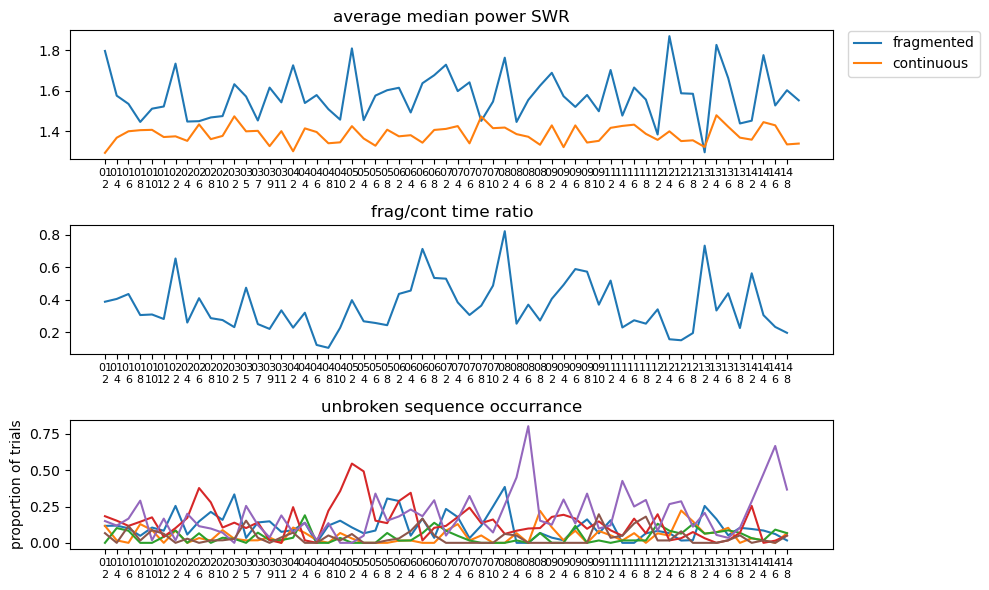

In [197]:
fig, axes = plt.subplots(3,1, figsize = (5 * len(power_frag_plot)/30, 6),sharex = True)
axes[0].plot(power_frag_plot, label = 'fragmented')
axes[0].plot(power_cont_plot, label = 'continuous')
axes[0].set_xticks(np.arange(len(label)));
axes[0].set_xticklabels(label,fontsize = 8);
axes[0].set_title('average median power SWR')
axes[0].set_ylabel('')
axes[0].legend(bbox_to_anchor=(1.01, 1.05))
axes[0].xaxis.set_tick_params(labelbottom=True)

axes[1].plot(time_frag_plot/time_cont_plot)
axes[1].set_xticks(np.arange(len(label)));
axes[1].set_xticklabels(label,fontsize = 8);
axes[1].set_title('frag/cont time ratio')
axes[1].set_ylabel('')
axes[1].xaxis.set_tick_params(labelbottom=True)

axes[2].plot(np.concatenate([occurance_rates[k] for k in occurance_rates]))
axes[2].set_xticks(np.arange(len(label)));
axes[2].set_xticklabels(label,fontsize = 8);
axes[2].xaxis.set_tick_params(labelbottom=True)
axes[2].set_title('unbroken sequence occurrance')
axes[2].set_ylabel('proportion of trials')

fig.tight_layout()

### plot by day

In [ ]:
behavior_data['occurance_rates'].shape

In [190]:
time_cont_day = [np.mean(time_cont_all[d]) for d in dates_to_plot]
time_frag_day = [np.mean(time_frag_all[d]) for d in dates_to_plot]

num_cont_day = [np.mean(num_cont_all[d]) for d in dates_to_plot]
num_frag_day = [np.mean(num_frag_all[d]) for d in dates_to_plot]

pct_cont_day = [np.sum(num_cont_all[d])/num_all[d] for d in dates_to_plot]
pct_frag_day = [np.sum(num_frag_all[d])/num_all[d] for d in dates_to_plot]

occurance_rates_day = np.concatenate([np.mean(occurance_rates[d],axis = 0).reshape((1,6)) for d in dates_to_plot])


correct_seq_occurance_day = []
pair_correct_pct_day = []
#seq_len_day = []

for d in dates_to_plot:
    tmp = [] 
    #seq_len_tmp = [] #like tmp, but for seq_len
    
    total_trial_num = 0
    
    subset_ind = np.argwhere(behavior_data['dateIntAll'] == int(d)).ravel()

    
    for n in range(len(subset_ind)):
        session_ind = subset_ind[n]
        trial_num_session = len(behavior_data['outersAll'][session_ind])
        total_trial_num += trial_num_session
        seq_types_session = behavior_data['seqtype_int'][session_ind]

        #seq_len_tmp.append(data_seqlen['mean'][session_ind] * trial_num_session)
        

        tmp.append(np.mean(behavior_data['occurance_rates'][seq_types_session-1][session_ind]) * trial_num_session)
    
    correct_seq_occurance_day.append(np.sum(tmp)/total_trial_num * 100)
    #seq_len_day.append(np.sum(seq_len_tmp)/total_trial_num)
    

pct_increase_day = 100 * np.diff(correct_seq_occurance_day)/(np.array(correct_seq_occurance_day[:-1]))
pct_increase_day = pct_increase_day[1:]
pct_increase_day[np.isnan(pct_increase_day)] = 0
pct_increase_day[np.isinf(pct_increase_day)] = 0

pairwise_day = np.concatenate([np.mean(pct_correct[d],axis = 0).reshape((1,6)) for d in dates_to_plot])



/tmp/ipykernel_497869/1096016097.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[3].legend(bbox_to_anchor=(1.01, 1.05))
/tmp/ipykernel_497869/1096016097.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[4].legend(bbox_to_anchor=(1.01, 1.05))
/tmp/ipykernel_497869/1096016097.py:51: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[5].legend(bbox_to_anchor=(1.01, 1.05))
/tmp/ipykernel_497869/1096016097.py:59: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[6].legend(bbox_

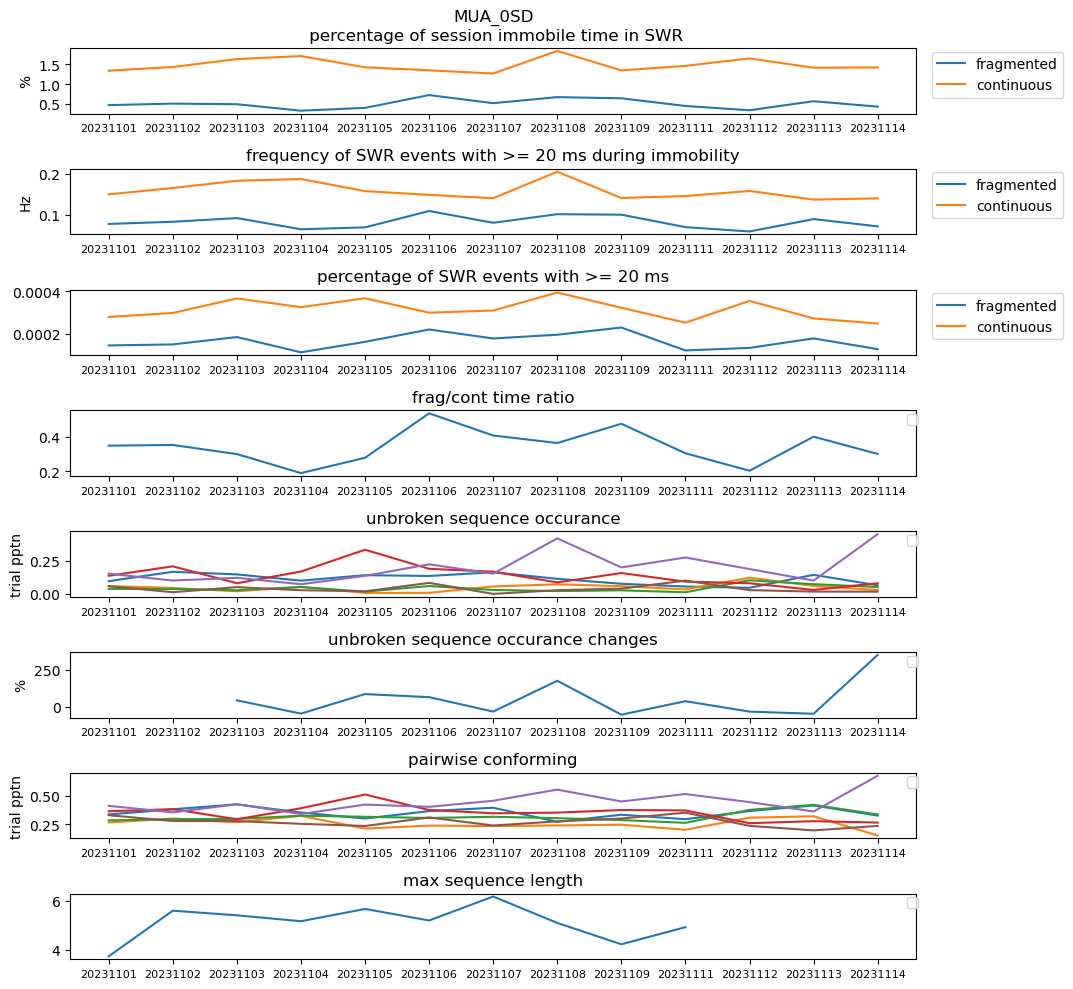

In [191]:
fig, axes = plt.subplots(8,1, figsize = (5 * len(time_frag_day)/6,10), sharex = True)
axes[0].plot(np.array(time_frag_day) * 100, label = 'fragmented')
axes[0].plot(np.array(time_cont_day) * 100, label = 'continuous')
axes[0].set_xticks(np.arange(len(dates_to_plot)));
axes[0].set_xticklabels(dates_to_plot,fontsize = 8);
axes[0].set_title(decode_threshold_method + '\n percentage of session immobile time in SWR')
axes[0].set_ylabel('%')
axes[0].legend(bbox_to_anchor=(1.01, 1.05))
axes[0].xaxis.set_tick_params(labelbottom=True)

axes[1].plot(num_frag_day, label = 'fragmented')
axes[1].plot(num_cont_day, label = 'continuous')
axes[1].set_xticks(np.arange(len(dates_to_plot)));
axes[1].set_xticklabels(dates_to_plot,fontsize = 8);
axes[1].set_title('frequency of SWR events with >= 20 ms during immobility')
axes[1].set_ylabel('Hz')
axes[1].legend(bbox_to_anchor=(1.01, 1.05))
axes[1].xaxis.set_tick_params(labelbottom=True)

axes[2].plot(pct_frag_day, label = 'fragmented')
axes[2].plot(pct_cont_day, label = 'continuous')
axes[2].set_xticks(np.arange(len(dates_to_plot)));
axes[2].set_xticklabels(dates_to_plot,fontsize = 8);
axes[2].set_title('percentage of SWR events with >= 20 ms')
axes[2].legend(bbox_to_anchor=(1.01, 1.05))
axes[2].xaxis.set_tick_params(labelbottom=True)

axes[3].plot(np.array(time_frag_day)/np.array(time_cont_day))
#axes[2].plot(pct_cont_day, label = 'continuous')
axes[3].set_xticks(np.arange(len(dates_to_plot)));
axes[3].set_xticklabels(dates_to_plot,fontsize = 8);
axes[3].set_title('frag/cont time ratio')
axes[3].legend(bbox_to_anchor=(1.01, 1.05))
axes[3].xaxis.set_tick_params(labelbottom=True)

axes[4].plot(occurance_rates_day)
#axes[2].plot(pct_cont_day, label = 'continuous')
axes[4].set_xticks(np.arange(len(dates_to_plot)));
axes[4].set_xticklabels(dates_to_plot,fontsize = 8);
axes[4].set_title('unbroken sequence occurance')
axes[4].set_ylabel('trial pptn')
axes[4].legend(bbox_to_anchor=(1.01, 1.05))
axes[4].xaxis.set_tick_params(labelbottom=True)

axes[5].plot(np.arange(len(dates_to_plot))[2:], pct_increase_day)
#axes[2].plot(pct_cont_day, label = 'continuous')
axes[5].set_xticks(np.arange(len(dates_to_plot)-2));
axes[5].set_xticklabels(dates_to_plot[2:],fontsize = 8);
axes[5].set_title('unbroken sequence occurance changes')
axes[5].set_ylabel('%')
axes[5].legend(bbox_to_anchor=(1.01, 1.05))
axes[5].xaxis.set_tick_params(labelbottom=True)

axes[6].plot(pairwise_day)
axes[6].set_xticks(np.arange(len(dates_to_plot)));
axes[6].set_xticklabels(dates_to_plot,fontsize = 8);
axes[6].set_title('pairwise conforming')
axes[6].set_ylabel('trial pptn')
axes[6].legend(bbox_to_anchor=(1.01, 1.05))
axes[6].xaxis.set_tick_params(labelbottom=True)

axes[7].plot(seq_len_day)
axes[7].set_xticks(np.arange(len(dates_to_plot)));
axes[7].set_xticklabels(dates_to_plot,fontsize = 8);
axes[7].set_title('max sequence length')
axes[7].set_ylabel('')
axes[7].legend(bbox_to_anchor=(1.01, 1.05))
axes[7].xaxis.set_tick_params(labelbottom=True)

fig.tight_layout()

### ripple power by day

In [195]:
power_cont_day = [np.nanmean(np.concatenate(power_cont_all[d])) for d in dates_to_plot]
power_frag_day = [np.nanmean(np.concatenate(power_frag_all[d])) for d in dates_to_plot]

/tmp/ipykernel_497869/2564253882.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend(bbox_to_anchor=(1.01, 1.05))


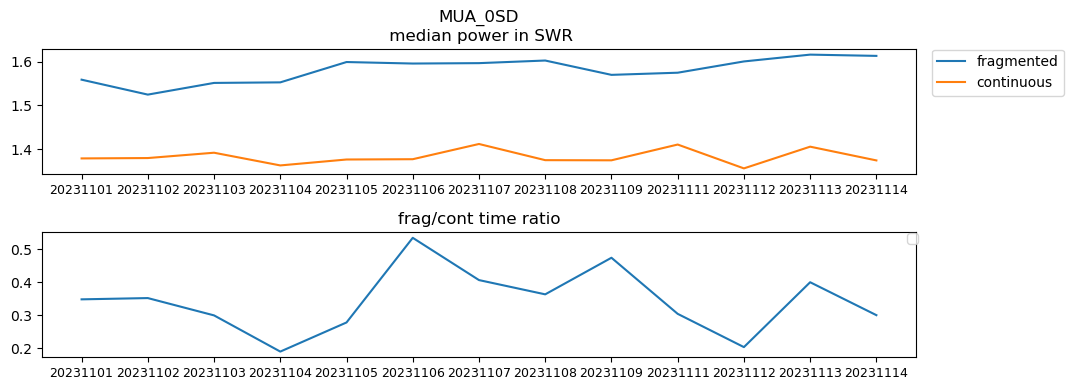

In [199]:
fig, axes = plt.subplots(2,1, figsize = (5 * len(time_frag_day)/6,4), sharex = True)
axes[0].plot(power_frag_day, label = 'fragmented')
axes[0].plot(power_cont_day, label = 'continuous')
axes[0].set_xticks(np.arange(len(dates_to_plot)));
axes[0].set_xticklabels(dates_to_plot,fontsize = 9);
axes[0].set_title(decode_threshold_method + '\n median power in SWR')
axes[0].set_ylabel('')
axes[0].legend(bbox_to_anchor=(1.01, 1.05))
axes[0].xaxis.set_tick_params(labelbottom=True)


axes[1].plot(np.array(time_frag_day)/np.array(time_cont_day))
#axes[2].plot(pct_cont_day, label = 'continuous')
axes[1].set_xticks(np.arange(len(dates_to_plot)));
axes[1].set_xticklabels(dates_to_plot,fontsize = 9);
axes[1].set_title('frag/cont time ratio')
axes[1].legend(bbox_to_anchor=(1.01, 1.05))
axes[1].xaxis.set_tick_params(labelbottom=True)

fig.tight_layout()

### Below are the same notebook as (Offline Ripple Analysis) 4. PairwiseBehaviorAndReplay 

In [57]:
encoding_set = '2Dheadspeed_above_4_andlowmua'
classifier_param_name = 'default_decoding_gpu_4armMaze'

count, P_replay_all = replay_transitions(animal,dates_to_plot,encoding_set,classifier_param_name)
P_behavior_all,xcorr_plot,xcorr25_plot,xcorr975_plot = behavior_transitions(animal,dates_to_plot)
C_behavior_all, C_behavior_reward_all = behavior_transitions_count(animal,dates_to_plot)

02_Seq2Session1


DataJointError: fetch1 should only return one tuple. 0 tuples found

#### 1. Row normalized (conditional probablity)

[Text(1, 0.1, '0.1'),
 Text(1, 0.2, '0.2'),
 Text(1, 0.3, '0.3'),
 Text(1, 0.4, '0.4'),
 Text(1, 0.5, '0.5'),
 Text(1, 0.8, '0.8')]

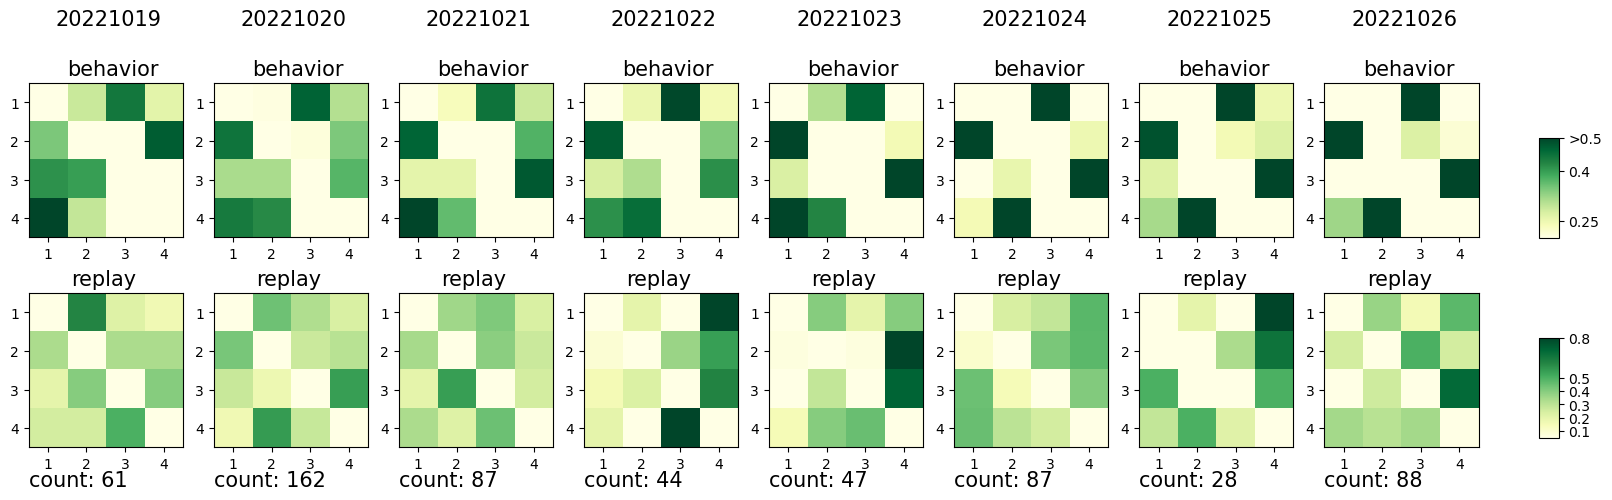

In [305]:
version = 1
fig,axes = plt.subplots(2,len(dates_to_plot),figsize = (20,5))

REPLAY_VMAX = 0.8
for d_ind in range(len(dates_to_plot)):
    d = dates_to_plot[d_ind]
    behavior_data = P_behavior_all[d]
    #axes[0,d_ind].imshow(behavior_data, vmax = np.nanquantile(behavior_data,0.9), origin = 'upper')
    im1 = axes[0,d_ind].imshow(behavior_data, vmin = 0.2, vmax = 0.5, origin = 'upper',cmap = 'YlGn')

    replay_data = P_replay_all[d][version]
    replay_count = 'count: ' + str(int(count[d]))
    im2 = axes[1,d_ind].imshow(replay_data, vmin = 0.05, vmax = REPLAY_VMAX, origin = 'upper',cmap = 'YlGn')
    #axes[1,d_ind].imshow(replay_data, vmax = np.nanquantile(replay_data,0.9), origin = 'upper')
    axes[1,d_ind].text(0.6,-0.7,'replay',fontsize = 15)
    axes[1,d_ind].text(-0.5,4.5,replay_count,fontsize = 15)

    
    # label arms
    for ai in [0,1]:
        axes[ai,d_ind].set_xticks(np.arange(4))
        axes[ai,d_ind].set_yticks(np.arange(4))
        axes[ai,d_ind].set_xticklabels(['1','2','3','4'])
        axes[ai,d_ind].set_yticklabels(['1','2','3','4'])

    axes[0,d_ind].text(0.2,-2,d,fontsize = 15)
    axes[0,d_ind].text(0.5,-0.7,'behavior',fontsize = 15)

# add space for colour bar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.55, 0.01, 0.2])
fig.colorbar(im1, cax=cbar_ax,ticks=[0.1, 0.25, 0.4, 0.5])
cbar_ax.set_yticklabels(['<0.2', '0.25', '0.4', '>0.5'])  # vertically oriented colorbar

cbar_ax = fig.add_axes([0.88, 0.15, 0.01, 0.2])
fig.colorbar(im2, cax=cbar_ax,ticks=[0.1, 0.2, 0.3, 0.4, 0.5, REPLAY_VMAX])
cbar_ax.set_yticklabels(['0.1', '0.2', '0.3', '0.4', '0.5', str(REPLAY_VMAX)])  # vertically oriented colorbar

#### 2. Count

[Text(1, 0.1, '0.1'),
 Text(1, 0.2, '0.2'),
 Text(1, 0.3, '0.3'),
 Text(1, 0.4, '0.4'),
 Text(1, 0.5, '0.5'),
 Text(1, 25.0, '>25')]

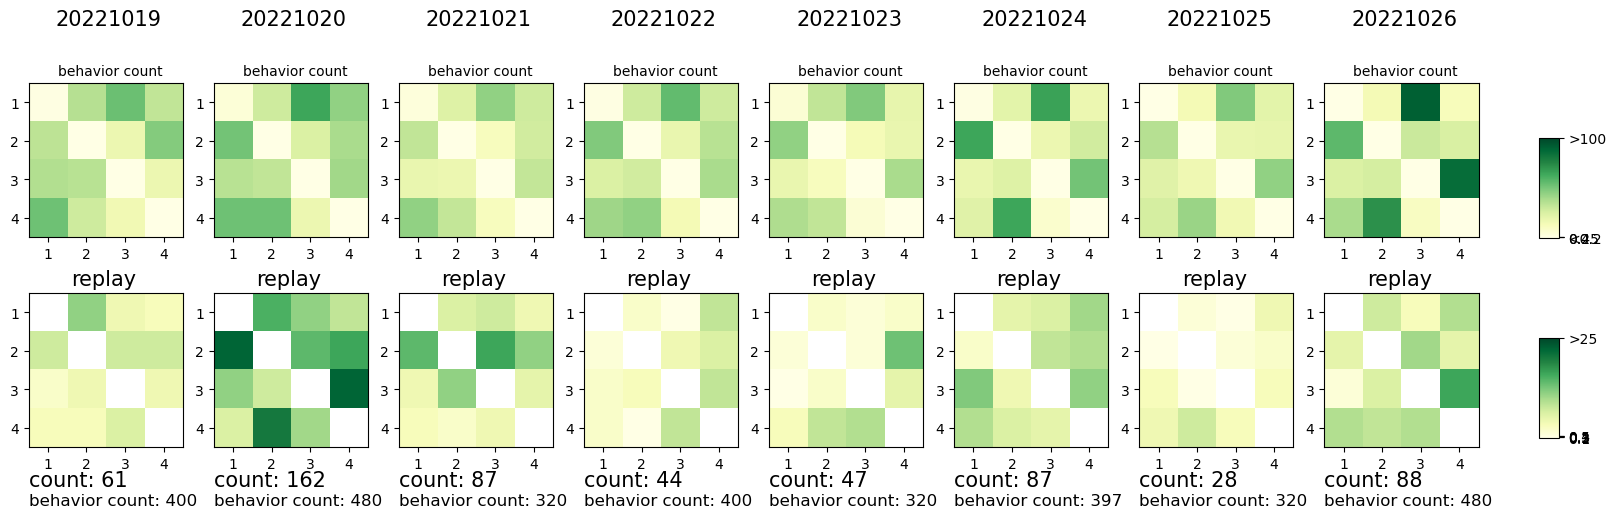

In [411]:
version = 0
fig,axes = plt.subplots(2,len(dates_to_plot),figsize = (20,5))

REPLAY_VMAX = 25
BEHAVIOR_VMAX = 100 #0.25
for d_ind in range(len(dates_to_plot)):
    d = dates_to_plot[d_ind]
    behavior_data = C_behavior_all[d]#/np.sum(C_behavior_all[d])
    #axes[0,d_ind].imshow(behavior_data, vmax = np.nanquantile(behavior_data,0.9), origin = 'upper')
    im1 = axes[0,d_ind].imshow(behavior_data, vmin = 0, vmax = BEHAVIOR_VMAX, origin = 'upper',cmap = 'YlGn')

    replay_data = P_replay_all[d][version]
    replay_count = 'count: ' + str(int(count[d]))
    im2 = axes[1,d_ind].imshow(replay_data, vmin = 0, vmax = REPLAY_VMAX, origin = 'upper',cmap = 'YlGn')
    #axes[1,d_ind].imshow(replay_data, vmax = np.nanquantile(replay_data,0.9), origin = 'upper')
    axes[1,d_ind].text(0.6,-0.7,'replay',fontsize = 15)
    axes[1,d_ind].text(-0.5,4.5,replay_count,fontsize = 15)
    behavior_count = 'behavior count: ' + str(int(np.sum(behavior_data)))
    axes[1,d_ind].text(-0.5,5,behavior_count,fontsize = 12)

    
    # label arms
    for ai in [0,1]:
        axes[ai,d_ind].set_xticks(np.arange(4))
        axes[ai,d_ind].set_yticks(np.arange(4))
        axes[ai,d_ind].set_xticklabels(['1','2','3','4'])
        axes[ai,d_ind].set_yticklabels(['1','2','3','4'])

    axes[0,d_ind].text(0.2,-2,d,fontsize = 15)
    axes[0,d_ind].text(0.25,-0.7,'behavior count',fontsize = 10)

# add space for colour bar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.55, 0.01, 0.2])
fig.colorbar(im1, cax=cbar_ax,ticks=[0.1, 0.25, 0.4, BEHAVIOR_VMAX])
cbar_ax.set_yticklabels(['<0.2', '0.25', '0.4', '>'+str(BEHAVIOR_VMAX)])  # vertically oriented colorbar

cbar_ax = fig.add_axes([0.88, 0.15, 0.01, 0.2])
fig.colorbar(im2, cax=cbar_ax,ticks=[0.1, 0.2, 0.3, 0.4, 0.5, REPLAY_VMAX])
cbar_ax.set_yticklabels(['0.1', '0.2', '0.3', '0.4', '0.5', '>'+str(REPLAY_VMAX)])  # vertically oriented colorbar


#### 3. Rewarded Transition Behavior Count

[Text(1, 0.1, '0.1'),
 Text(1, 0.2, '0.2'),
 Text(1, 0.3, '0.3'),
 Text(1, 0.4, '0.4'),
 Text(1, 0.5, '0.5'),
 Text(1, 25.0, '>25')]

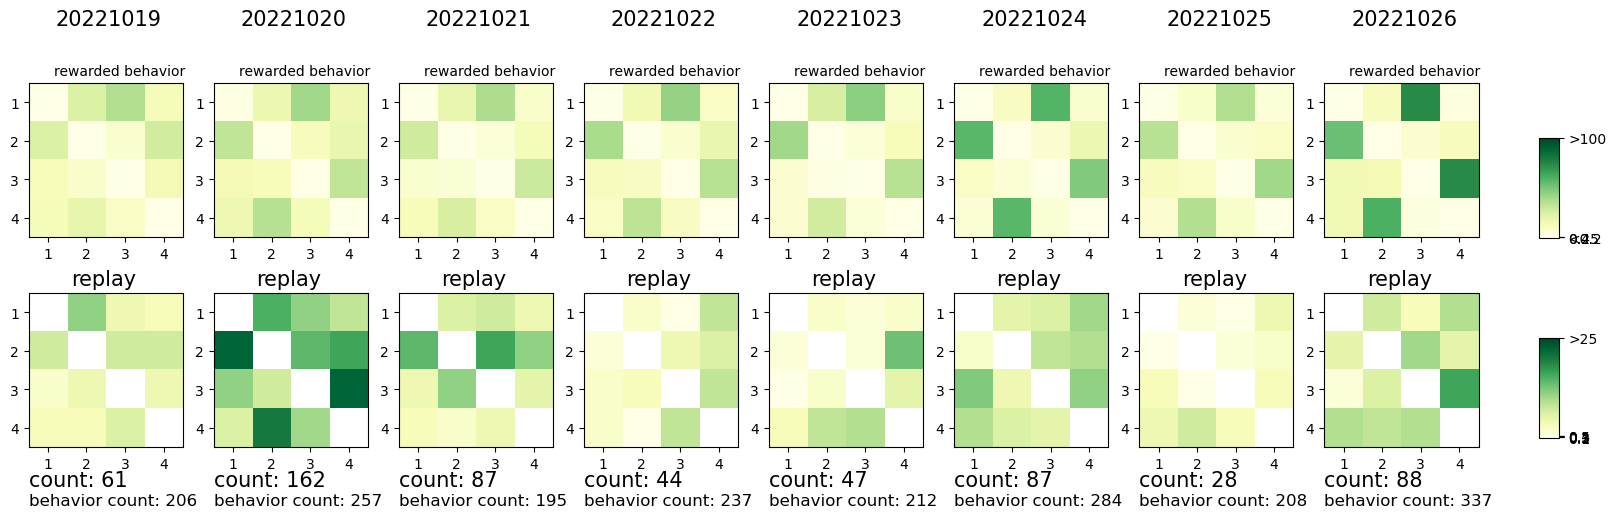

In [441]:
version = 0
fig,axes = plt.subplots(2,len(dates_to_plot),figsize = (20,5))

REPLAY_VMAX = 25
BEHAVIOR_VMAX = 100 #0.25
for d_ind in range(len(dates_to_plot)):
    d = dates_to_plot[d_ind]
    behavior_data = C_behavior_reward_all[d]#/np.sum(C_behavior_all[d])
    #axes[0,d_ind].imshow(behavior_data, vmax = np.nanquantile(behavior_data,0.9), origin = 'upper')
    im1 = axes[0,d_ind].imshow(behavior_data, vmin = 0, vmax = BEHAVIOR_VMAX, origin = 'upper',cmap = 'YlGn')

    replay_data = P_replay_all[d][version]
    replay_count = 'count: ' + str(int(count[d]))
    im2 = axes[1,d_ind].imshow(replay_data, vmin = 0, vmax = REPLAY_VMAX, origin = 'upper',cmap = 'YlGn')
    #axes[1,d_ind].imshow(replay_data, vmax = np.nanquantile(replay_data,0.9), origin = 'upper')
    axes[1,d_ind].text(0.6,-0.7,'replay',fontsize = 15)
    
    axes[1,d_ind].text(-0.5,4.5,replay_count,fontsize = 15)
    behavior_count = 'behavior count: ' + str(int(np.sum(behavior_data)))
    axes[1,d_ind].text(-0.5,5,behavior_count,fontsize = 12)
    
    # label arms
    for ai in [0,1]:
        axes[ai,d_ind].set_xticks(np.arange(4))
        axes[ai,d_ind].set_yticks(np.arange(4))
        axes[ai,d_ind].set_xticklabels(['1','2','3','4'])
        axes[ai,d_ind].set_yticklabels(['1','2','3','4'])

    axes[0,d_ind].text(0.2,-2,d,fontsize = 15)
    axes[0,d_ind].text(0.15,-0.7,'rewarded behavior',fontsize = 10)


# add space for colour bar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.55, 0.01, 0.2])
fig.colorbar(im1, cax=cbar_ax,ticks=[0.1, 0.25, 0.4, BEHAVIOR_VMAX])
cbar_ax.set_yticklabels(['<0.2', '0.25', '0.4', '>'+str(BEHAVIOR_VMAX)])  # vertically oriented colorbar

cbar_ax = fig.add_axes([0.88, 0.15, 0.01, 0.2])
fig.colorbar(im2, cax=cbar_ax,ticks=[0.1, 0.2, 0.3, 0.4, 0.5, REPLAY_VMAX])
cbar_ax.set_yticklabels(['0.1', '0.2', '0.3', '0.4', '0.5', '>'+str(REPLAY_VMAX)])  # vertically oriented colorbar


#### 4. delta reward

[Text(1, 0.1, '0.1'),
 Text(1, 0.2, '>0.2'),
 Text(1, 0.3, '0.3'),
 Text(1, 0.4, '0.4'),
 Text(1, 0.5, '0.5'),
 Text(1, 0.2, '>0.2')]

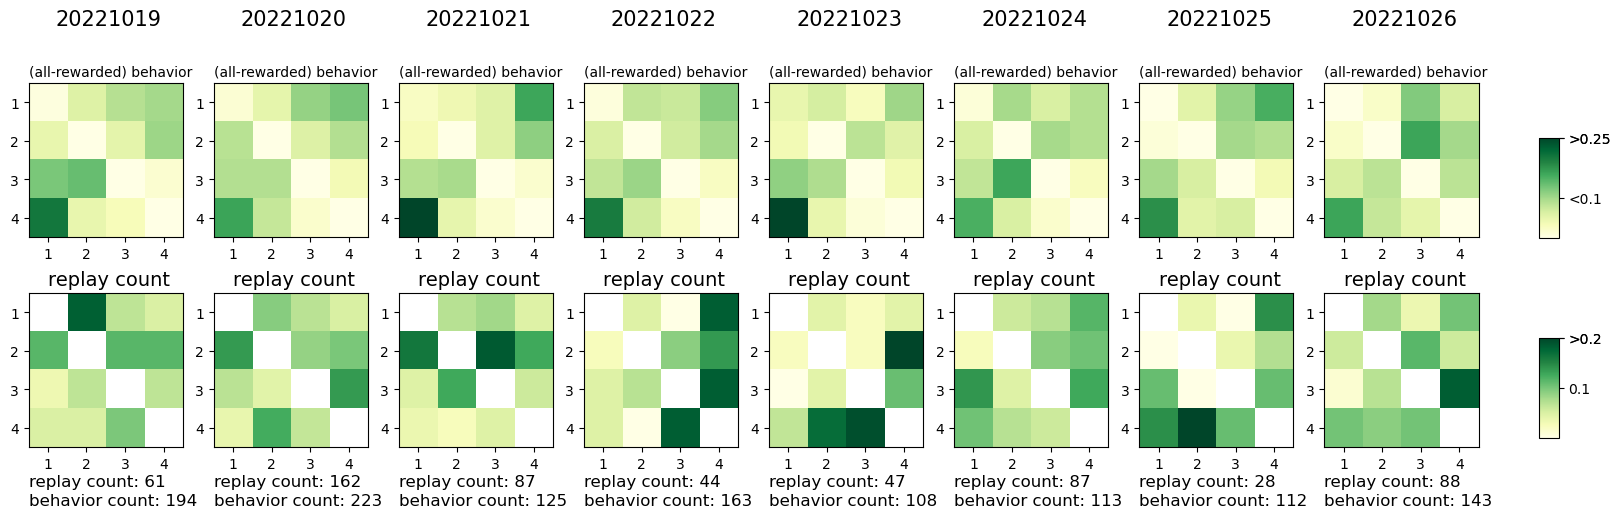

In [440]:
version = 0
normalize = 1
fig,axes = plt.subplots(2,len(dates_to_plot),figsize = (20,5))

if normalize:
    REPLAY_VMAX = 0.2
    BEHAVIOR_VMAX = 0.25
else:
    REPLAY_VMAX = 20
    BEHAVIOR_VMAX = 40 #0.25
for d_ind in range(len(dates_to_plot)):
    d = dates_to_plot[d_ind]
    d_minus1 = dates_to_plot[d_ind-1]
    behavior_data = (C_behavior_all[d]-C_behavior_reward_all[d])#/np.sum(C_behavior_all[d])
    if normalize:
        behavior_data_plot = behavior_data/np.sum(behavior_data)
        im1 = axes[0,d_ind].imshow(behavior_data_plot, vmin = 0, vmax = BEHAVIOR_VMAX, origin = 'upper',cmap = 'YlGn')
    else:
        im1 = axes[0,d_ind].imshow(behavior_data, vmin = 0, vmax = BEHAVIOR_VMAX, origin = 'upper',cmap = 'YlGn')

    replay_data = P_replay_all[d][version]
    replay_count = 'replay count: ' + str(int(count[d]))
    if normalize:
        replay_data = replay_data/np.nansum(replay_data)
        im2 = axes[1,d_ind].imshow(replay_data, vmin = 0, vmax = REPLAY_VMAX, origin = 'upper',cmap = 'YlGn')
    else:
        im2 = axes[1,d_ind].imshow(replay_data, vmin = 0, vmax = REPLAY_VMAX, origin = 'upper',cmap = 'YlGn')
    #axes[1,d_ind].imshow(replay_data, vmax = np.nanquantile(replay_data,0.9), origin = 'upper')
    axes[1,d_ind].text(0,-0.7,'replay count',fontsize = 14)
    axes[1,d_ind].text(-0.5,4.5,replay_count,fontsize = 12)
    behavior_count = 'behavior count: ' + str(int(np.sum(behavior_data)))
    axes[1,d_ind].text(-0.5,5,behavior_count,fontsize = 12)
    
    # label arms
    for ai in [0,1]:
        axes[ai,d_ind].set_xticks(np.arange(4))
        axes[ai,d_ind].set_yticks(np.arange(4))
        axes[ai,d_ind].set_xticklabels(['1','2','3','4'])
        axes[ai,d_ind].set_yticklabels(['1','2','3','4'])

    axes[0,d_ind].text(0.2,-2,d,fontsize = 15)
    axes[0,d_ind].text(-0.5,-0.7,'(all-rewarded) behavior',fontsize = 10)

# add space for colour bar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.55, 0.01, 0.2])
fig.colorbar(im1, cax=cbar_ax,ticks=[0.1, 0.25, 0.4, BEHAVIOR_VMAX])
cbar_ax.set_yticklabels(['<0.1', '0.25', '0.4', '>'+str(BEHAVIOR_VMAX)])  # vertically oriented colorbar

cbar_ax = fig.add_axes([0.88, 0.15, 0.01, 0.2])
fig.colorbar(im2, cax=cbar_ax,ticks=[0.1, 0.2, 0.3, 0.4, 0.5, REPLAY_VMAX])
cbar_ax.set_yticklabels(['0.1', '0.2', '0.3', '0.4', '0.5', '>'+str(REPLAY_VMAX)])  # vertically oriented colorbar


#### 5. Trial-by-trial analysis

In [854]:
from spyglass.shijiegu.pairwiseDecode import trial_by_trial_behavior_replay_pairs,trial_by_trial_random_behavior_replay_pairs

LOOK_BACK_NUM = 2
(p_replay_reward, count_reward, 
 p_transition_reward, count_transition_reward) = trial_by_trial_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                             classifier_param_name,LOOK_BACK_NUM,'normal','PAST_REWARD')
(p_replay_reward_reward, count_reward_reward,
 p_transition_reward_reward, count_transition_reward_reward) = trial_by_trial_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                             classifier_param_name,LOOK_BACK_NUM,'normal','REWARD_REWARD')
(p_replay_nonreward, count_nonreward,
 p_transition_nonreward, count_transition_nonreward) = trial_by_trial_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                             classifier_param_name,LOOK_BACK_NUM,'normal','NONREWARD')
(p_replay_all, count_all,
 p_transition_all, count_transition_all) = trial_by_trial_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                             classifier_param_name,LOOK_BACK_NUM,'normal','PAST')
(p_replay_fu, count_fu,
 p_transition_fu, count_transition_fu) = trial_by_trial_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                                classifier_param_name,LOOK_BACK_NUM,'normal','FUTURE')

(p_replay_reward_r, count_reward_r,
  p_transition_reward_r, count_transition_reward_r) = trial_by_trial_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                             classifier_param_name,LOOK_BACK_NUM,'reverse','PAST_REWARD')
(p_replay_reward_reward_r, count_reward_reward_r,
 p_transition_reward_reward_r, count_transition_reward_reward_r) = trial_by_trial_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                             classifier_param_name,LOOK_BACK_NUM,'reverse','REWARD_REWARD')
(p_replay_nonreward_r, count_nonreward_r,
 p_transition_nonreward_r, count_transition_nonreward_r) = trial_by_trial_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                             classifier_param_name,LOOK_BACK_NUM,'reverse','NONREWARD')
(p_replay_all_r, count_all_r,
 p_transition_all_r, count_transition_all_r) = trial_by_trial_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                             classifier_param_name,LOOK_BACK_NUM,'reverse','PAST')
(p_replay_fu_r, count_fu_r,
 p_transition_fu_r, count_transition_fu_r) = trial_by_trial_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                                classifier_param_name,LOOK_BACK_NUM,'reverse','FUTURE')

In [ ]:
LOOK_BACK_NUM = 2
(p_replay_random_mean, p_replay_random_25, p_replay_random_975,
            p_transition_random_mean, p_transition_random_25, p_transition_random_975) = trial_by_trial_random_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                                classifier_param_name,LOOK_BACK_NUM,'reverse','RANDOM')

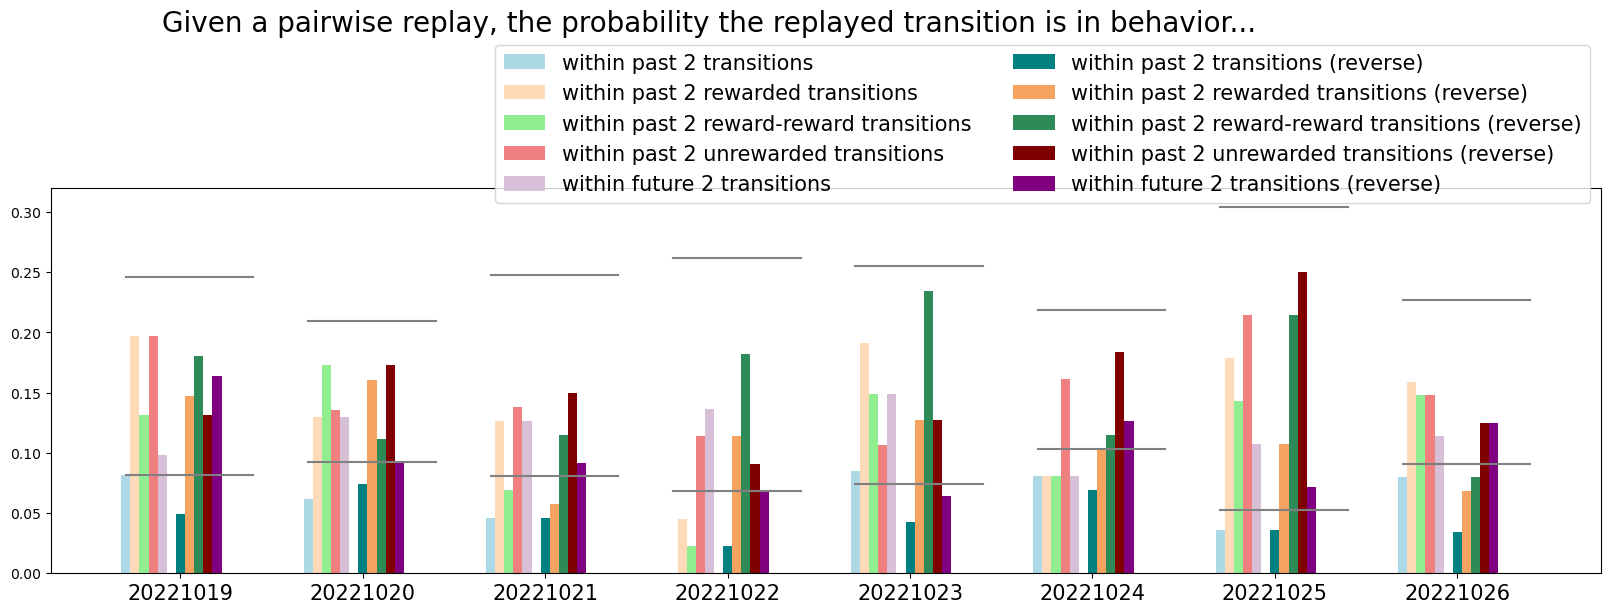

In [868]:
fig,axes = plt.subplots(1,1,figsize = (20,5))
WIDTH = 0.05
for i in range(len(dates_to_plot)):
    d = dates_to_plot[i]
    if i == 0:
        axes.bar(i,p_replay_all[d],color = 'lightblue',width = WIDTH,label = f'within past {LOOK_BACK_NUM} transitions')
        axes.bar(i+WIDTH,p_replay_reward[d],color = 'peachpuff',width = WIDTH,label = f'within past {LOOK_BACK_NUM} rewarded transitions')
        axes.bar(i+2*WIDTH,p_replay_reward_reward[d],color = 'lightgreen',width = WIDTH,label = f'within past {LOOK_BACK_NUM} reward-reward transitions')
        axes.bar(i+3*WIDTH,p_replay_nonreward[d],color = 'lightcoral',width = WIDTH,label = f'within past {LOOK_BACK_NUM} unrewarded transitions')
        axes.bar(i+4*WIDTH,p_replay_fu[d],color = 'thistle',width = WIDTH,label = f'within future {LOOK_BACK_NUM} transitions')
    else:
        axes.bar(i,p_replay_all[d],color = 'lightblue',width = WIDTH)
        axes.bar(i+WIDTH,p_replay_reward[d],color = 'peachpuff',width = WIDTH)
        axes.bar(i+2*WIDTH,p_replay_reward_reward[d],color = 'lightgreen',width = WIDTH)
        axes.bar(i+3*WIDTH,p_replay_nonreward[d],color = 'lightcoral',width = WIDTH)
        axes.bar(i+4*WIDTH,p_replay_fu[d],color = 'thistle',width = WIDTH)
        
    axes.plot([i, i+0.7],[p_replay_random_25[d],p_replay_random_25[d]],color = 'grey')
    axes.plot([i, i+0.7],[p_replay_random_975[d],p_replay_random_975[d]],color = 'grey')
    
axes.legend(loc='upper right', ncols=3,fontsize = 15,bbox_to_anchor=(1, 1.2))

axes.set_xticks(np.arange(len(dates_to_plot))+0.3)
axes.set_xticklabels(dates_to_plot,fontsize = 15)


"""reverse analysis"""
for i in range(len(dates_to_plot)):
    d = dates_to_plot[i]
    if i == 0:
        axes.bar(i+6*WIDTH,p_replay_all_r[d],color = 'teal',width = WIDTH,label = f'within past {LOOK_BACK_NUM} transitions (reverse)')
        axes.bar(i+7*WIDTH,p_replay_reward_r[d],color = 'sandybrown',width = WIDTH,label = f'within past {LOOK_BACK_NUM} rewarded transitions (reverse)')
        axes.bar(i+8*WIDTH,p_replay_reward_reward_r[d],color = 'seagreen',width = WIDTH,label = f'within past {LOOK_BACK_NUM} reward-reward transitions (reverse)')
        axes.bar(i+9*WIDTH,p_replay_nonreward_r[d],color = 'maroon',width = WIDTH,label = f'within past {LOOK_BACK_NUM} unrewarded transitions (reverse)')
        axes.bar(i+10*WIDTH,p_replay_fu_r[d],color = 'purple',width = WIDTH,label = f'within future {LOOK_BACK_NUM} transitions (reverse)')
    else:
        axes.bar(i+6*WIDTH,p_replay_all_r[d],color = 'teal',width = WIDTH)
        axes.bar(i+7*WIDTH,p_replay_reward_r[d],color = 'sandybrown',width = WIDTH)
        axes.bar(i+8*WIDTH,p_replay_reward_reward_r[d],color = 'seagreen',width = WIDTH)
        axes.bar(i+9*WIDTH,p_replay_nonreward_r[d],color = 'maroon',width = WIDTH)
        axes.bar(i+10*WIDTH,p_replay_fu_r[d],color = 'purple',width = WIDTH)

axes.text(0.2,0.45,'Given a pairwise replay, the probability the replayed transition is in behavior...',fontsize = 20);
axes.legend(loc='upper right', ncols=2,fontsize = 15,bbox_to_anchor=(1, 1.4))

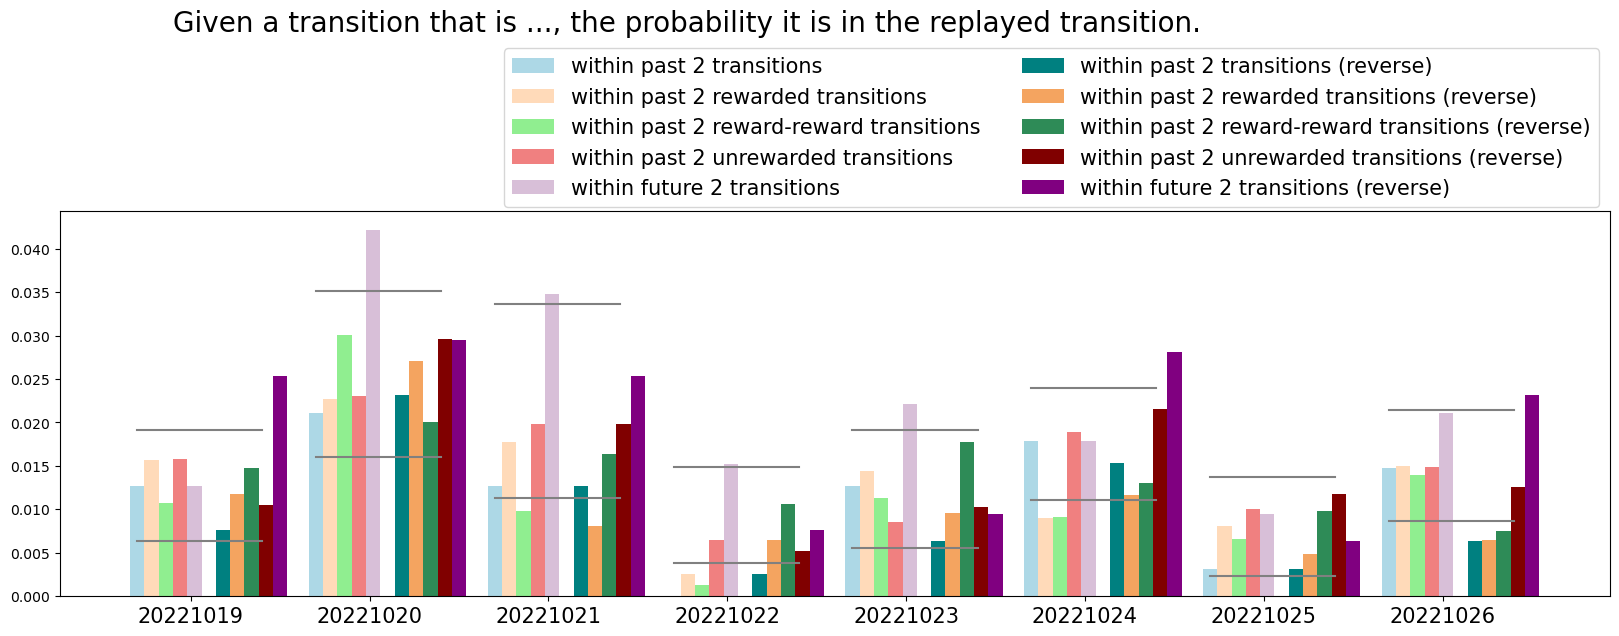

In [875]:
fig,axes = plt.subplots(1,1,figsize = (20,5))
WIDTH = 0.08
for i in range(len(dates_to_plot)):
    d = dates_to_plot[i]
    if i == 0:
        axes.bar(i,p_transition_all[d],color = 'lightblue',width = WIDTH,label = f'within past {LOOK_BACK_NUM} transitions')
        axes.bar(i+WIDTH,p_transition_reward[d],color = 'peachpuff',width = WIDTH,label = f'within past {LOOK_BACK_NUM} rewarded transitions')
        axes.bar(i+2*WIDTH,p_transition_reward_reward[d],color = 'lightgreen',width = WIDTH,label = f'within past {LOOK_BACK_NUM} reward-reward transitions')
        axes.bar(i+3*WIDTH,p_transition_nonreward[d],color = 'lightcoral',width = WIDTH,label = f'within past {LOOK_BACK_NUM} unrewarded transitions')
        axes.bar(i+4*WIDTH,p_transition_fu[d],color = 'thistle',width = WIDTH,label = f'within future {LOOK_BACK_NUM} transitions')
    else:
        axes.bar(i,p_transition_all[d],color = 'lightblue',width = WIDTH)
        axes.bar(i+WIDTH,p_transition_reward[d],color = 'peachpuff',width = WIDTH)
        axes.bar(i+2*WIDTH,p_transition_reward_reward[d],color = 'lightgreen',width = WIDTH)
        axes.bar(i+3*WIDTH,p_transition_nonreward[d],color = 'lightcoral',width = WIDTH)
        axes.bar(i+4*WIDTH,p_transition_fu[d],color = 'thistle',width = WIDTH)
        
    axes.plot([i, i+0.7],[p_transition_random_25[d],p_transition_random_25[d]],color = 'grey')
    axes.plot([i, i+0.7],[p_transition_random_975[d],p_transition_random_975[d]],color = 'grey')
    
axes.legend(loc='upper right', ncols=3,fontsize = 15,bbox_to_anchor=(1, 1.2))

axes.set_xticks(np.arange(len(dates_to_plot))+0.3)
axes.set_xticklabels(dates_to_plot,fontsize = 15)


"""reverse analysis"""
for i in range(len(dates_to_plot)):
    d = dates_to_plot[i]
    if i == 0:
        axes.bar(i+6*WIDTH,p_transition_all_r[d],color = 'teal',width = WIDTH,label = f'within past {LOOK_BACK_NUM} transitions (reverse)')
        axes.bar(i+7*WIDTH,p_transition_reward_r[d],color = 'sandybrown',width = WIDTH,label = f'within past {LOOK_BACK_NUM} rewarded transitions (reverse)')
        axes.bar(i+8*WIDTH,p_transition_reward_reward_r[d],color = 'seagreen',width = WIDTH,label = f'within past {LOOK_BACK_NUM} reward-reward transitions (reverse)')
        axes.bar(i+9*WIDTH,p_transition_nonreward_r[d],color = 'maroon',width = WIDTH,label = f'within past {LOOK_BACK_NUM} unrewarded transitions (reverse)')
        axes.bar(i+10*WIDTH,p_transition_fu_r[d],color = 'purple',width = WIDTH,label = f'within future {LOOK_BACK_NUM} transitions (reverse)')
    else:
        axes.bar(i+6*WIDTH,p_transition_all_r[d],color = 'teal',width = WIDTH)
        axes.bar(i+7*WIDTH,p_transition_reward_r[d],color = 'sandybrown',width = WIDTH)
        axes.bar(i+8*WIDTH,p_transition_reward_reward_r[d],color = 'seagreen',width = WIDTH)
        axes.bar(i+9*WIDTH,p_transition_nonreward_r[d],color = 'maroon',width = WIDTH)
        axes.bar(i+10*WIDTH,p_transition_fu_r[d],color = 'purple',width = WIDTH)

axes.text(0.2,0.065,'Given a transition that is ..., the probability it is in the replayed transition.',fontsize = 20);
axes.legend(loc='upper right', ncols=2,fontsize = 15,bbox_to_anchor=(1, 1.45))

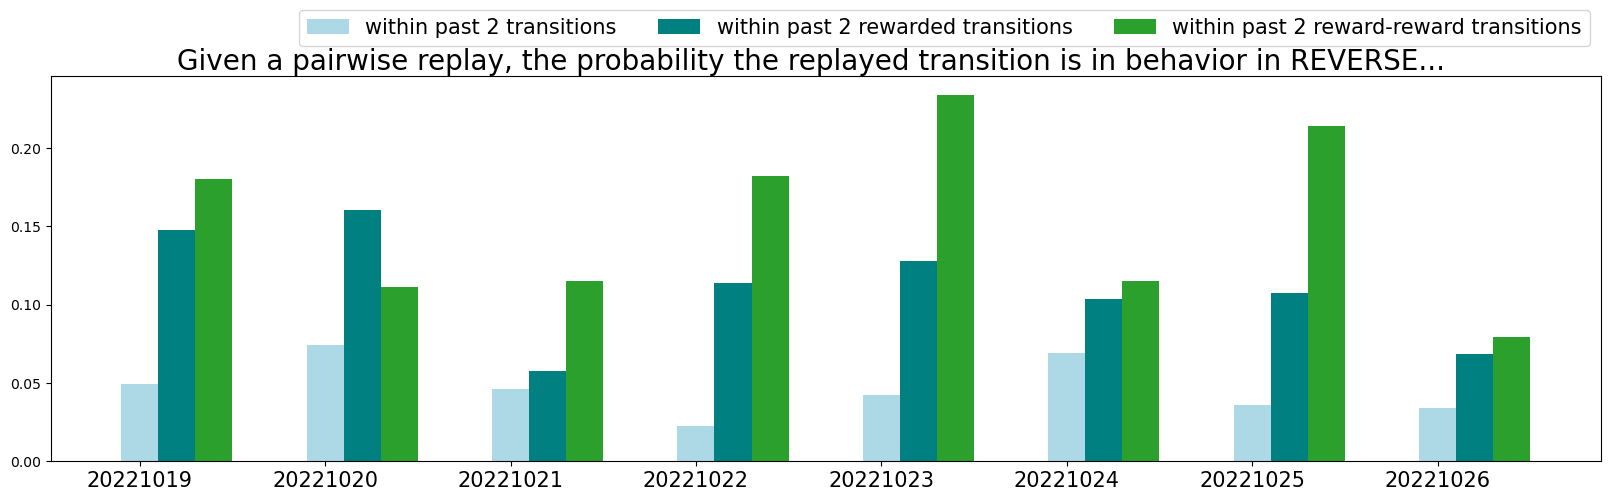

In [683]:
### In the case of just wanting one set
fig,axes = plt.subplots(1,1,figsize = (20,5))
for i in range(len(dates_to_plot)):
    d = dates_to_plot[i]
    if i == 0:
        axes.bar(i,p_replay_all[d],color = 'lightblue',width = 0.2,label = f'within past {LOOK_BACK_NUM} transitions')
        axes.bar(i+0.2,p_replay_reward[d],color = 'teal',width = 0.2,label = f'within past {LOOK_BACK_NUM} rewarded transitions')
        axes.bar(i+0.4,p_replay_reward_reward[d],color = 'C2',width = 0.2,label = f'within past {LOOK_BACK_NUM} reward-reward transitions')
    else:
        axes.bar(i,p_replay_all[d],color = 'lightblue',width = 0.2)
        axes.bar(i+0.2,p_replay_reward[d],color = 'teal',width = 0.2)
        axes.bar(i+0.4,p_replay_reward_reward[d],color = 'C2',width = 0.2)
axes.legend(loc='upper right', ncols=3,fontsize = 15,bbox_to_anchor=(1, 1.2))

axes.set_xticks(np.arange(len(dates_to_plot)))
axes.set_xticklabels(dates_to_plot,fontsize = 15)
axes.text(0.2,axes.get_ylim()[1] + 0.1,'Given a pairwise replay, the probability the replayed transition is in behavior...',fontsize = 20);

In [878]:
LOOK_BACK_NUM = 1
(p_replay_reward, count_reward, 
 p_transition_reward, count_transition_reward) = trial_by_trial_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                             classifier_param_name,LOOK_BACK_NUM,'normal','PAST_REWARD')
(p_replay_reward_reward, count_reward_reward,
 p_transition_reward_reward, count_transition_reward_reward) = trial_by_trial_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                             classifier_param_name,LOOK_BACK_NUM,'normal','REWARD_REWARD')
(p_replay_nonreward, count_nonreward,
 p_transition_nonreward, count_transition_nonreward) = trial_by_trial_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                             classifier_param_name,LOOK_BACK_NUM,'normal','NONREWARD')
(p_replay_all, count_all,
 p_transition_all, count_transition_all) = trial_by_trial_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                             classifier_param_name,LOOK_BACK_NUM,'normal','PAST')
(p_replay_fu, count_fu,
 p_transition_fu, count_transition_fu) = trial_by_trial_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                                classifier_param_name,LOOK_BACK_NUM,'normal','FUTURE')

(p_replay_reward_r, count_reward_r,
  p_transition_reward_r, count_transition_reward_r) = trial_by_trial_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                             classifier_param_name,LOOK_BACK_NUM,'reverse','PAST_REWARD')
(p_replay_reward_reward_r, count_reward_reward_r,
 p_transition_reward_reward_r, count_transition_reward_reward_r) = trial_by_trial_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                             classifier_param_name,LOOK_BACK_NUM,'reverse','REWARD_REWARD')
(p_replay_nonreward_r, count_nonreward_r,
 p_transition_nonreward_r, count_transition_nonreward_r) = trial_by_trial_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                             classifier_param_name,LOOK_BACK_NUM,'reverse','NONREWARD')
(p_replay_all_r, count_all_r,
 p_transition_all_r, count_transition_all_r) = trial_by_trial_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                             classifier_param_name,LOOK_BACK_NUM,'reverse','PAST')
(p_replay_fu_r, count_fu_r,
 p_transition_fu_r, count_transition_fu_r) = trial_by_trial_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                                classifier_param_name,LOOK_BACK_NUM,'reverse','FUTURE')

In [879]:
LOOK_BACK_NUM = 1
(p_replay_random_mean, p_replay_random_25, p_replay_random_975,
            p_transition_random_mean, p_transition_random_25, p_transition_random_975) = trial_by_trial_random_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                                classifier_param_name,LOOK_BACK_NUM,'reverse','RANDOM')

working on bootstrap iteration: 0
working on bootstrap iteration: 1
working on bootstrap iteration: 2
working on bootstrap iteration: 3
working on bootstrap iteration: 4
working on bootstrap iteration: 5
working on bootstrap iteration: 6
working on bootstrap iteration: 7
working on bootstrap iteration: 8
working on bootstrap iteration: 9
working on bootstrap iteration: 10
working on bootstrap iteration: 11
working on bootstrap iteration: 12
working on bootstrap iteration: 13
working on bootstrap iteration: 14
working on bootstrap iteration: 15
working on bootstrap iteration: 16
working on bootstrap iteration: 17
working on bootstrap iteration: 18
working on bootstrap iteration: 19
working on bootstrap iteration: 20
working on bootstrap iteration: 21
working on bootstrap iteration: 22
working on bootstrap iteration: 23
working on bootstrap iteration: 24
working on bootstrap iteration: 25
working on bootstrap iteration: 26
working on bootstrap iteration: 27
working on bootstrap iteration

In [877]:
%debug

> /home/shijiegu/Documents/spyglass/src/spyglass/shijiegu/pairwiseDecode.py(324)trial_by_trial_behavior_replay_pairs_day()
    322         denominator_transition += denominator_transition_
    323     return (nominator_replay/denominator_replay,denominator_replay,
--> 324             nominator_transition/denominator_transition,denominator_transition)
    325 
    326 



ipdb>  nominator_transition


0


ipdb>  exit


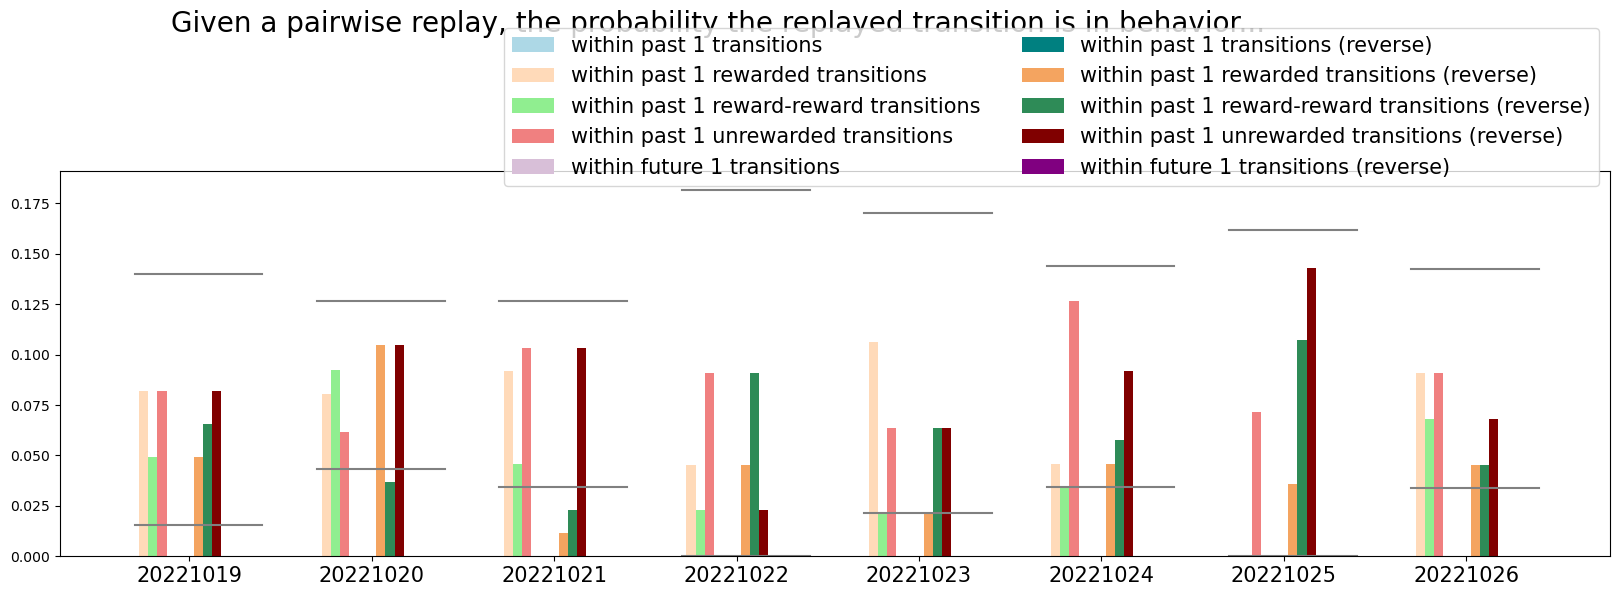

In [885]:
fig,axes = plt.subplots(1,1,figsize = (20,5))
WIDTH = 0.05
for i in range(len(dates_to_plot)):
    d = dates_to_plot[i]
    if i == 0:
        axes.bar(i,p_replay_all[d],color = 'lightblue',width = WIDTH,label = f'within past {LOOK_BACK_NUM} transitions')
        axes.bar(i+WIDTH,p_replay_reward[d],color = 'peachpuff',width = WIDTH,label = f'within past {LOOK_BACK_NUM} rewarded transitions')
        axes.bar(i+2*WIDTH,p_replay_reward_reward[d],color = 'lightgreen',width = WIDTH,label = f'within past {LOOK_BACK_NUM} reward-reward transitions')
        axes.bar(i+3*WIDTH,p_replay_nonreward[d],color = 'lightcoral',width = WIDTH,label = f'within past {LOOK_BACK_NUM} unrewarded transitions')
        axes.bar(i+4*WIDTH,p_replay_fu[d],color = 'thistle',width = WIDTH,label = f'within future {LOOK_BACK_NUM} transitions')
    else:
        axes.bar(i,p_replay_all[d],color = 'lightblue',width = WIDTH)
        axes.bar(i+WIDTH,p_replay_reward[d],color = 'peachpuff',width = WIDTH)
        axes.bar(i+2*WIDTH,p_replay_reward_reward[d],color = 'lightgreen',width = WIDTH)
        axes.bar(i+3*WIDTH,p_replay_nonreward[d],color = 'lightcoral',width = WIDTH)
        axes.bar(i+4*WIDTH,p_replay_fu[d],color = 'thistle',width = WIDTH)
        
    axes.plot([i, i+0.7],[p_replay_random_25[d],p_replay_random_25[d]],color = 'grey')
    axes.plot([i, i+0.7],[p_replay_random_975[d],p_replay_random_975[d]],color = 'grey')
    
axes.legend(loc='upper right', ncols=3,fontsize = 15,bbox_to_anchor=(1, 1.2))

axes.set_xticks(np.arange(len(dates_to_plot))+0.3)
axes.set_xticklabels(dates_to_plot,fontsize = 15)

"""reverse analysis"""
for i in range(len(dates_to_plot)):
    d = dates_to_plot[i]
    if i == 0:
        axes.bar(i+6*WIDTH,p_replay_all_r[d],color = 'teal',width = WIDTH,label = f'within past {LOOK_BACK_NUM} transitions (reverse)')
        axes.bar(i+7*WIDTH,p_replay_reward_r[d],color = 'sandybrown',width = WIDTH,label = f'within past {LOOK_BACK_NUM} rewarded transitions (reverse)')
        axes.bar(i+8*WIDTH,p_replay_reward_reward_r[d],color = 'seagreen',width = WIDTH,label = f'within past {LOOK_BACK_NUM} reward-reward transitions (reverse)')
        axes.bar(i+9*WIDTH,p_replay_nonreward_r[d],color = 'maroon',width = WIDTH,label = f'within past {LOOK_BACK_NUM} unrewarded transitions (reverse)')
        axes.bar(i+10*WIDTH,p_replay_fu_r[d],color = 'purple',width = WIDTH,label = f'within future {LOOK_BACK_NUM} transitions (reverse)')
    else:
        axes.bar(i+6*WIDTH,p_replay_all_r[d],color = 'teal',width = WIDTH)
        axes.bar(i+7*WIDTH,p_replay_reward_r[d],color = 'sandybrown',width = WIDTH)
        axes.bar(i+8*WIDTH,p_replay_reward_reward_r[d],color = 'seagreen',width = WIDTH)
        axes.bar(i+9*WIDTH,p_replay_nonreward_r[d],color = 'maroon',width = WIDTH)
        axes.bar(i+10*WIDTH,p_replay_fu_r[d],color = 'purple',width = WIDTH)

axes.text(0.2,0.26,'Given a pairwise replay, the probability the replayed transition is in behavior...',fontsize = 20);
axes.legend(loc='upper right', ncols=2,fontsize = 15,bbox_to_anchor=(1, 1.4))

### Plot 1b. Find intersection events

In [256]:
key_acausal = {'nwb_file_name': 'eliot20221023_.nwb',
        'interval_list_name': '02_Seq2Session1',
        'classifier_param_name':'default_decoding_gpu_4armMaze',
        'encoding_set':encoding_set}
key_causal = key_acausal.copy()
key_causal['classifier_param_name'] = 'causal_decoding_gpu_4armMaze'

trials_a = pd.DataFrame((TrialChoiceReplayTransition & key_acausal).fetch1('choice_reward_replay_transition'))
trials_c = pd.DataFrame((TrialChoiceReplayTransition & key_causal).fetch1('choice_reward_replay_transition'))

In [274]:
transition_session = np.zeros((4,4))

for t in [60]:#trials_a.index:
    r_a = set(trials_a.loc[t].replayed_transitions)
    r_c = set(trials_c.loc[t].replayed_transitions)
    common_t = r_a.intersection(r_c)
    for ct in common_t:
        i = int(ct[0])-1
        j = int(ct[1])-1
        transition_session[i,j] += 1

In [275]:
common_t

set()

In [261]:
transition_session

array([[0., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [2., 1., 1., 0.]])

In [121]:
trials_c.loc[18].replayed_transitions

[]

In [133]:
a = set([(2,4),(1,3)])
b = set([(2,4),(1,3)])

In [135]:
c = a.intersection(b)

In [136]:
c

{(1, 3), (2, 4)}

### Plot 2. Correlation with the sequence

In [302]:
version = 2
transition_dict = {}
for d_ind in range(len(dates_to_plot)):
    d = dates_to_plot[d_ind]
    transition_dict[d] = P_replay_all[d][version]
    
xcorr_replay_plot= findXCorrAllDays(transition_dict)

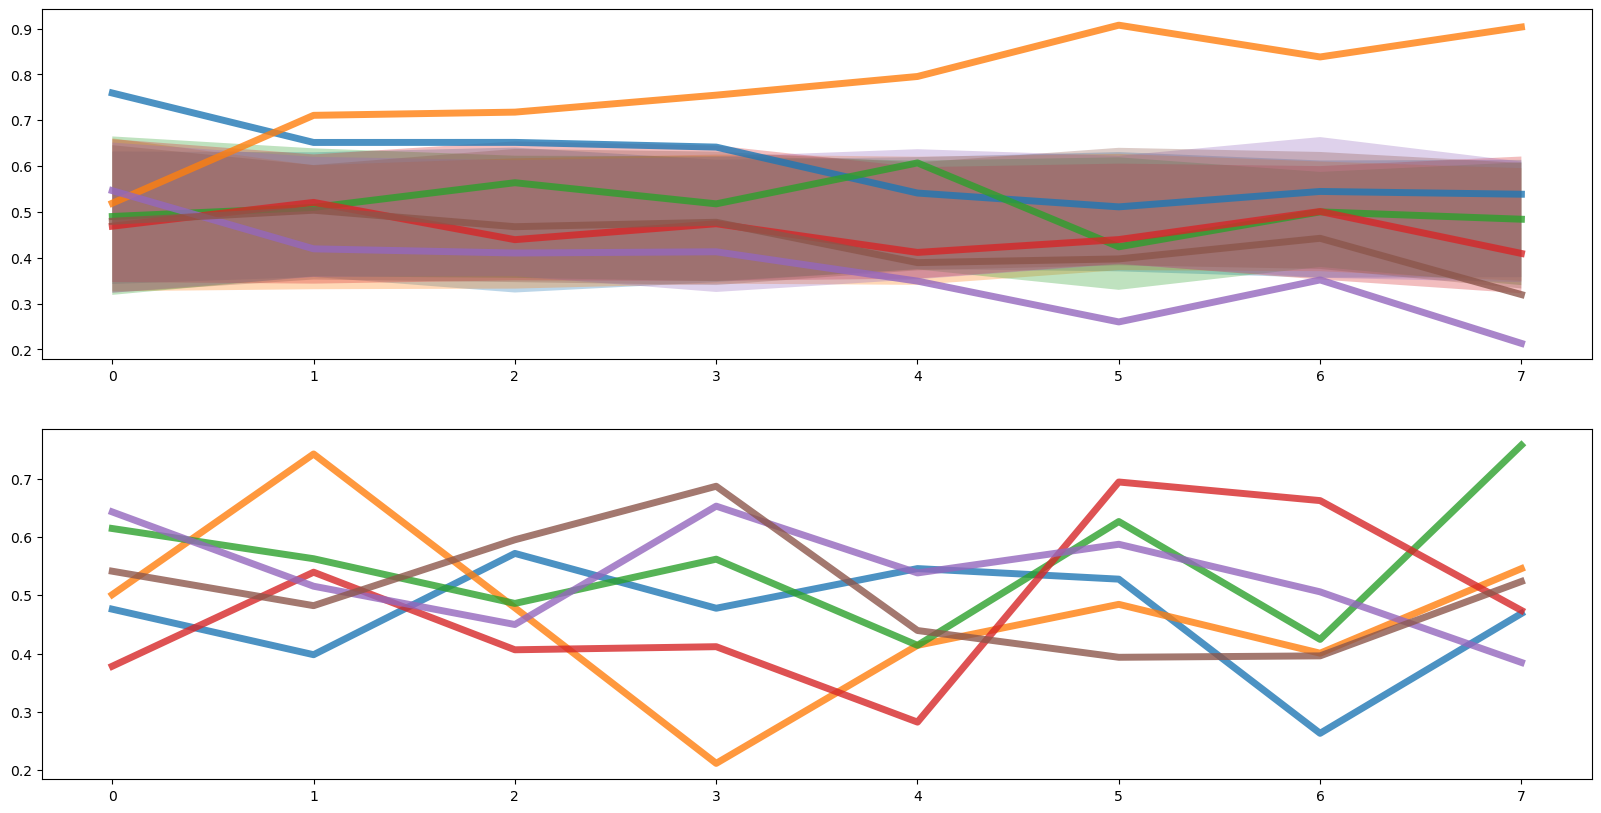

In [303]:
f,axes = plt.subplots(2,1,figsize = (20,10))
for seq_ind in range(6):
    axes[0].plot(xcorr_plot[:,seq_ind],'C'+str(seq_ind),linewidth = 5,alpha=0.8)
    axes[0].fill_between(np.arange(len(dates_to_plot)),
                    xcorr25_plot[:,seq_ind],
                    xcorr975_plot[:,seq_ind], facecolor='C'+str(seq_ind), alpha=0.3)

for seq_ind in range(6):
    axes[1].plot(xcorr_replay_plot[:,seq_ind],'C'+str(seq_ind),linewidth = 5,alpha=0.8)

### Investigate another session

In [224]:
session_interval

['02_Seq2Session1', '04_Seq2Session2', '06_Seq2Session3', '08_Seq2Session4']

In [48]:
key = {'nwb_file_name': nwb_copy_file_name, 'interval_list_name': '04_Seq2Session2'}
T_transition_ = pd.DataFrame((TrialChoiceReplayTransition() & key).fetch1(
    'choice_reward_replay_transition'))
matrix_transition_ = pd.DataFrame((TrialChoiceReplayTransition() & key).fetch1(
    'transitions'))

In [49]:
T_transition_[:40]

,timestamp_H,Home,timestamp_O,OuterWellIndex,replayed_transitions,rewardNum,ripple_H,ripple_O,replay_H,replay_O,ripple_ID_H,ripple_ID_O,current,future_H,future_O,past,past_reward
1,1.666468e+09,1.0,1.666468e+09,2.0,[],1.0,[],"[[[1666467957.1042895, 1666467957.1802895], [1...",[],"[[[4], [4], [2]]]",[],[1],2.0,2.0,4.0,NaN,NaN
2,1.666468e+09,1.0,1.666468e+09,4.0,[],1.0,[],"[[[1666467971.4162765, 1666467971.910276]]]",[],[[[4]]],[],[2],4.0,4.0,3.0,2.0,NaN
3,1.666468e+09,1.0,1.666468e+09,3.0,"[(1, 3)]",2.0,"[[[1666467986.9242623, 1666467987.114262], [16...",[],"[[[0, 3], [0]], [[0]], [[1], [3]]]",[],"[3, 4, 5]",[],3.0,3.0,1.0,4.0,NaN
4,1.666468e+09,1.0,1.666468e+09,1.0,[],1.0,"[[[1666468033.5662196, 1666468033.8102193]]]",[],[[[0]]],[],[6],[],1.0,1.0,4.0,3.0,3.0
5,1.666468e+09,1.0,1.666468e+09,4.0,[],2.0,"[[[1666468058.1321971, 1666468058.2501972], [1...","[[[1666468074.1761825, 1666468074.3281825], [1...","[[[0], [2], [], []], [[0], [3], []]]","[[[4], [], []], [[], [0]], [[3, 4]], [[4]]]","[7, 8]","[9, 10, 11, 12]",4.0,4.0,2.0,1.0,3.0
6,1.666468e+09,1.0,1.666468e+09,2.0,[],2.0,"[[[1666468091.9001665, 1666468092.0261662], [1...","[[[1666468100.436159, 1666468100.7301583]], [[...","[[[0], [0]], [[], []]]","[[[2]], [[2, 3], [3], [2]], [[2]], [[2], [2]]]","[13, 14]","[15, 16, 17, 18]",2.0,2.0,3.0,4.0,4.0
7,1.666468e+09,1.0,1.666468e+09,3.0,[],1.0,"[[[1666468129.8861315, 1666468130.0101316], [1...",[],"[[[], [], [], [0]], [[], [0]]]",[],"[19, 20]",[],3.0,3.0,1.0,2.0,2.0
8,1.666468e+09,1.0,1.666468e+09,1.0,[],2.0,"[[[1666468148.7041144, 1666468148.9621143], [1...","[[[1666468162.6301017, 1666468162.7521017], [1...","[[[0, 3], [], [0]]]","[[[], [], [], [0]]]",[21],[22],1.0,1.0,4.0,3.0,2.0
9,1.666468e+09,1.0,1.666468e+09,4.0,[],1.0,"[[[1666468180.2980857, 1666468180.5160854], [1...",[],"[[[0], [0]], [[0, 2], [], [0], [], [0]], [[0]]...",[],"[23, 24, 25, 26, 27]",[],4.0,4.0,2.0,1.0,1.0
10,1.666468e+09,1.0,1.666468e+09,2.0,[],1.0,"[[[1666468201.668066, 1666468201.784066], [166...",[],"[[[], [], [0]]]",[],[28],[],2.0,2.0,1.0,4.0,1.0


In [227]:
matrix_transition_ 

,0,1,2,3
0,7.0,0.0,0.0,1.0
1,0.0,3.0,0.0,2.0
2,0.0,2.0,7.0,0.0
3,0.0,9.0,2.0,17.0
